This is the notebook to make all the MW forward model plots!

In [1]:
#after downloading the data from Zenodo, put the folder path for where the data folder is sitting
#for example : data_path = "Users/Astro/Deskop/MK22_data_files"
data_path = ""

#the path to the MW selection function from Drlica Wagner et al. 2020 (https://ui.adsabs.harvard.edu/abs/2020ApJ...893...47D/abstract)
#the selection function is available here https://github.com/des-science/mw-sats
#clone this repository to your local machine and put its path below
#for example : mw_selection_function_path = "Users/Astro/Deskop/mw-sats"
mw_selection_function_path = ""


In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from os.path import join,exists,isfile
import glob
from collections import OrderedDict
import time
from os import listdir
import matplotlib.patheffects as pe
from scipy.stats import binned_statistic
from collections import OrderedDict as odict
from tqdm.notebook import tqdm
import yaml
from scipy import stats
import xgboost as xgb
import math
from matplotlib.ticker import MultipleLocator, FixedLocator, FormatStrFormatter
import numpy as np
import healpy as hp
from astropy.table import Table, Column, MaskedColumn
from astropy.io import ascii
from astropy import units as u
from astropy.coordinates import SkyCoord
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
#the constraints for MW mass withing 100 kpc are 
#5.6 \pm 0.4 e11


def plot_pretty(dpi=175,fontsize=9):
    # import pyplot and set some parameters to make plots prettier
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)
    plt.rc("figure", dpi=dpi)
    plt.rc('text', usetex=True)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in') 
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1])

    return

plot_pretty()


def get_shade(xdata,ydata,num_bins):
    """Return xbincenters,ymedian and percentiles"""
    
    #get the xdata and ydata and linearly interpolate between them 
#     xtr = np.linspace(np.min(xdata),np.max(xdata),1000)
#     ytr = np.interp(xtr, xdata[::-1], ydata[::-1])

    xtr = xdata
    ytr = ydata
    
    y_md,be, m = binned_statistic(xtr,ytr, statistic="median",   bins=num_bins)
    y_23,be, m = binned_statistic(xtr,ytr, statistic=prctile_23, bins=num_bins)
    y_977,be, m = binned_statistic(xtr,ytr, statistic=prctile_977, bins=num_bins)
    y_159,be, m = binned_statistic(xtr,ytr, statistic=prctile_159, bins=num_bins)
    y_841,be, m = binned_statistic(xtr,ytr, statistic=prctile_841, bins=num_bins)
    
    x_bins = (be[:-1]+be[1:])/2
    
    return x_bins, y_md, y_23,y_977, y_159, y_841

def plot_median_shade(xpts,ypts,nbins=20,color='r',label= "stuff",ax=None):
    xc = np.concatenate(np.array(xpts,dtype=object))
    yc = np.concatenate(np.array(ypts,dtype=object))
    x_bins, y_md, y_23,y_977,y_159, y_841 = get_shade(xc,yc,num_bins=nbins)
    if ax == None:
        plt.fill_between(x_bins, 10**y_23,10**y_977, facecolor=color, alpha=0.15) 
        plt.fill_between(x_bins, 10**y_159,10**y_841, facecolor=color, alpha=0.55,label = label) 
#         plt.plot(x_bins,10**y_md, c=color, lw=1.5,label = label)
    else:
        ax.fill_between(10**x_bins, 10**y_23,10**y_977, facecolor=color, alpha=0.15)
        ax.fill_between(x_bins, 10**y_159,10**y_841, facecolor=color, alpha=0.55,label = label) 
#         ax.plot(x_bins,10**y_md, c=color, lw=1.5,label = label)
    return

def give_survs(probabs,quants):    
    rnd = np.random.uniform(size = np.shape(probabs))
    mask = probabs > rnd
    quants_detect = quants[mask == 1]
    return quants_detect

def perc975(x):
    return np.percentile(x,97.5)
def perc998(x):
    return np.percentile(x,99.8)
def perc002(x):
    return np.percentile(x,0.2)
def perc025(x):
    return np.percentile(x,2.5)
def perc023(data):
    return np.percentile(data,2.3)
def perc977(data):
    return np.percentile(data,97.7)
def perc159(data):
    return np.percentile(data,15.9)
def perc841(data):
    return np.percentile(data,84.1)


def nfw_fx(x):
    return np.log(1+x) - (x/(1+x))

def compute_mass_100(mvir,rvir,rs):
    '''
    Function that computes the mass enclosed within 100kpc of the host center assuming an NFW profile.
    '''
    
    c = rvir/rs
    
    x = 100/rvir #100kpc enclosed mass
    
    menc = mvir * nfw_fx(c*x) / nfw_fx(c)
    
    return menc
    
    
def get_linear_hist(xdata,oppo=True,minx = 0):
    
    xsort = np.sort(xdata)
    max_num = len(xdata)
    
    if oppo==True:
        xsort = xsort[::-1]
        xpts = [minx] + list(np.concatenate(list(zip(xsort,xsort))))
        numrange = np.arange(1,max_num+1)[::-1]
        ypts = list(np.concatenate(list(zip(numrange,numrange))  )) + [0]
        
    else:
        xpts = list(np.concatenate(list(zip(xsort,xsort)))) + [minx]
        numrange = np.arange(1,max_num+1)
        
        ypts = [0] + list(np.concatenate(list(zip(numrange,numrange))  ))
    
    
    return xpts,ypts
        



import concurrent.futures
from tqdm.notebook import tqdm

def run_parallel(func, iter_input):
    '''
    running a function in parallel.

    Parameters:
    -----------
        func: function, the function to be parallelized
        iter_input: list, the list of function inputs to loop over

    Returns:
    -----------
        results: list, entire function output

    '''
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = list(tqdm(executor.map(func,iter_input), total = len(iter_input))) 
    return results
    


In [3]:
## MW Observational data

## ALL THE OBSERVATIONAL DATA

## This is data for SDSS magnitudes 
#We compare our predictions to the following classical and SDSS-identified MW satellites compiled in McConnachie (2012)
#LMC, SMC, Sagittarius I, Fornax, Leo I, Sculptor, Leo II, Sextans I, Carina, Draco, and Ursa Minor (classical), 
#and Canes Venatici I, Hercules, Boötes I, Leo IV, Ursa Major I, Leo V, Pisces II, Canes Venatici II, 
#Ursa Major II, Coma Berenices, Willman I, Boötes II, Segue II, and Segue I (SDSS). 
#We exclude Pisces I and Pegasus III because they were discovered using methods that do not adhere to our assumed SDSS 
#detection criteria (described as follows), 
#and we exclude Leo T because it lies outside of our fiducial 300 kpc reference radius. 

# We define mock classical satellites as objects with MV < −8.8 mag,
# and we assume that observations of these systems are complete. 
# We plot systems within 300 kpc that pass both the surface brightness limit of 30 mag arcsec−2

sdss_class_mags = [-18.12,-17.18,-13.5,-13.46,-11.78,-10.82,-9.74,-8.72,-9.43,-8.71,-9.03,-8.80,-5.83,-6.02,-4.99,-5.12,
             -4.40,-4.22, -5.17, -4.25, -4.38, -2.53, -2.94,-1.30, -1.86]    
    
#this is the 2d light radius. Some papers suggest that 3d half mass radius = 2d light radius 
sdss_class_sizes = [4735, 2728,1565, 707, 226, 223, 165, 345, 248, 180, 272, 338, 120, 160, 104, 151, 39, 48, 55, 
                   85, 57, 20, 33, 20, 34] 


sdss_class_heliods = [50, 62, 26, 147, 254, 84, 233,86, 105, 76, 76, 218, 132, 66, 154, 97, 178, 182, 160, 32, 44, 42, 38, 35, 23 ]

#SDSS satellites
# Canes Venatici I, Hercules, BoötesI, Leo IV, Ursa Major I, Leo V, Pisces II, Canes Venatici II,
# Ursa Major II, Coma Berenices, Willman I, Boötes II, Segue II,
# and Segue I
#there are a total of 14 satellites

sdss_only_heliods = [218,132,66,154,97,178,182,160,32,44,38,42,35,23]
print(len(sdss_only_heliods))

#data for DES and PS1
mw_data = np.loadtxt(data_path + "drlica_wagner20_tab2_read.txt",dtype="str")

#these values have been taken from Nadler et. al. 2020 paper

mw_lf_des = [-13.46, -10.82, -3.88, -3.8, -3.9, -3.55, -2.4, -3.5, -3.30, -2.6, -1.6, -3.45, -4.2, 0.02, -3.47, -3.31]
mw_lf_ps1 = [-11.78,-9.74,-8.71,-9.03,-8.72,-8.8,-6.02, -4.25, -4.38, -5.2, -2.53, -5.17,-1.30, -1.86, -8.2, -0.8, -1.60, -5.83,0]

mw_lf_desps1 = mw_lf_des + mw_lf_ps1[:-1] #the -1 to avoid repition in Cetus II
print(mw_lf_desps1)

mw_des_heliods = [147, 84, 30, 58, 53, 79, 25, 48, 83, 78, 55, 114, 183, 30, 120, 92]
mw_ps1_heliods = [254, 233, 76, 76, 86, 218, 66, 32, 44, 69, 38, 160, 23, 35, 117, 22, 30, 132,30]

mw_desps1_heliods = np.array(mw_des_heliods + mw_ps1_heliods[:-1]) 
print(mw_desps1_heliods)

mw_des_r12 = [707,223, 31, 165, 92, 31, 44, 128, 21, 33, 16, 18, 98, 17, 21, 64]

mw_ps1_r12 = [226, 165, 180, 272, 345, 338, 160, 85, 57, 32, 20, 55, 20, 34, 1066, 17, 13, 120,17]


mw_hsc_lf = [-8.72,-4.99,-3.4,-2.5,-0.33,-4.53 ]
#Sextans, Leo IV, Pegasus III, Cetus III, Virgo I, Bootes IV
x_hsc_lf, y_hsc_lf = get_linear_hist(mw_hsc_lf)

mw_desps1_r12 = mw_des_r12 + mw_ps1_r12[:-1] 
print(len(mw_desps1_r12))

print(len(sdss_class_sizes))


## converting the lists in hist format so can be plotted
x_dp_h, y_dp_h = get_linear_hist(mw_desps1_heliods,oppo=False,minx =310)
x_p_h, y_p_h = get_linear_hist(mw_ps1_heliods,oppo=False,minx =310)
x_d_h, y_d_h = get_linear_hist(mw_des_heliods,oppo=False,minx =310)

x_d_r, y_d_r = get_linear_hist(mw_des_r12,oppo=False,minx =3100)
x_dp_r, y_dp_r = get_linear_hist(mw_desps1_r12,oppo=False,minx =3100)
x_p_r, y_p_r = get_linear_hist(mw_ps1_r12,oppo=False,minx =3100)


x_d_lf, y_d_lf = get_linear_hist(mw_lf_des)
x_dp_lf, y_dp_lf = get_linear_hist(mw_lf_desps1)
x_p_lf, y_p_lf = get_linear_hist(mw_lf_ps1)


x_sdss_lf, y_sdss_lf = get_linear_hist(sdss_class_mags)
x_sdss_h, y_sdss_h = get_linear_hist(sdss_class_heliods,oppo=False,minx = 310)
x_sdss_r, y_sdss_r = get_linear_hist(sdss_class_sizes,oppo=False,minx =5500)



14
[-13.46, -10.82, -3.88, -3.8, -3.9, -3.55, -2.4, -3.5, -3.3, -2.6, -1.6, -3.45, -4.2, 0.02, -3.47, -3.31, -11.78, -9.74, -8.71, -9.03, -8.72, -8.8, -6.02, -4.25, -4.38, -5.2, -2.53, -5.17, -1.3, -1.86, -8.2, -0.8, -1.6, -5.83]
[147  84  30  58  53  79  25  48  83  78  55 114 183  30 120  92 254 233
  76  76  86 218  66  32  44  69  38 160  23  35 117  22  30 132]
34
25


In [21]:
df_ufsc = pd.read_csv(data_path + "UFSC_list.csv")
# df_ufsc = pd.read_csv(data_path + "UFSC_for_Viraj.csv")

#Crater 1, Kim 2, HSC 1, DELVE 1, DES SAG 2?
new_r12_ufsc = [6.89,12,19.53,5.43,4.32]


In [4]:
config = yaml.safe_load(open(mw_selection_function_path + '/config.yaml'))

BITS = config['maskbits']
BADBITS = (BITS['EBV'] | BITS['ASSOC'] | BITS['STAR'] | BITS['FOOT'] | \
           BITS['FAIL'] | BITS['ART'])

def get_filepath(survey,filetype):
    """Get the filepath for a specific survey and filetype.
    
    Parameters
    ----------
    survey   : survey of interest ['des','ps1']
    filetype : type of data file
    
    Returns
    -------
    filepath : path to file
    """
    filepath = join(config['datadir'],config[survey][filetype])
    filepath = mw_selection_function_path + filepath[1:] #we change the directory because the data folder is located in mwsats folder
    print(filepath)
    return filepath

class SurveySelectionFunction(object):
    """Survey selection function including spatial information."""

    def __init__(self, survey):
        """Initialize survey selection function."""
        self.survey = survey
        print("Loading model...")
        self.model = xgb.XGBClassifier()
        self.model.load_model(get_filepath(self.survey,'model'))
        print("Loading mask...") # This can take a while...
        self.mask = hp.read_map(get_filepath(self.survey,'mask'),dtype=int)
        print("Loading stellar density map...")
        self.density = hp.read_map(get_filepath(self.survey,'density'))

    @staticmethod
    def get_hpxmap_value(hpxmap,lon,lat):
        """Get the value of a healpix map at a given location.
        
        Parameters
        ----------
        hpxmap : HEALPix map (must be in same frame as `lon` and `lat`)
        lon : longitude [deg]
        lat : latitude [deg]
        
        Returns
        -------
        value : healpix map value
        """
        nside = hp.get_nside(hpxmap)
        pix   = hp.ang2pix(nside,lon,lat,lonlat=True)
        return hpxmap[pix]
        
    def get_stellar_density(self, ra, dec):
        """Calculate the stellar density at the location of each satellite.

        Parameters
        ----------
        ra : right ascension [deg]
        dec: declination [deg]
        
        Returns
        -------
        stellar_density : stellar density [stars/arcmin^2]
        """
        return self.get_hpxmap_value(self.density,ra,dec)

    def get_mask_value(self, ra, dec):
        """Calculate the mask value at the location of each satellite.

        Parameters
        ----------
        ra : right ascension [deg]
        dec: declination [deg]
        
        Returns
        -------
        value : mask value
        """
        return self.get_hpxmap_value(self.mask,ra,dec)
    
    def predict(self, distance, abs_mag, r_physical, ra, dec):
        """Predict the satellite detection probability for a survey.
        
        Parameters
        ----------
        distance   : Heliocentric distance [kpc]
        abs_mag    : Absolute V-band magnitude
        r_physical : Physical azimuthally averaged half-light radius [kpc]
        ra         : Right ascension [deg]
        dec        : Declination [deg]

        Returns
        -------
        pdet : detection probability
        """
        # Calculate the stellar density at the location of each satellite.
        stellar_density = self.get_stellar_density(ra,dec)
        
        # Evaluate the model for each satellite
        x_eval = np.vstack([np.log10(distance), abs_mag, np.log10(r_physical), stellar_density]).T
        pred = self.model.predict_proba(x_eval)[:,1]

        #Calculate the mask value at the location of each satellite.
        mask_value = self.get_mask_value(ra,dec)
        # Set pdet to zero for satellites in masked area
        bad = (mask_value & BADBITS) != 0
        pred[bad] = 0
        
        return pred



ps1_ssf = SurveySelectionFunction('ps1')
des_ssf = SurveySelectionFunction('des')


Loading model...
/Users/radioactive/Desktop/ELVIS_Code/scripts/mw-sats/data/classifier_stellar_ps1_v13.0.1.model
[23:16:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:727: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
Loading mask...
/Users/radioactive/Desktop/ELVIS_Code/scripts/mw-sats/data/healpix_mask_ps1_v6.0.fits.gz


/Users/radioactive/.local/lib/python3.7/site-packages/xgboost/sklearn.py:417: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  'Loading a native XGBoost model with Scikit-Learn interface.')


NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Loading stellar density map...
/Users/radioactive/Desktop/ELVIS_Code/scripts/mw-sats/data/ps1_stellar_density_r22_equ_n128_v0.fits
NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Loading model...
/Users/radioactive/Desktop/ELVIS_Code/scripts/mw-sats/data/classifier_stellar_des_v12.2.0.model
[23:17:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:727: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
Loading mask...
/Users/radioactive/Desktop/ELVIS_Code/scripts/mw-sats/data/healpix_mask_des_v6.0.fits.gz


/Users/radioactive/.local/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Loading stellar density map...
/Users/radioactive/Desktop/ELVIS_Code/scripts/mw-sats/data/des_stellar_density_r22_equ_n128_v0.fits
NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [143]:
def convert_to_helio(xc,yc,zc,disk = False):
    '''
    Function that converts to heliocentric frame by randomizing the location of the sun.
    xc[0], yc[0],zc[0] must be location of the host galaxy center so must be 0,0,0
    
    
    '''
    
    #host is at 0,0,0
    #the distance of Sun from MW center is assumed to be 8 kpc.
    #for sun's position generate a random co-ordinate on the surface 
    #of a sphere with radius 8 Kpc with host as center (0,0,0). The position of point
    #automatically constraints the disk. So it is as if we are choosing a random disk orientation

    x_sun = []
    
    theta = 2*np.pi*np.random.uniform(0,1)
    phi = np.arccos(1 - 2*np.random.uniform(0,1))
    x_sun = 8*np.sin(phi) * np.cos(theta)
    y_sun = 8*np.sin(phi) * np.sin(theta)
    z_sun = 8*np.cos(phi)
    
    if disk == True:
        z_sun = 0*z_sun
        
    #reposition such that sun is now at center
    #we originally have coordinates in galactocentric frame 
    
    if xc[0] != 0 or yc[0] != 0 or zc[0] != 0:
        print("Host center issue in convert_to_helio funtion")
    
    xnew = xc - x_sun
    ynew = yc - y_sun
    znew = zc - z_sun
    #now, we will convert to galactic co-ordinates L and B
    #in galactic coordinate frame which is centered at Sun. Galaxy center is at (R,0,0)
    heliods = np.sqrt(xnew**2 + ynew**2 + znew**2) #all distances of subhalos from Sun
    
    return xnew, ynew, znew, heliods


def get_ra_dec(xc,yc,zc):
    '''
    Function that takes in HELIOCENTRIC cartesian coordinates and returns the coordinates
    in equatorial coordinate system (RA, Dec) by assuming random MW disk orientations (aka position of Sun).
    
    The coordinates of the host are not needed here as the coordinates transformation to center of sun
    has already been done. 
    
    This has been confirmed to work by cross checking with Nadler's code on his github repository
    
    '''    
    
    #construct the SkyCoord object     
    all_sats = SkyCoord(x = xc, y=yc, z=zc,unit = "kpc",representation_type = "cartesian")
    #convert to equatorial frame in RA and DEC
    all_sats =all_sats.fk5
    ra_f = all_sats.ra.value
    dec_f = all_sats.dec.value
    return ra_f,dec_f

def transform_to_sky_coords(xc,yc,zc):
    '''
    This function is from Nadler's github code. This works the exact same way as get_ra_dec function above that I wrote.
    '''
    Halo_sky_coord = SkyCoord(x=xc,y=yc,z=zc,
                              unit='kpc',representation_type='cartesian').spherical
    return Halo_sky_coord.lon.degree, Halo_sky_coord.lat.degree

#functions for rotating to LMC coordinates 
def do_rotation(all_pos,vec1,vec2):
    """
    Returns heliocentric satellite position vectors transformed via a rotation matrix that rotates the mock LMC analog into its correct sky position
    Args:
    all_pos (array): (N,3) array of heliocentric satellite positions in cartesian coordinates
    vec1 (array): original cartesian heliocentric coordinates of mock LMC 
    vec2 (array): final cartesian heliocentric coordinates of mock LMC to which it is being shifted
    Returns:
    rotated_pos (array): array of position vectors in rotated frame
    """
    rotated_pos = np.zeros(np.shape(all_pos))

    a,b = (vec1/np.linalg.norm(vec1)), (vec2/np.linalg.norm(vec2))
    
    v = np.cross(a,b) #the magnitude of this vector is sin(theta) as a,b are normalized
    c = np.dot(a,b) #as a,b are normalized vectors the dot product is equal to cosine
    s = np.linalg.norm(v) #calculating the magnitude of vector v = a x b
    I = np.identity(3) #3 x3 identity matrix

    vXStr = '{} {} {}; {} {} {}; {} {} {}'.format(0., -v[2], v[1], v[2], 0., -v[0], -v[1], v[0], 0.)
    K = np.matrix(vXStr)
    R = I + K + np.matmul(K,K) * ((1.-c)/(s**2))

    for i in range (0,len(rotated_pos)):
        temp_vec = (all_pos[i][0],all_pos[i][1],all_pos[i][2])
        (rotated_pos[i][0],rotated_pos[i][1],rotated_pos[i][2]) = np.asarray(R*np.reshape(temp_vec,(3,1)))[:,0]

    return rotated_pos

def get_lmc_coords(lmc_distance,lmc_true_sky_coords='05:23:34.5 -69:45.37',random=False):
    """
    We have a LMC in our system 
    we calculate its current position in RA, Dec. We then rotate all the satellites
    such that the LMC analog is now in the position of the actual LMC
    
    the position in RA and DEC is 
    

    """
    #I do not think the distance really affects anything
    if random == False:
        lmc_sky_coords = SkyCoord(lmc_true_sky_coords,unit=(u.hourangle, u.deg),distance=lmc_distance*u.kpc)
        lmc_cartesian_coords = np.array(lmc_sky_coords.cartesian.xyz)
    else:
        #we choose a random pointing
        ###compute the area in the above footprint
        halfpi, pi, twopi = [f*np.pi for f in [0.5, 1, 2]]
        degs, rads = 180/pi, pi/180
        ran1, ran2 = np.random.random(2).reshape(2, -1)
        ra_test  = float(twopi * (ran1 - 0.5)*degs + 180)
        dec_test = float(np.arcsin(2.*(ran2-0.5))*degs )
#         print(ra_test,dec_test)
        lmc_sky_coords = SkyCoord(ra = ra_test*u.deg,dec = dec_test*u.deg,distance=100*u.kpc)
        lmc_cartesian_coords = np.array(lmc_sky_coords.cartesian.xyz)
    
    return lmc_cartesian_coords


##SDSS footprint mask function 
mask_data = np.loadtxt("data/sdss_mask.txt")
ra_val = mask_data[0]
dec_val = mask_data[1]
mask_val = mask_data[2]

NSIDE = 32
pixel_indices = hp.ang2pix(NSIDE,ra_val,dec_val,lonlat = True)

bin_count_sdss_foot = np.bincount(pixel_indices) 
bin_count_null_sdss_foot = np.bincount(pixel_indices[mask_val == 0]) 


def SDSS_footprint(ra,dec):
    
    
    footprint_mask = []
    
    for k in range(len(ra)):
        rak = ra[k]
        deck = dec[k]
    
        vec = hp.ang2vec(rak,deck,lonlat = True)
        pix_od = hp.query_disc(nside=NSIDE,vec=vec,radius=np.radians(1.2))
        tot_stars = np.sum(bin_count_sdss_foot[pix_od]) - np.sum(bin_count_null_sdss_foot[pix_od])
        if tot_stars > 0:
            footprint_mask.append(1)
        else:
            footprint_mask.append(0)
            
            
    return np.array(footprint_mask)

    
def HSC_footprint(ra,dec):
    '''
    randomly seletion 676/1400 fraction of objects in the footprint area. 
    
    1 hour = 15 degrees
    
    I have be careful if my RA are between 0 and 360 or 180 and -180.
    
    This footprint has been derived from Table 5 in The Hyper Suprime-Cam SSP Survey:
    Overview and survey design paper
    
    '''
    
    mask = []
    
    
    for i in range(len(ra)):
        
        rai = ra[i]
        deci = dec[i]
        
        if  42 < deci and deci < 44.5 and 200 < rai and rai < 250:
            mask.append(1)
            
        elif -2 < deci and deci < 5 and 135 < rai and rai < 232.5:
            mask.append(1)
            
        elif -1 < deci and deci < 7 and  330 < rai and rai < 360:
            mask.append(1)
            
        elif -1 < deci and deci < 7 and  0 < rai and rai < 40:
            mask.append(1)
            
        elif -7 < deci and deci < -1 and 27.5 < rai and rai < 40:
            mask.append(1)
            
            
        else:
            mask.append(0)
            
            
    mask = np.array(mask)
            
    return mask



def LSST_footprint(ra,dec):
    '''
    Function for LSST footprint
    
    https://pstn-051.lsst.io/v/v1.0/PSTN-051.pdf
    
    Rhodes 2017 LSST EUCLID synergy paper

    '''
    
    c_icrs = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    c_gal = c_icrs.galactic
    all_ls = c_gal.l.deg
    all_bs = c_gal.b.deg

    mask = np.zeros(shape = np.shape(dec))
    
    mask[(dec < 30) & (np.abs(all_bs) > 15)] = 1
    
    #this has to be 15 degrees above the galactic plane
    
    ##NEED TO INCREASE THE FOOTPRINT OF LSST

    return mask
             
    

def SDSS_predict(distance =None, mv = None, r12 = None,ra = None,dec = None):
    '''
    Function that applies the SDSS function 
    
    r12 has to be in kpc
    '''
    
    probs_all = np.zeros(shape = np.shape(mv))
    #we will populate the above array now
    probs_all[mv < -11] = 1 #assigning all classical sats a 100% detection chance. the surface brightness will be appleid at the end
    
    #distance in kpc
    mv_threshold = (1.1 - np.log10(distance))/0.228
    
    detect_mask = mv < mv_threshold
    probs_all[detect_mask] = 1

    all_surfs = mv + 21.5721 + 2.5*np.log10(2*np.pi*(1e3*r12)**2)
    probs_all[all_surfs > 30] = 0
        
    return probs_all


def SDSS_only_predict(distance =None, mv = None, r12 = None,ra = None,dec = None):
    '''
    Function that applies the SDSS function 
    
    r12 has to be in kpc
    '''
    
    probs_all = np.zeros(shape = np.shape(mv))
    #we will populate the above array now
#     probs_all[mv < -11] = 1 #assigning all classical sats a 100% detection chance. the surface brightness will be appleid at the end
    
    #distance in kpc
    mv_threshold = (1.1 - np.log10(distance))/0.228
    
    detect_mask = mv < mv_threshold
    probs_all[detect_mask] = 1

    all_surfs = mv + 21.5721 + 2.5*np.log10(2*np.pi*(1e3*r12)**2)
    probs_all[all_surfs > 30] = 0
    
    mask_sdss = SDSS_footprint(ra,dec)
        
        
    probs_all[mask_sdss == 0] = 0
        
    return probs_all

def SDSS_only_predict_ufd(distance =None, mv = None, r12 = None,ra = None,dec = None):
    '''
    Function that applies the SDSS function 
    
    r12 has to be in kpc
    '''
    
    probs_all = np.zeros(shape = np.shape(mv))
    #we will populate the above array now
#     probs_all[mv < -11] = 1 #assigning all classical sats a 100% detection chance. the surface brightness will be appleid at the end
    
    #distance in kpc
    mv_threshold = (1.1 - np.log10(distance))/0.228
    
    detect_mask = mv < mv_threshold
    probs_all[detect_mask] = 1

    all_surfs = mv + 21.5721 + 2.5*np.log10(2*np.pi*(1e3*r12)**2)
    probs_all[all_surfs > 30] = 0
    
    mask_sdss = SDSS_footprint(ra,dec)
        
        
    probs_all[mask_sdss == 0] = 0
    
    probs_all[mv < -8] = 0
        
    return probs_all


def SDSS_only_predict_class(distance =None, mv = None, r12 = None,ra = None,dec = None):
    '''
    Function that applies the SDSS function 
    
    r12 has to be in kpc
    '''
    
    probs_all = np.zeros(shape = np.shape(mv))
    #we will populate the above array now
#     probs_all[mv < -11] = 1 #assigning all classical sats a 100% detection chance. the surface brightness will be appleid at the end
    
    #distance in kpc
    mv_threshold = (1.1 - np.log10(distance))/0.228
    
    detect_mask = mv < mv_threshold
    probs_all[detect_mask] = 1

    all_surfs = mv + 21.5721 + 2.5*np.log10(2*np.pi*(1e3*r12)**2)
    probs_all[all_surfs > 30] = 0
    
    mask_sdss = SDSS_footprint(ra,dec)
        
        
    probs_all[mask_sdss == 0] = 0
    
    probs_all[mv > -8] = 0
        
    return probs_all


des_model = xgb.XGBClassifier()
filename = get_filepath('des','model')
print("Loading model from %s..."%filename)
des_model.load_model(filename)


def DELVE_predict(distance = None, mv = None,r12 = None,ra=None,dec=None):
    #first pass them through the DES Y3 selection function to get detected probs
#     stellar_density = 1.0*np.ones(len(distance))
    stellar_density = des_ssf.get_stellar_density(ra,dec)
    #the r_physical has to be in kpc units
    x_eval = np.vstack([np.log10(distance), mv, np.log10(r12), stellar_density]).T
    delve_pdet = des_model.predict_proba(x_eval)[:,1]
    delve_pdet[mv < -12] = 1
    #THE ABOVE IS A HACK AS THE SEARCH ALGORITHIM USED HERE IS OPTIMAL FOR UFDs...
    
    #then apply mask of Dec < 0 and |b| > 10
    #first convert ra,dec to L,B
    c_icrs = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    c_gal = c_icrs.galactic
    all_ls = c_gal.l.deg
    all_bs = c_gal.b.deg
    #make blank array of zeroes
    foot_mask = np.zeros(shape = np.shape(mv))
    #below is the condition for the mask
    foot_mask[(dec < 0) & (np.abs(all_bs) > 10 )] = 1
    delve_pdet[foot_mask == 0] = 0
    delve_pdet[distance > 300] = 0 
    

    return delve_pdet


def LSST_predict(distance =None, mv = None, r12 = None,ra=None,dec=None):
    '''
    Function that applies the SDSS function 
    
    r12 has to be in kpc
    '''
    probs_all = np.zeros(shape = np.shape(mv))
    probs_all[mv < 0] = 1
    all_surfs = mv + 21.5721 + 2.5*np.log10(2*np.pi*(1e3*r12)**2)
    probs_all[all_surfs > 32] = 0
    probs_all[r12*1e3 < 10] = 0
    probs_all[distance > 300] = 0
    lsst_mask = LSST_footprint(ra,dec)
    probs_all[lsst_mask == 0] = 0
    return probs_all


def Classical_only(mv  = None,r12 = None):
    probs_all = np.zeros(shape = np.shape(mv))
    all_surfs = mv + 21.5721 + 2.5*np.log10(2*np.pi*(1e3*r12)**2)
    #only classical satellites Mv < -8 with surface brightness brighter than 32
    probs_all[(mv < -8) & (all_surfs < 30)] = 1
    return probs_all
    
def UFD_only(mv = None,r12 = None):
    probs_all = np.zeros(shape = np.shape(mv))
    
    probs_all[(mv < 0) & (mv > -8) & (1e3*r12 > 10)] = 1
    
    return probs_all


def HSC_predict(distance =None, mv = None,r12 = None,ra=None,dec=None,use_mask=True):
    '''
    Function that applies the SDSS function 
    
    r12 has to be in kpc
    '''
    
    probs_all = np.zeros(shape = np.shape(mv))
#     mv_threshold = (1.884 - np.log10(distance))/0.228 #in place of 1.92
    mv_threshold = 0*np.log10(distance) #in place of 1.92
    
#     mv_threshold = (1.932 - np.log10(distance))/0.187 #in place of 1.92

    detect_mask = mv < mv_threshold
    probs_all[detect_mask] = 1
    
    all_surfs = mv + 21.5721 + 2.5*np.log10(2*np.pi*(1e3*r12)**2)
    probs_all[all_surfs > 32] = 0
    probs_all[distance > 300]  = 0
    

    #then we apply maskk
    if use_mask == True:
        hsc_mask = HSC_footprint(ra,dec)
        probs_all[hsc_mask == 0] = 0
        
        #now to mimic the 676 deg in 1400 deg observations
        frac = 676/1400
        
        ndetect = probs_all.sum()
        nact =  int(np.round(ndetect*676/1400))
        
        
        probs_all_new = []
                    
        tot_count = 0
        for i,pi in enumerate(probs_all):
            if pi == 1:
                tot_count += 1
                
                if tot_count <= nact:
                    
                    probs_all_new.append(1)
                else:
                    probs_all_new.append(0)
                    
            else:
                probs_all_new.append(0)
                    
                    
        probs_all_new = np.array(probs_all_new)
        
        
        return probs_all_new
    
    else:
        return probs_all

    
    
def HSC_predict_total(distance =None, mv = None,r12 = None,ra=None,dec=None,use_mask=True):
    '''
    Function that applies the SDSS function 
    
    r12 has to be in kpc
    '''
    
    probs_all = np.zeros(shape = np.shape(mv))
#     mv_threshold = (1.884 - np.log10(distance))/0.228 #in place of 1.92
    mv_threshold = 0*np.log10(distance)
    

    detect_mask = mv < mv_threshold
    probs_all[detect_mask] = 1
    
    all_surfs = mv + 21.5721 + 2.5*np.log10(2*np.pi*(1e3*r12)**2)
    probs_all[all_surfs > 32] = 0
    
    #then we apply maskk

    hsc_mask = HSC_footprint(ra,dec)
    probs_all[hsc_mask == 0] = 0
    probs_all[distance > 300] = 0
    
    return probs_all
    

    
def obs_LF_prior(df,verbose = True,lmc_index_val=None,z_fidu_val = None,iteration = 0,disk=False):
    xfs, yfs, zfs = np.array(list(df['xpos']*1e3)),np.array(list(df['ypos']*1e3)),np.array(list(df['zpos']*1e3))
    host_dist = np.array(df['hdist'])
    if z_fidu_val is not None:
        scale_factor = 1/(1+z_fidu_val)
        host_dist = scale_factor*host_dist
        xfs=scale_factor*xfs
        yfs = scale_factor*yfs
        zfs=scale_factor*zfs
        if iteration == 0:
            print("Scale Factor :",scale_factor)
            print("Zred at fidu epoch :",z_fidu_val)
            
        #if we happen to be working in a different time epoch, we convert our comoving coordinates to physical space
        
    
    #place the sun at a random location
    xhc, yhc, zhc, heliods = convert_to_helio(xfs,yfs,zfs,disk=disk)
    
    rsizes = np.array(df['rsize']) #3d half mass radius, #this is in kpc units
    mVs = np.array(df['mV']) #mv
    mpeak = np.array(df['Mpeak']) #Mpeak
    m200c = np.array(df['M200c']) #Mpeak
    surv_p = np.array(df['surv_probs']) #survival probs
    
    rsizes_f = rsizes[(heliods < 300) & (host_dist > 0)]/1.34 #this is in kpc
    mVs_f = mVs[(heliods < 300) & (host_dist > 0)]

    mpeak_f = mpeak[(heliods < 300) & (host_dist > 0)]
    m200c_f = m200c[(heliods < 300) & (host_dist > 0)]
    
    host_dist_f = host_dist[(heliods < 300) & (host_dist > 0)]
    surv_p_f = surv_p[(heliods < 300) & (host_dist > 0)]
    ######

    xhc_f = xhc[(heliods < 300) & (host_dist > 0)]
    yhc_f = yhc[(heliods < 300) & (host_dist > 0)]
    zhc_f = zhc[(heliods < 300) & (host_dist > 0)]
    
    heliods_filter = heliods[(heliods < 300) & (host_dist > 0)]
    
    #calculate the LMC index
    if lmc_index_val is None:
        lmc_index = np.argmax(mpeak_f)
    else:
        lmc_index = lmc_index_val
        
    if iteration == 0:
        print("The LMC Mpeak mass is :",mpeak_f[lmc_index]/1e11 )
        print("The LMC hdist is :",host_dist_f[lmc_index] )

        #this lmc index is the index in the filterend list. So when compute it before hand, make sure similar cut done
    input_dict = {"xhc":xhc_f, "yhc":yhc_f, "zhc":zhc_f, "host_dist":host_dist_f, "lmc_index":lmc_index,
                 "heliods_filter":heliods_filter, "mVs_f": mVs_f, "rsizes_f":rsizes_f, "surv_p_f":surv_p_f}
    
    return input_dict
    
    
#########################################################################################################################

def observed_LF(input_dict, survey="DES",lmc_rotate=True,switch_dec =False,use_mask=True,disk_disruption=True,random_lmc=False):
    '''
    Function that returns the detected magnitudes, r halfs, and helio distances by passing it through the 
    observational selection functions
    
    '''
    
    xhc = input_dict["xhc"]
    yhc = input_dict["yhc"]
    zhc = input_dict["zhc"]
    
    host_dist = input_dict["host_dist"]
    lmc_index = input_dict["lmc_index"]
    heliods_filter = input_dict["heliods_filter"]
    mVs_f = input_dict["mVs_f"]
    rsizes_f = input_dict["rsizes_f"]
    
    surv_p_f = input_dict["surv_p_f"]

    
    if lmc_rotate == False:
        ras_f, decs_f = get_ra_dec(xhc,yhc,zhc)

    else:
        #the coordinate frame will be rotated to LMC 
    
        #identify the index of largest mass subhalo.
        #the on sky actual coordinates of LMC
        x_lmc = xhc[lmc_index]
        y_lmc = yhc[lmc_index]
        z_lmc = zhc[lmc_index]
        
        #this is the LMC heliocentric d
        lmc_distance_before_rot = np.sqrt(x_lmc**2 + y_lmc**2 + z_lmc**2)
        
        all_pos = np.column_stack((xhc,yhc,zhc))   
        
        #get the coordinates of the actual lmc
        lmc_coords = get_lmc_coords(lmc_distance_before_rot,random=random_lmc)
        #lmc_Coords is an array of [x,y,z]. This is basically vec2 in the rotation notation
        
        lmc_org = np.array([x_lmc,y_lmc, z_lmc]) 
        
        rot_pos = do_rotation(all_pos,lmc_org, lmc_coords)
        
        x_rot = rot_pos[:,0]
        y_rot = rot_pos[:,1]
        z_rot = rot_pos[:,2]
            
        ras_f, decs_f = get_ra_dec(x_rot,y_rot,z_rot)
 
       
        lmc_distance_after_rot = np.sqrt(x_rot[lmc_index]**2+ y_rot[lmc_index]**2  + z_rot[lmc_index]**2)
        
        
        if int(lmc_distance_after_rot) != int(lmc_distance_before_rot):
            print("ISSUE IN ROTATION OF LMC. Before and After do not match!", lmc_distance_before_rot, lmc_distance_after_rot)
        
#     note that rsize below has to be in kpc. We do the conversion to pc at the very end 

    if switch_dec == True:
        decs_f = -1*decs_f
        #placing LMC in opposite hemisphere
                    
    #let us shuffler everything together. This is 
    shuff_all = np.random.permutation(len(heliods_filter))
    heliods_filter = heliods_filter[shuff_all]
    mVs_f = mVs_f[shuff_all]
    rsizes_f = rsizes_f[shuff_all]
    ras_f = ras_f[shuff_all]
    decs_f=decs_f[shuff_all]
    surv_p_f = surv_p_f[shuff_all]   
    

    
    
    
    if survey=="PS1":
        det_prob = ps1_ssf.predict(distance=heliods_filter,abs_mag=mVs_f,r_physical=rsizes_f,ra=ras_f,dec=decs_f)
#         det_prob[mVs_f < -12] = 1.0
    elif survey=="DES":
        det_prob = des_ssf.predict(distance=heliods_filter,abs_mag=mVs_f,r_physical=rsizes_f,ra=ras_f,dec=decs_f)
#         det_prob[mVs_f < -12] = 1.0
        
    elif survey =="SDSS":
        det_prob = SDSS_predict(distance = heliods_filter, mv = mVs_f, r12 = rsizes_f, ra = ras_f, dec = decs_f)
    elif survey =="SDSS_only":
        det_prob = SDSS_only_predict(distance = heliods_filter, mv = mVs_f, r12 = rsizes_f, ra = ras_f, dec = decs_f)
    elif survey == "SDSS_ufd":
        det_prob = SDSS_only_predict_ufd(distance = heliods_filter, mv = mVs_f, r12 = rsizes_f, ra = ras_f, dec = decs_f)
    elif survey == "SDSS_class":
        det_prob = SDSS_only_predict_class(distance = heliods_filter, mv = mVs_f, r12 = rsizes_f, ra = ras_f, dec = decs_f)
    elif survey == "DELVE":
        det_prob = DELVE_predict(distance = heliods_filter, mv = mVs_f, r12 = rsizes_f, ra = ras_f, dec = decs_f)
        #the modification for Mvs < -12 is already done in the DELVE_predict function
    elif survey == "HSC_total":
        det_prob = HSC_predict_total(distance = heliods_filter, mv = mVs_f,r12 = rsizes_f,ra=ras_f,dec=decs_f,use_mask=use_mask)
    elif survey == "HSC":
        det_prob = HSC_predict(distance = heliods_filter, mv = mVs_f,r12 = rsizes_f,ra=ras_f,dec=decs_f,use_mask=use_mask)    
    elif survey == "LSST":
        det_prob = LSST_predict(distance = heliods_filter, mv = mVs_f, r12 = rsizes_f, ra = ras_f, dec = decs_f)
    elif survey == "DES+PS1":
        det_prob_des = des_ssf.predict(distance=heliods_filter,abs_mag=mVs_f,r_physical=rsizes_f,ra=ras_f,dec=decs_f)
        det_prob_ps1 = ps1_ssf.predict(distance=heliods_filter,abs_mag=mVs_f,r_physical=rsizes_f,ra=ras_f,dec=decs_f)
        det_prob = np.maximum(det_prob_des,det_prob_ps1)
        
    elif survey == "DES+PS1+HSC":
        det_prob_des = des_ssf.predict(distance=heliods_filter,abs_mag=mVs_f,r_physical=rsizes_f,ra=ras_f,dec=decs_f)
        det_prob_ps1 = ps1_ssf.predict(distance=heliods_filter,abs_mag=mVs_f,r_physical=rsizes_f,ra=ras_f,dec=decs_f)
        det_prob_hsc = HSC_predict(distance = heliods_filter, mv = mVs_f,r12 = rsizes_f,ra=ras_f,dec=decs_f,use_mask=True)
        
        det_prob_1 = np.maximum(det_prob_des,det_prob_ps1)
        det_prob = np.maximum(det_prob_1,det_prob_hsc)

    elif survey == "DES+PS1+HSC+SDSS":
        det_prob_des = des_ssf.predict(distance=heliods_filter,abs_mag=mVs_f,r_physical=rsizes_f,ra=ras_f,dec=decs_f)
        det_prob_ps1 = ps1_ssf.predict(distance=heliods_filter,abs_mag=mVs_f,r_physical=rsizes_f,ra=ras_f,dec=decs_f)
        det_prob_hsc = HSC_predict(distance = heliods_filter, mv = mVs_f,r12 = rsizes_f,ra=ras_f,dec=decs_f,use_mask=True)
        det_prob_sdss = SDSS_predict(distance = heliods_filter, mv = mVs_f, r12 = rsizes_f, ra = ras_f, dec = decs_f)
        
        det_prob_1 = np.maximum(det_prob_des,det_prob_ps1)
        det_prob_2 = np.maximum(det_prob_1,det_prob_hsc)
        det_prob = np.maximum(det_prob_2,det_prob_sdss)
        
    elif survey == "DES+PS1+SDSS":
        det_prob_des = des_ssf.predict(distance=heliods_filter,abs_mag=mVs_f,r_physical=rsizes_f,ra=ras_f,dec=decs_f)
        det_prob_ps1 = ps1_ssf.predict(distance=heliods_filter,abs_mag=mVs_f,r_physical=rsizes_f,ra=ras_f,dec=decs_f)
        det_prob_sdss = SDSS_predict(distance = heliods_filter, mv = mVs_f, r12 = rsizes_f, ra = ras_f, dec = decs_f)
        
        det_prob_1 = np.maximum(det_prob_des,det_prob_ps1)
        det_prob = np.maximum(det_prob_1,det_prob_sdss)
        
    elif survey == "Classical_only":
        det_prob = Classical_only(mv=mVs_f,r12 = rsizes_f)
        
    elif survey == "UFD_only":
        det_prob = UFD_only(mv=mVs_f,r12 = rsizes_f)
        #can be detected only if Mvs < -8 and surf < 32
        
    elif survey == "HSC_nadler": # and use_mask == False:
        det_prob = HSC_predict(distance = heliods_filter, mv = mVs_f,r12 = rsizes_f,ra=ras_f,dec=decs_f,use_mask=False)  

    if len(det_prob) != len(mVs_f):
        print("Array length issue")
                
    rnd = np.random.uniform(size = np.shape(det_prob))
    
    if disk_disruption == True:
        mask = det_prob*surv_p_f > rnd
    if disk_disruption == False:
        mask = det_prob > rnd
        
    mvs_detect = mVs_f[mask == 1]
    r12_detect = rsizes_f[mask == 1]
    heliods_detect = heliods_filter[mask == 1]
    
    ras_detect = ras_f[mask == 1]
    decs_detect = decs_f[mask == 1] 
    
    
    if survey == "HSC_nadler": # and use_mask == False:
        
        hsc_prob = HSC_predict(distance = heliods_filter, mv = mVs_f,r12 = rsizes_f,ra=ras_f,dec=decs_f,use_mask=False)    
        
        rnd = np.random.uniform(size = np.shape(hsc_prob))
    
        hsc_mask = hsc_prob*surv_p_f > rnd
        
        #want 

        mvs_detect = mVs_f[hsc_mask == 1]
        r12_detect = rsizes_f[hsc_mask == 1]
        heliods_detect = heliods_filter[hsc_mask == 1]
    
        ras_detect = ras_f[hsc_mask == 1]
        decs_detect = decs_f[hsc_mask == 1] 

#         print(len(mvs_detect))
        
        #the above are the satellits that can be observed OVER ENTIRE SKY in an HSC like survey
        
        
        #the total survey area is 676 square degrees. total sky area is 41252.
        #thus we get 0.01638 fraction of the detected objects

        shuffler = np.random.permutation(len(mvs_detect))
        mvs_detect_shuff = mvs_detect[shuffler]
        r12_detect_shuff = r12_detect[shuffler]
        heliods_detect_shuff = heliods_detect[shuffler]
        ras_detect_shuff = ras_detect[shuffler]
        decs_detect_shuff = decs_detect[shuffler]

        tot_num = len(mvs_detect)
        select_num = int(np.round(tot_num*676/41252))
        
#         print(select_num)
        
#         print(select_num)
        mvs_detect_hsc = mvs_detect_shuff[:select_num]
        r12_detect_hsc = r12_detect_shuff[:select_num]
        heliods_detect_hsc = heliods_detect_shuff[:select_num]
        ras_detect_hsc = ras_detect_shuff[:select_num]
        decs_detect_hsc = decs_detect_shuff[:select_num]
        
        #but then are not observed in DES/PS1
        
        #of these we need to know which ones are not observed in DES and PS1
        des_prob_V2 = des_ssf.predict(distance=heliods_detect_hsc,abs_mag=mvs_detect_hsc,r_physical=r12_detect_hsc,ra=ras_detect_hsc,dec=decs_detect_hsc)
        ps1_prob_V2 = ps1_ssf.predict(distance=heliods_detect_hsc,abs_mag=mvs_detect_hsc,r_physical=r12_detect_hsc,ra=ras_detect_hsc,dec=decs_detect_hsc)
    
        #we take the larger of the 2
        max_prob = np.maximum(des_prob_V2,ps1_prob_V2)
                
        max_rnd = np.random.uniform(size = np.shape(max_prob))
        
        max_mask = max_prob < max_rnd

        mvs_detect_max = mvs_detect_hsc[max_mask == 1]
        r12_detect_max = r12_detect_hsc[max_mask == 1]
        heliods_detect_max = heliods_detect_hsc[max_mask == 1]
        
        return mvs_detect_max, r12_detect_max*1e3,heliods_detect_max
    
    if survey == "SDSS":
        #we randomly subselect 35 percent of all the detected ones
        #we are doing SDSS /+ classic so we need to subselect all the classical ones 
        mvs_detect_b11 = mvs_detect[mvs_detect < -11]
        mvs_detect_f11 = mvs_detect[mvs_detect > -11]
        
        #find ra and dec of objects that can be detected
        ras_detect_f11 = ras_detect[mvs_detect > -11]
        decs_detect_f11 = decs_detect[mvs_detect > -11]
        
        #we feed this into the mask now
        
        mask_f11 = SDSS_footprint(ras_detect_f11,decs_detect_f11)
             
        r12_detect_b11 = r12_detect[mvs_detect < -11]
        r12_detect_f11 = r12_detect[mvs_detect > -11]
        
        heliods_detect_b11 = heliods_detect[mvs_detect < -11]
        heliods_detect_f11 = heliods_detect[mvs_detect > -11]
        
        if use_mask == True:
            mvs_final_detect_f11 = mvs_detect_f11[mask_f11 == 1]
            r12_final_detect_f11 = r12_detect_f11[mask_f11 == 1]
            heliods_final_detect_f11 = heliods_detect_f11[mask_f11 == 1]
            mvs_detect_sdss = np.concatenate((mvs_final_detect_f11,mvs_detect_b11))
            r12_detect_sdss = np.concatenate((r12_final_detect_f11,r12_detect_b11))
            heliods_detect_sdss = np.concatenate((heliods_final_detect_f11,heliods_detect_b11))
            
        else:
        #apply sdss mask to the ras_detect_f11 and decs_detect_f11 to pass through the 
            shuffler = np.random.permutation(len(mvs_detect_f11))
            mvs_detect_f11_shuff = mvs_detect_f11[shuffler]
            r12_detect_f11_shuff = r12_detect_f11[shuffler]
            heliods_detect_f11_shuff = heliods_detect_f11[shuffler]
        
            tot_num = len(mvs_detect_f11)
            select_num = int(np.round(tot_num*0.35))
            
            mvs_detect_sdss = np.concatenate((mvs_detect_f11_shuff[:select_num],mvs_detect_b11))
            r12_detect_sdss = np.concatenate((r12_detect_f11_shuff[:select_num],r12_detect_b11))
            heliods_detect_sdss = np.concatenate((heliods_detect_f11_shuff[:select_num],heliods_detect_b11))
               
        return mvs_detect_sdss, r12_detect_sdss*1e3, heliods_detect_sdss
        

    else:
        return mvs_detect, r12_detect*1e3,heliods_detect
    
    
    
#now getting all the info for plotting purposes
        
       
def get_LF_detects(dfs=None, survey = "DES",lmc_rotate=True,res_cut = 0,size_cut=0,mv_cut = 1,
                   norm=False,switch_dec = False, use_mask=True,scale_mass = True,verbose=False,mw_mass = "deason",disk_disruption =True,
                   lmc_index_vals=None,z_fidu_vals = None,random_lmc=False,niter=200,disk_vals =None,size_cut_max = 1e6):
    
    '''
    The function to plot the luminosity functions for isolated suits (eg. Phat ELVIS DMO, Disk, ELVIS HiRes )
    
    Parameters:
    ------------
    dfs: list of all dataframes
    res_cut: float, the resolution limit for Mstar
    size_cut: float, units of kpc, cutoff for minimum sizes
    '''
    
    #for luminosity function
    LF_all = []
    
    #for size distribution
    r12_all = []

    #for radial distribution
    heli_all = []
    
    all_menc100 = []
    all_m200c = []
    
    all_halo_mass_menc100 = []
    all_halo_mass_m200c = []
    
    actual_all_detects = []
    
    tot_num = []
    
    
    if lmc_index_vals is not None:
        if len(lmc_index_vals) != len(dfs):
            print("Same number of LMC index vals as DFs need to be provided.")
    
    for k,dfi in tqdm(enumerate(dfs)):
        
        if disk_vals is None:
            disk = False
        else:
            if len(disk_vals) != len(dfs):
                print("WRONG LENGTH OF DISK_VALS")
            disk = disk_vals[k]
            print(disk)
            
        
        if lmc_index_vals is None:
            lmc_index_vali = None
            z_fidu_vali = None
        else:
            lmc_index_vali = lmc_index_vals[k]
            z_fidu_vali = z_fidu_vals[k]
            
        LF_host = []
        heliods_host = []
        r12_host = []
                
        #a temporary conversion happens here to filter for sizes
        rsizes = np.array(dfi['rsize'])/1.34
        msfi = np.array(dfi['Ms'])
        mvir_host = np.array(dfi['Mvir'])[0] #host virial mass
        m200c_host = np.array(dfi['M200c'])[0] #host 200c mass
        rvir_host = np.array(dfi['rvir'])[0] #host virial radius
        rs_host = np.array(dfi['rs'])[0] #host scale radius
        
        #using above info, compute mass enclosed within 100kpc of host by NFW
        
        #the values of rvir and rs are in units of comoving distance. 
        #so we will have to convert to physical units
        if z_fidu_vali is None:
            scale_factor = 1
        else:
            scale_factor = 1/(1+z_fidu_vali)

        menc_100 = compute_mass_100(mvir_host,scale_factor*rvir_host,scale_factor*rs_host)
        
        all_menc100.append(menc_100)
        
        all_m200c.append(m200c_host)
        
        dfi_filt = dfi[(rsizes > size_cut) & (msfi > res_cut)]
        
        for i in range(niter):
            #by putting this in the 200 loop...we will have a different location of sun every time
            input_dicti = obs_LF_prior(dfi_filt,lmc_index_val = lmc_index_vali,z_fidu_val = z_fidu_vali,iteration = i,disk=disk)
                    
            mvs_detect_o, r12_detect_o,heliods_detect_o = observed_LF(input_dicti,survey=survey,lmc_rotate=lmc_rotate,switch_dec=switch_dec,use_mask=use_mask,disk_disruption=disk_disruption,random_lmc = random_lmc)        
            heliods_detect = heliods_detect_o[(mvs_detect_o < mv_cut) & (r12_detect_o < size_cut_max)]
            mvs_detect = mvs_detect_o[(mvs_detect_o < mv_cut) & (r12_detect_o < size_cut_max)]
            r12_detect = r12_detect_o[(mvs_detect_o < mv_cut) & (r12_detect_o < size_cut_max)]
            
            #with the average scale factor 
            norm_mass = np.random.normal(5.6,0.4)*1e11
            tot_num.append(len(mvs_detect)*norm_mass/menc_100)
            
            if len(mvs_detect) != len(r12_detect):
                print("SOMETHIN WRONG HERE in get_LF_detects function!")
                
            LF_host.append(mvs_detect)
            heliods_host.append(heliods_detect)
            r12_host.append(r12_detect)
            
            all_halo_mass_menc100.append(menc_100)
            all_halo_mass_m200c.append(m200c_host)
            
            actual_all_detects.append(mvs_detect)
                
        #now append these host ones to the big list
        
        LF_all.append(LF_host)
        heli_all.append(heliods_host)
        r12_all.append(r12_host)
                 
    output_dict = {'LF_all': LF_all , "r12_all": r12_all , "heli_all":heli_all , 
                  'all_detects_mv':actual_all_detects, "all_menc100":all_menc100, 'all_m200c':all_m200c,
                   'all_halo_mass_menc100':all_halo_mass_menc100, 'all_halo_mass_m200c':all_halo_mass_m200c }
    
    print("1,2 sigma range in number of detects : %d %d %d %d %d"%(np.percentile(tot_num,2.5),np.percentile(tot_num,16),np.median(tot_num),np.percentile(tot_num,84) ,np.percentile(tot_num,97.5) ) )
    

    return output_dict
        

        
        
        
        

/Users/radioactive/Desktop/ELVIS_Code/scripts/mw-sats/data/classifier_stellar_des_v12.2.0.model
Loading model from /Users/radioactive/Desktop/ELVIS_Code/scripts/mw-sats/data/classifier_stellar_des_v12.2.0.model...
[17:46:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:727: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


In [133]:
def plot_contours(ax=None,xlims_plot = [0,-22],ylims_plot = [1,100],
                    xlabel = True, ylabel = True,grid = False,
                     fsize = 12,mcol = "cadetblue",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log",
                 all_contours=None,med_alpha = 0.45,yticks_log = True,hatch_sig1 = None,hatch_sig2 = None):
    
    if sig3==False:
        xave,yave,xpts,s159,s841,s025,s975=all_contours[0],all_contours[1],all_contours[2],all_contours[3],all_contours[4],all_contours[5],all_contours[6]
    else:
        xave,yave,xpts,s159,s841,s025,s975,s002, s998 =all_contours[0],all_contours[1],all_contours[2],all_contours[3],all_contours[4],all_contours[5],all_contours[6],all_contours[7],all_contours[8]
        
    
    #plotting the median relation here  
    if median == True:
        ax.plot(xave, yave, c=mcol,lw=med_lw,ls = med_ls)


    if sig1 == True and shade == True:
        ax.fill_between(xpts,s159,s841,color = mcol,alpha = med_alpha )
        
    elif sig1 == True and hatch_sig1 is not None and shade == False:
        ax.fill_between(xpts,s159,s841,facecolor="none", hatch=hatch_sig1, edgecolor=mcol, linewidth=0.0,alpha = med_alpha)
                
    if sig1 == True and shade == False:
        ax.plot(xpts,s159,color = mcol,ls = "--",lw = noshade_lw)
        ax.plot(xpts,s841,color = mcol,ls = "--",lw = noshade_lw)
            
        
    if sig2 == True and shade == True:
            ax.fill_between(xpts,s025,s975,color = mcol,alpha = 0.15 )
            
    elif sig2 == True and hatch_sig2 is not None and shade == False:
        ax.fill_between(xpts,s025,s975,facecolor="none", hatch=hatch_sig2, edgecolor=mcol, linewidth=0.0)
            
    if sig3 == True and shade == True:
        ax.fill_between(xpts,s002,s998,color = mcol,alpha = 0.09 )
            
            
        
    if sig2 == True and shade == False:

        ax.plot(xpts,s025,color = mcol,ls = "--",lw = noshade_lw)
        ax.plot(xpts,s975,color = mcol,ls = "--",lw = noshade_lw)
        
    if xlabel == True:
        ax.set_xlabel(xlabel_txt,fontsize = fsize)
        
    if ylabel == True:
        ax.set_ylabel(ylabel_txt,fontsize = fsize)
        
    if yticks_log == False:  
        ax.yaxis.set_major_formatter(ScalarFormatter())
    else:
        pass

    ax.set_xlim(xlims_plot)
    ax.set_ylim(ylims_plot)
    
    if yscale=="log":
        ax.set_yscale('log')
    if yscale == "nolog":
        pass
    
    if label is not None:
        ax.legend(frameon=False, fontsize = fsize_leg)
    
    if grid == True:
        ax.grid(ls=':', c='lightgray', which='both',alpha = 0.5)

        
    return 



def get_average_rel(xindi_ALL,all_halo_masses,xlog=True,grid_range=None,nbins = 100,norm=False,mw_mass = "vasiliev"):
    '''
    This function computes the CDF by the weighted ""average"" of different host masses.
    
    Returns xpts, ypts that form the CDF. 
    '''
    x_main = []
    scale_fs = []
    tot_realz = 0
    
    for i,hm in enumerate(all_halo_masses):
        #compute the average scale factor.
        if norm == True:
            scale_f = 1
        else:
            if mw_mass == "vasiliev":
                scale_f = 5.6e11/hm
            if mw_mass == "deason":
                scale_f = 1.16e12/hm
            if mw_mass == "h3":
                scale_f = 6.9e11/hm
                
        
        #xvals is a list of all obj values at different realizations. So still a list of lists
        xvals = xindi_ALL[i]
        
        tot_realz += len(xvals)
        
        #we flatten this list and append to main list
        
        x_main.append(np.hstack(xvals) )
        
        #append all the scale factors. Will be used to increment the value in the "average" CDF
        tot_size = len(np.hstack(xvals))
        
        scale_fs.append( np.ones(shape = tot_size)*scale_f)
        
    #now we flatten the main list
    if xlog==True:
        x_main = np.log10(np.hstack(x_main))
    else:
        x_main = np.hstack(x_main)
            
    scale_fs = np.hstack(scale_fs)
    
    #now we sort the lists in ascending order of x_main
    order_inds = np.argsort(x_main)
    
    x_main = x_main[order_inds]
    scale_fs = scale_fs[order_inds]
    
        
    uni_grid = np.linspace(grid_range[0],grid_range[1],nbins)

    x_ave = []
    y_ave = []

    for ui in uni_grid:
        x_ave.append(ui)

        bin_inds = np.argwhere(x_main < ui)
        y_vals = scale_fs[bin_inds]
        y_ave.append( np.sum(y_vals)/tot_realz )

        
    if norm == True:
        y_ave = np.array(y_ave)/np.max(y_ave)
    
    if xlog == True:
        return [10**np.array(x_ave),y_ave]
    else:
        return [x_ave,y_ave]

        
    
def get_conf_int(xindi_ALL,all_halo_masses,grid_range=[0,300],nbins = 50,xlog=False,norm=False,sig3=False,mw_mass="vasiliev"):
    '''
    We perform bootstrap on different realizations in each host and put those values to a uniform dense grid.
    Once all the data from all hosts has been added to the grids, we compute the contours statistics on each bin
    
    Note that these bins are not differential bins. Rather, these are cumulative binsd
    
    The process of adding values to the cumulative bin will be like this:
    
    If you have Ns final samples x_i, i={1,Ns} in the final bootstrapped realization.
    
    You can compute cdf at any arbitrary x as 
    cdf = 0,                    if x<x_min, 
    cdf = Ns                     if x>=xmax,
    cdf = N(x_i<=x)/Ns          for x in [xmin, xmax]
    
    this arbitray x is uniform dense grid that we decide
    and the above procedure is how we add values to these bins from our bootstrapped realization.
    
    Note that while adding these to bins, we will weighing them by the host scale factor
    so we will just multiply the cdf values by *scale_f
    
    '''
    
    #construct uniform binning grid to compute statistcs in to get contours. 
    uni_grid = np.linspace(grid_range[0],grid_range[1],nbins) 
    

    #the lists that will contain the cumulative bins 
    cumul_bins = [ [] for ugi in uni_grid  ]
           
    x_pts = []
    sig1_low_pts = []
    sig1_high_pts = []
    sig2_high_pts = []
    sig2_low_pts = []
    
    sig3_low_pts = []
    sig3_high_pts = []
    
    all_scales = []
    

    for i,hm in enumerate(all_halo_masses):
        #xvals is a list of all obj values at different realizations. So still a list of lists
        xvals = xindi_ALL[i]
            
        for j,xvalsi in enumerate(xvals):
        
            if xlog == True:
                xvalsi = np.log10(xvalsi)
            else:
                pass
            
            #draw random mass
            
            if norm == False:
                if mw_mass == "vasiliev":
                    vasi_mass = np.random.normal(5.6,0.4,60)*1e11
                    
                if mw_mass == "deason":
                    vasi_mass = np.random.normal(1.16,0.24,60)*1e12
                if mw_mass == "h3":
                    vasi_mass = np.random.normal(6.9,0.4,60)*1e11
                
                for mwi in vasi_mass:
                    scale_f_boot =  np.ones(shape = len(xvalsi))*mwi/hm

                    for k,ugi in enumerate(uni_grid):
                        bin_inds = np.argwhere(xvalsi < ugi)
                        scale_bins = scale_f_boot[bin_inds]
                        cumul_bins[k].append( np.sum(scale_bins)  )
                        
            else:
                #when we are normalizing the entire thing to 1. the host mass normalization does not matter. 
                scale_f_boot =  np.ones(shape = len(xvalsi))
                for k,ugi in enumerate(uni_grid):
                    bin_inds = np.argwhere(xvalsi < ugi)
                    scale_bins = scale_f_boot[bin_inds]
                    if len(xvalsi) == 0: 
                        cumul_bins[k].append(0)
                    else:
                        cumul_bins[k].append( np.sum(scale_bins)/len(xvalsi) )
                

    for b,cbs in enumerate(cumul_bins):
        x_pts.append(uni_grid[b])
                
        sig1_low_pts.append( np.percentile(cbs,16)  )
        sig1_high_pts.append( np.percentile(cbs,84)  )
        sig2_high_pts.append( np.percentile(cbs,97.5)  )
        sig2_low_pts.append( np.percentile(cbs,2.5)  )
        sig3_high_pts.append( np.percentile(cbs,99.8)  )
        sig3_low_pts.append( np.percentile(cbs,0.2)  )
        
    if sig3 == False:
        if xlog == True:
            return [10**np.array(x_pts),sig1_low_pts, sig1_high_pts, sig2_low_pts, sig2_high_pts ]
        else:
            return [x_pts,sig1_low_pts, sig1_high_pts, sig2_low_pts, sig2_high_pts ]
        
    else:
        if xlog == True:
            return [10**np.array(x_pts),sig1_low_pts, sig1_high_pts, sig2_low_pts, sig2_high_pts,sig3_low_pts, sig3_high_pts ]
        else:
            return [x_pts,sig1_low_pts, sig1_high_pts, sig2_low_pts, sig2_high_pts,sig3_low_pts, sig3_high_pts ]
    

    
def get_contours(xindi_ALL,all_halo_masses,xlog=False,grid_range=[0,300],nbins = 20,norm=False,sig3=False,mw_mass = "vasiliev"):
    
    start_time = time.time()
    

    conts = get_conf_int(xindi_ALL,all_halo_masses,grid_range=grid_range,nbins = nbins,xlog=xlog,norm=norm,sig3=sig3,mw_mass=mw_mass)
    
    ave_rel = get_average_rel(xindi_ALL,all_halo_masses,xlog=xlog,grid_range=grid_range,nbins = nbins,norm=norm,mw_mass = mw_mass)
    
    #combine the lists
    all_conts = ave_rel + conts
    
    print("--- %s seconds ---" % (time.time() - start_time))

    return all_conts





def get_conf_int_obs_data(xvals,grid_range=[0,300],nbins = 50):
    '''
    We perform bootstrap on different realizations in each host and put those values to a uniform dense grid.
    Once all the data from all hosts has been added to the grids, we compute the contours statistics on each bin
    
    Note that these bins are not differential bins. Rather, these are cumulative binsd
    
    The process of adding values to the cumulative bin will be like this:
    
    If you have Ns final samples x_i, i={1,Ns} in the final bootstrapped realization.
    
    You can compute cdf at any arbitrary x as 
    cdf = 0,                    if x<x_min, 
    cdf = Ns                     if x>=xmax,
    cdf = N(x_i<=x)/Ns          for x in [xmin, xmax]
    
    this arbitray x is uniform dense grid that we decide
    and the above procedure is how we add values to these bins from our bootstrapped realization.
    
    Note that while adding these to bins, we will weighing them by the host scale factor
    so we will just multiply the cdf values by *scale_f
    
    '''

    #construct uniform binning grid to compute statistcs in to get contours. 
    uni_grid = np.linspace(grid_range[0],grid_range[1],nbins) 
    

    #the lists that will contain the cumulative bins 
    cumul_bins = [ [] for ugi in uni_grid  ]
           
    x_pts = []
    y_med = []
    sig1_low_pts = []
    sig1_high_pts = []
    sig2_high_pts = []
    sig2_low_pts = []
    

            
    for j,xvalsi in enumerate(xvals):    
        for k,ugi in enumerate(uni_grid):
            bin_inds = np.argwhere(xvalsi < ugi)
            cumul_bins[k].append( len(bin_inds) )

    for b,cbs in enumerate(cumul_bins):
        x_pts.append(uni_grid[b])
        y_med.append(np.percentile(cbs,50))
        sig1_low_pts.append( np.percentile(cbs,16)  )
        sig1_high_pts.append( np.percentile(cbs,84)  )
        sig2_high_pts.append( np.percentile(cbs,97.5)  )
        sig2_low_pts.append( np.percentile(cbs,2.5)  )

    return [x_pts,y_med,sig1_low_pts, sig1_high_pts, sig2_low_pts, sig2_high_pts ]
    

In [134]:

all_lmc_cats = ["caterpillar_4_LX14",
               "caterpillar_53_LX14"                             
               ]


# 1 (c), 27 (c) , 40 (c),  6 (c)
late_lmc_cats = [ "caterpillar_1_LX14","caterpillar_27_LX14","caterpillar_40_LX14","caterpillar_6_LX14" ]

#the no lmc indices are as follows


def read_all_csv(path):
    print("-"*15)
    df_list = []
    df_names = []
    all_csv_files = glob.glob(path + "/*.csv")
#     print(all_csv_files)
    for lmc_i in all_lmc_cats:
        for fi in all_csv_files:
            if lmc_i in fi:
                if "pe_t" in fi:
                    print(fi)
                    df_list.append(pd.read_csv(fi))
                    df_names.append(fi)
#             if lmc_i in fi:
                

    if len(df_list) == 0:
        print("None found here " + path)
    print("-"*15)
        
    return df_list


def read_all_LX13(path):
    print("-"*15)
    df_list = []
    df_names = []
    all_csv_files = glob.glob(path + "/*.csv")
#     print(all_csv_files)
    for fi in all_csv_files:
        if "pe_t" in fi:
            print(fi)
            df_list.append(pd.read_csv(fi))
            df_names.append(fi)
                

    if len(df_list) == 0:
        print("None found here " + path)
    print("-"*15)
        
    return df_list


## Too far LMC (accreted too late) : 1 (c), 27 (c) , 40 (c),  6 (c)
## Good LMC : 4, 53

##we want to have a pericenter near 50 at some point
## Early LMC : 21, 24 (relatively late), 27 (late but never comes close enough), 2, 5, 29,
#3 (confirm orbit), 36 (confirm orbit), 18, 26,


def read_all_nolmc(path):
    print("-"*15)
    
    df_list = []
    df_lmc_far = []
    df_lmc_early = []
    
    df_names = []
    
    all_csv_files = glob.glob(path + "/*.csv")
    #let us get all the numbers
    all_nums = []
    for thing in all_csv_files:
        short = thing.replace(path,"").replace("/caterpillar_","")
        ind = short.find("_LX14_")
        all_nums.append(int(short[:ind]))
        
    for i,fi in enumerate(all_csv_files):
        numi = all_nums[i]
            
        if numi in [1,27,40,6]:
            print(numi)
            df_lmc_far.append(pd.read_csv(fi))
            
        elif numi in [21,24,2,5,29,3,36,18,26]:            
            df_lmc_early.append(pd.read_csv(fi))
            
        else:
            df_list.append(pd.read_csv(fi))
            df_names.append(fi)
            
    
    if len(df_list) == 0 :
        print("None found here " + path)
    print("-"*15)
        
    return df_list,df_lmc_far,df_lmc_early


In [61]:


cat_z6 = read_all_csv(data_path + "caterpillar_outputs/LX14_outs/LX14_zrei6_etan18_etap_045_lmc_CC")
cat_z6_5 = read_all_csv(data_path + "caterpillar_outputs/LX14_outs/LX14_zrei6_5_etan18_etap_045_lmc_CC")
cat_z7 = read_all_csv(data_path + "caterpillar_outputs/LX14_outs/LX14_zrei7_etan18_etap_045_lmc_CC")
cat_z7_5 = read_all_csv(data_path + "caterpillar_outputs/LX14_outs/LX14_zrei7_5_etan18_etap_045_lmc_CC")
cat_z8 = read_all_csv(data_path + "caterpillar_outputs/LX14_outs/LX14_zrei8_etan18_etap_045_lmc_CC")
cat_z8_5 = read_all_csv(data_path + "caterpillar_outputs/LX14_outs/LX14_zrei8_5_etan18_etap_045_lmc_CC")
cat_z9 = read_all_csv(data_path + "caterpillar_outputs/LX14_outs/LX14_zrei9_etan18_etap_045_lmc_CC")
cat_z9_5 = read_all_csv(data_path + "caterpillar_outputs/LX14_outs/LX14_zrei9_5_etan18_etap_045_lmc_CC")
cat_z10 = read_all_csv(data_path + "caterpillar_outputs/LX14_outs/LX14_zrei10_etan18_etap_045_lmc_CC")
cat_z10_5 = read_all_csv(data_path + "caterpillar_outputs/LX14_outs/LX14_zrei10_5_etan18_etap_045_lmc_CC")
cat_z10_8 = read_all_csv(data_path + "caterpillar_outputs/LX14_outs/LX14_zrei10_8_etan18_etap_045_lmc_CC")




---------------
/Volumes/minions/random_explore/caterpillar_outputs/LX14_outs/LX14_zrei6_etan18_etap_045_lmc_CC/caterpillar_4_LX14_LX14_zrei6_etan18_etap_045_lmc_CC_run_pe_t_13.00.csv
/Volumes/minions/random_explore/caterpillar_outputs/LX14_outs/LX14_zrei6_etan18_etap_045_lmc_CC/caterpillar_53_LX14_LX14_zrei6_etan18_etap_045_lmc_CC_run_pe_t_13.00.csv
---------------
---------------
/Volumes/minions/random_explore/caterpillar_outputs/LX14_outs/LX14_zrei6_5_etan18_etap_045_lmc_CC/caterpillar_4_LX14_LX14_zrei6_5_etan18_etap_045_lmc_CC_run_pe_t_13.00.csv
/Volumes/minions/random_explore/caterpillar_outputs/LX14_outs/LX14_zrei6_5_etan18_etap_045_lmc_CC/caterpillar_53_LX14_LX14_zrei6_5_etan18_etap_045_lmc_CC_run_pe_t_13.00.csv
---------------
---------------
//Volumes/minions/random_explore/caterpillar_outputs/LX14_outs/LX14_zrei7_etan18_etap_045_lmc_CC/caterpillar_4_LX14_LX14_zrei7_etan18_etap_045_lmc_CC_run_pe_t_13.00.csv
//Volumes/minions/random_explore/caterpillar_outputs/LX14_outs/LX14_z

In [62]:


print(len(cat_z7),len(cat_z7_5),len(cat_z8),len(cat_z10_5))



2 2 2 2


In [16]:
cat_z10_nolmc,cat_z10_far_lmc,cat_z10_early_lmc = read_all_nolmc(data_path + "caterpillar_outputs/LX14_outs/LX14_zrei10_etan18_etap_045_nolmc_CC")
cat_z8_5_nolmc,cat_z8_5_far_lmc,cat_z8_5_early_lmc = read_all_nolmc(data_path + "caterpillar_outputs/LX14_outs/LX14_zrei8_5_etan18_etap_045_nolmc_CC")




---------------
27
6
40
1
---------------
---------------
40
27
6
1
---------------


In [70]:
print(len(cat_z8_5_nolmc),len(cat_z8_5_far_lmc),len(cat_z8_5_early_lmc))
print(len(cat_z10_nolmc),len(cat_z10_far_lmc),len(cat_z10_early_lmc))

17 4 9
17 4 9


In [71]:
all_total_dfs = 7*cat_z8_5 + 4*cat_z7_5 + 1*cat_z7 + 4*cat_z9_5 + 1*cat_z10_5 
total_lmc_vals = 2*(7+4+1+4+1)*[None]
z_fidu_vals = 2*(7+4+1+4+1)*[0.0570]

##the redshift here is because we are using a previous epoch to do our forward model calculations
##refer to the paper Section 2

In [72]:
cat_LX13_z8_5 = read_all_LX13(data_path + "caterpillar_outputs/LX13_outs/LX13_zrei8_5_etan18_etap_045_lmc_CC")


---------------
/Volumes/minions/random_explore/caterpillar_outputs/LX13_outs/LX13_zrei8_5_etan18_etap_045_lmc_CC/caterpillar_53_LX13_LX13_zrei8_5_etan18_etap_045_lmc_CC_run_pe_t_13.00.csv
/Volumes/minions/random_explore/caterpillar_outputs/LX13_outs/LX13_zrei8_5_etan18_etap_045_lmc_CC/caterpillar_4_LX13_LX13_zrei8_5_etan18_etap_045_lmc_CC_run_pe_t_13.00.csv
---------------


## 0) Doing the forward model calculations

In [29]:

ps1_z7_5_lmc_vasi = get_LF_detects(dfs=cat_z7_5, survey = "PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

ps1_z8_5_lmc_vasi = get_LF_detects(dfs=cat_z8_5, survey = "PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

ps1_z9_5_lmc_vasi = get_LF_detects(dfs=cat_z9_5, survey = "PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

ps1_z10_5_lmc_vasi = get_LF_detects(dfs=cat_z10_5, survey = "PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])





Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.23486573768156
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 305.8516383384898
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 14 17 21 26 30


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 307.2501928865346
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.65930861313126
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 12 15 19 23 27


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 307.13778768563037
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 305.77796405622564
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 11 14 17 21 26


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 307.68142634559365
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.4581783384143
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 10 13 16 20 24


In [30]:
des_z7_5_lmc_vasi = get_LF_detects(dfs=cat_z7_5, survey = "DES",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

des_z8_5_lmc_vasi = get_LF_detects(dfs=cat_z8_5, survey = "DES",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

des_z9_5_lmc_vasi = get_LF_detects(dfs=cat_z9_5, survey = "DES",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

des_z10_5_lmc_vasi = get_LF_detects(dfs=cat_z10_5, survey = "DES",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.3332746535262
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.90205645891143
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 24 29 34 41 49


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.3332746535262
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.5266798273004
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 19 23 28 33 40


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 307.68142634559365
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 305.23709765804557
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 14 19 23 28 34


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 307.0741835260146
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 305.8516383384898
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 10 15 19 24 27


In [31]:


sdss_z7_5_lmc_vasi = get_LF_detects(dfs=cat_z7_5, survey = "SDSS",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

sdss_z8_5_lmc_vasi = get_LF_detects(dfs=cat_z8_5, survey = "SDSS",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

sdss_z9_5_lmc_vasi = get_LF_detects(dfs=cat_z9_5, survey = "SDSS",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

sdss_z10_5_lmc_vasi = get_LF_detects(dfs=cat_z10_5, survey = "SDSS",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.897536425337
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.90205645891143
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 20 24 28 32 37


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 307.5052712632989
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 305.77796405622564
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 17 21 25 30 34


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 307.6117961931474
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 307.2365147591963
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 15 19 23 28 32


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 307.54981133284093
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.1408466424741
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 15 18 22 27 31


In [54]:
## some of the other variations we are considering



des_z8_5_nolmc_vasi = get_LF_detects(dfs=cat_z8_5_nolmc, survey = "DES",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev")


ps1_z8_5_nolmc_vasi = get_LF_detects(dfs=cat_z8_5_nolmc, survey = "PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev")


sdss_z8_5_nolmc_vasi = get_LF_detects(dfs=cat_z8_5_nolmc, survey = "SDSS",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev")



ps1_z8_5_far_lmc_vasi = get_LF_detects(dfs=cat_z8_5_far_lmc, survey = "PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =4*[None],z_fidu_vals = 4*[0])


sdss_z8_5_far_lmc_vasi = get_LF_detects(dfs=cat_z8_5_far_lmc, survey = "SDSS",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =4*[None],z_fidu_vals = 4*[0])



des_z8_5_far_lmc_vasi = get_LF_detects(dfs=cat_z8_5_far_lmc, survey = "DES",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =4*[None],z_fidu_vals = 4*[0])



des_z8_5_early_lmc_vasi = get_LF_detects(dfs=cat_z8_5_early_lmc, survey = "DES",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev")


ps1_z8_5_early_vasi = get_LF_detects(dfs=cat_z8_5_early_lmc, survey = "PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev")


sdss_z8_5_early_vasi = get_LF_detects(dfs=cat_z8_5_early_lmc, survey = "SDSS",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev")





Mass enclosed within 100 in 1e11 units: 6.749385664643805
The farthest satellite is at : 289.97588716329057
The LMC Mpeak mass is : 0.5182844284850058
The LMC hdist is : 37.65841624474943
Mass enclosed within 100 in 1e11 units: 8.0445444308848
The farthest satellite is at : 307.8370608690412
The LMC Mpeak mass is : 0.5455280106583021
The LMC hdist is : 185.814575072876
Mass enclosed within 100 in 1e11 units: 8.731427543083395
The farthest satellite is at : 306.492673007988
The LMC Mpeak mass is : 0.3411708065117722
The LMC hdist is : 264.04565553958764
Mass enclosed within 100 in 1e11 units: 6.191125534927087
The farthest satellite is at : 277.8080634719996
The LMC Mpeak mass is : 0.21768141045891307
The LMC hdist is : 109.05065845599732
Mass enclosed within 100 in 1e11 units: 8.200937074015558
The farthest satellite is at : 306.40238307377047
The LMC Mpeak mass is : 0.35284597733634665
The LMC hdist is : 231.0930645463009
Mass enclosed within 100 in 1e11 units: 6.7680022997412435
The 

Mass enclosed within 100 in 1e11 units: 6.749385664643805
The farthest satellite is at : 289.97588716329057
The LMC Mpeak mass is : 0.5182844284850058
The LMC hdist is : 37.65841624474943
Mass enclosed within 100 in 1e11 units: 8.0445444308848
The farthest satellite is at : 306.1288200829378
The LMC Mpeak mass is : 0.5455280106583021
The LMC hdist is : 185.814575072876
Mass enclosed within 100 in 1e11 units: 8.731427543083395
The farthest satellite is at : 307.36097270428166
The LMC Mpeak mass is : 0.3411708065117722
The LMC hdist is : 264.04565553958764
Mass enclosed within 100 in 1e11 units: 6.191125534927087
The farthest satellite is at : 277.8080634719996
The LMC Mpeak mass is : 0.21768141045891307
The LMC hdist is : 109.05065845599732
Mass enclosed within 100 in 1e11 units: 8.200937074015558
The farthest satellite is at : 306.8158315963676
The LMC Mpeak mass is : 0.35284597733634665
The LMC hdist is : 231.0930645463009
Mass enclosed within 100 in 1e11 units: 6.7680022997412435
The

Mass enclosed within 100 in 1e11 units: 6.749385664643805
The farthest satellite is at : 289.97588716329057
The LMC Mpeak mass is : 0.5182844284850058
The LMC hdist is : 37.65841624474943
Mass enclosed within 100 in 1e11 units: 8.0445444308848
The farthest satellite is at : 307.6839546725421
The LMC Mpeak mass is : 0.5455280106583021
The LMC hdist is : 185.814575072876
Mass enclosed within 100 in 1e11 units: 8.731427543083395
The farthest satellite is at : 307.245208746383
The LMC Mpeak mass is : 0.3411708065117722
The LMC hdist is : 264.04565553958764
Mass enclosed within 100 in 1e11 units: 6.191125534927087
The farthest satellite is at : 277.8080634719996
The LMC Mpeak mass is : 0.21768141045891307
The LMC hdist is : 109.05065845599732
Mass enclosed within 100 in 1e11 units: 8.200937074015558
The farthest satellite is at : 306.8418643910718
The LMC Mpeak mass is : 0.35284597733634665
The LMC hdist is : 231.0930645463009
Mass enclosed within 100 in 1e11 units: 6.7680022997412435
The f

Mass enclosed within 100 in 1e11 units: 6.22162085438024
Scale Factor : 1.0
Zred at fidu epoch : 0
The farthest satellite is at : 307.49431266844425
The LMC Mpeak mass is : 2.02654323968062
The LMC hdist is : 225.79019572683293
Mass enclosed within 100 in 1e11 units: 5.827954735876996
Scale Factor : 1.0
Zred at fidu epoch : 0
The farthest satellite is at : 292.51863079729765
The LMC Mpeak mass is : 1.475105524440471
The LMC hdist is : 234.6780808964877
Mass enclosed within 100 in 1e11 units: 6.545343103142862
Scale Factor : 1.0
Zred at fidu epoch : 0
The farthest satellite is at : 292.91878849988694
The LMC Mpeak mass is : 0.8695972400247528
The LMC hdist is : 130.68400088621416
Mass enclosed within 100 in 1e11 units: 6.538144774867279
Scale Factor : 1.0
Zred at fidu epoch : 0
The farthest satellite is at : 306.31371906678817
The LMC Mpeak mass is : 1.2957497288813784
The LMC hdist is : 201.2268096768628

1,2 sigma range in number of detects : 12 15 18 21 25


Mass enclosed within 100 in 1e11 units: 6.22162085438024
Scale Factor : 1.0
Zred at fidu epoch : 0
The farthest satellite is at : 306.7990164589798
The LMC Mpeak mass is : 2.02654323968062
The LMC hdist is : 225.79019572683293
Mass enclosed within 100 in 1e11 units: 5.827954735876996
Scale Factor : 1.0
Zred at fidu epoch : 0
The farthest satellite is at : 292.51863079729765
The LMC Mpeak mass is : 1.475105524440471
The LMC hdist is : 234.6780808964877
Mass enclosed within 100 in 1e11 units: 6.545343103142862
Scale Factor : 1.0
Zred at fidu epoch : 0
The farthest satellite is at : 292.91878849988694
The LMC Mpeak mass is : 0.8695972400247528
The LMC hdist is : 130.68400088621416
Mass enclosed within 100 in 1e11 units: 6.538144774867279
Scale Factor : 1.0
Zred at fidu epoch : 0
The farthest satellite is at : 306.10042306024326
The LMC Mpeak mass is : 1.2957497288813784
The LMC hdist is : 201.2268096768628

1,2 sigma range in number of detects : 18 21 24 28 32


Mass enclosed within 100 in 1e11 units: 6.22162085438024
Scale Factor : 1.0
Zred at fidu epoch : 0
The farthest satellite is at : 307.32322036460585
The LMC Mpeak mass is : 2.02654323968062
The LMC hdist is : 225.79019572683293
Mass enclosed within 100 in 1e11 units: 5.827954735876996
Scale Factor : 1.0
Zred at fidu epoch : 0
The farthest satellite is at : 292.51863079729765
The LMC Mpeak mass is : 1.475105524440471
The LMC hdist is : 234.6780808964877
Mass enclosed within 100 in 1e11 units: 6.545343103142862
Scale Factor : 1.0
Zred at fidu epoch : 0
The farthest satellite is at : 292.91878849988694
The LMC Mpeak mass is : 0.8695972400247528
The LMC hdist is : 130.68400088621416
Mass enclosed within 100 in 1e11 units: 6.538144774867279
Scale Factor : 1.0
Zred at fidu epoch : 0
The farthest satellite is at : 306.10042306024326
The LMC Mpeak mass is : 1.2957497288813784
The LMC hdist is : 201.2268096768628

1,2 sigma range in number of detects : 7 9 12 16 19


Mass enclosed within 100 in 1e11 units: 6.198391587616154
The farthest satellite is at : 296.0924897538531
The LMC Mpeak mass is : 1.986934490890308
The LMC hdist is : 67.81010424764452
Mass enclosed within 100 in 1e11 units: 8.355469133747919
The farthest satellite is at : 307.34247279331885
The LMC Mpeak mass is : 1.0468167859140376
The LMC hdist is : 58.80689833490398
Mass enclosed within 100 in 1e11 units: 7.466402194497469
The farthest satellite is at : 306.38808317469363
The LMC Mpeak mass is : 3.542298912457213
The LMC hdist is : 54.746047992666064
Mass enclosed within 100 in 1e11 units: 7.423410833691604
The farthest satellite is at : 307.13740030013594
The LMC Mpeak mass is : 1.9462800042049475
The LMC hdist is : 22.18657347496796
Mass enclosed within 100 in 1e11 units: 8.555836495883318
The farthest satellite is at : 307.8958774297716
The LMC Mpeak mass is : 1.0125549646507892
The LMC hdist is : 17.842312934118873
Mass enclosed within 100 in 1e11 units: 6.661204680195168
The 

Mass enclosed within 100 in 1e11 units: 6.198391587616154
The farthest satellite is at : 296.0944338917295
The LMC Mpeak mass is : 1.986934490890308
The LMC hdist is : 67.81010424764452
Mass enclosed within 100 in 1e11 units: 8.355469133747919
The farthest satellite is at : 305.9209329522388
The LMC Mpeak mass is : 1.0468167859140376
The LMC hdist is : 58.80689833490398
Mass enclosed within 100 in 1e11 units: 7.466402194497469
The farthest satellite is at : 307.7375940891738
The LMC Mpeak mass is : 3.542298912457213
The LMC hdist is : 54.746047992666064
Mass enclosed within 100 in 1e11 units: 7.423410833691604
The farthest satellite is at : 306.74669232687785
The LMC Mpeak mass is : 1.9462800042049475
The LMC hdist is : 22.18657347496796
Mass enclosed within 100 in 1e11 units: 8.555836495883318
The farthest satellite is at : 306.8997185395752
The LMC Mpeak mass is : 1.0125549646507892
The LMC hdist is : 17.842312934118873
Mass enclosed within 100 in 1e11 units: 6.661204680195168
The fa

Mass enclosed within 100 in 1e11 units: 6.198391587616154
The farthest satellite is at : 296.0924897538531
The LMC Mpeak mass is : 1.986934490890308
The LMC hdist is : 67.81010424764452
Mass enclosed within 100 in 1e11 units: 8.355469133747919
The farthest satellite is at : 306.67264201458204
The LMC Mpeak mass is : 1.0468167859140376
The LMC hdist is : 58.80689833490398
Mass enclosed within 100 in 1e11 units: 7.466402194497469
The farthest satellite is at : 306.9248724615505
The LMC Mpeak mass is : 3.542298912457213
The LMC hdist is : 54.746047992666064
Mass enclosed within 100 in 1e11 units: 7.423410833691604
The farthest satellite is at : 307.07542880223644
The LMC Mpeak mass is : 1.9462800042049475
The LMC hdist is : 22.18657347496796
Mass enclosed within 100 in 1e11 units: 8.555836495883318
The farthest satellite is at : 306.09153978467987
The LMC Mpeak mass is : 1.0125549646507892
The LMC hdist is : 17.842312934118873
Mass enclosed within 100 in 1e11 units: 6.661204680195168
The 

In [121]:
##desps1 together for different reionizations
#this is for our reionization vs. Nsat plot


dp_z6_lmc_vasi = get_LF_detects(dfs=cat_z6, survey = "DES+PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

dp_z6_5_lmc_vasi = get_LF_detects(dfs=cat_z6_5, survey = "DES+PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

dp_z7_lmc_vasi = get_LF_detects(dfs=cat_z7, survey = "DES+PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

dp_z7_5_lmc_vasi = get_LF_detects(dfs=cat_z7_5, survey = "DES+PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

dp_z8_lmc_vasi = get_LF_detects(dfs=cat_z8, survey = "DES+PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

dp_z8_5_lmc_vasi = get_LF_detects(dfs=cat_z8_5, survey = "DES+PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

dp_z9_lmc_vasi = get_LF_detects(dfs=cat_z9, survey = "DES+PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

dp_z9_5_lmc_vasi= get_LF_detects(dfs=cat_z9_5, survey = "DES+PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

dp_z10_lmc_vasi = get_LF_detects(dfs=cat_z10, survey = "DES+PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

dp_z10_5_lmc_vasi = get_LF_detects(dfs=cat_z10_5, survey = "DES+PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])


dp_z10_8_lmc_vasi = get_LF_detects(dfs=cat_z10_8, survey = "DES+PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])




Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 307.13778768563037
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.90205645891143
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 57 65 73 85 96


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.0692232043469
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.4581783384143
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 50 57 64 75 87


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.3332746535262
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 305.6335806868302
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 45 51 58 68 78


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 305.9183725762096
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 305.7698974034632
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 41 46 53 61 68


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 304.39829719766925
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.1408466424741
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 36 43 48 56 64


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.8649181130095
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 307.6693437614228
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 34 38 44 50 57


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 307.13778768563037
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.9262466522741
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 30 35 41 48 55


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.3332746535262
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.1408466424741
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 27 33 38 44 51


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 307.68142634559365
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.90205645891143
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 26 31 36 41 48


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 307.54981133284093
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.5266798273004
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 25 29 34 38 43


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.0692232043469
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 305.8516383384898
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 23 28 32 37 41


## A) Luminosity Function plots

In [34]:
ps1_z10_5_conts_lf = get_contours(xindi_ALL = ps1_z10_5_lmc_vasi['LF_all'],all_halo_masses=ps1_z10_5_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-15,1])

ps1_z7_5_conts_lf = get_contours(xindi_ALL = ps1_z7_5_lmc_vasi['LF_all'],all_halo_masses=ps1_z7_5_lmc_vasi['all_menc100'],
                                        nbins=20,xlog=False,grid_range = [-15,1])

ps1_z8_5_conts_lf = get_contours(xindi_ALL = ps1_z8_5_lmc_vasi['LF_all'],all_halo_masses=ps1_z8_5_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-15,1])

ps1_z9_5_conts_lf = get_contours(xindi_ALL = ps1_z9_5_lmc_vasi['LF_all'],all_halo_masses=ps1_z9_5_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-15,1])



--- 7.172128915786743 seconds ---
--- 7.393745183944702 seconds ---
--- 7.469950199127197 seconds ---
--- 7.221719980239868 seconds ---


In [35]:

des_z10_5_conts_lf = get_contours(xindi_ALL = des_z10_5_lmc_vasi['LF_all'],all_halo_masses=des_z10_5_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-15,1])

des_z7_5_conts_lf = get_contours(xindi_ALL = des_z7_5_lmc_vasi['LF_all'],all_halo_masses=des_z7_5_lmc_vasi['all_menc100'],
                                        nbins=20,xlog=False,grid_range = [-15,0])

des_z8_5_conts_lf = get_contours(xindi_ALL = des_z8_5_lmc_vasi['LF_all'],all_halo_masses=des_z8_5_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-15,1])

des_z9_5_conts_lf = get_contours(xindi_ALL = des_z9_5_lmc_vasi['LF_all'],all_halo_masses=des_z9_5_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-15,1])



--- 6.854260206222534 seconds ---
--- 7.659016847610474 seconds ---
--- 7.795125961303711 seconds ---
--- 7.807892084121704 seconds ---


In [36]:
sdss_z10_5_conts_lf = get_contours(xindi_ALL = sdss_z10_5_lmc_vasi['LF_all'],all_halo_masses=sdss_z10_5_lmc_vasi['all_menc100'],
                                          nbins=23,xlog=False,grid_range = [-19,1])

sdss_z7_5_conts_lf = get_contours(xindi_ALL = sdss_z7_5_lmc_vasi['LF_all'],all_halo_masses=sdss_z7_5_lmc_vasi['all_menc100'],
                                        nbins=23,xlog=False,grid_range = [-19,1])

sdss_z8_5_conts_lf = get_contours(xindi_ALL = sdss_z8_5_lmc_vasi['LF_all'],all_halo_masses=sdss_z8_5_lmc_vasi['all_menc100'],
                                          nbins=23,xlog=False,grid_range = [-19,1])


sdss_z9_5_conts_lf = get_contours(xindi_ALL = sdss_z9_5_lmc_vasi['LF_all'],all_halo_masses=sdss_z9_5_lmc_vasi['all_menc100'],
                                          nbins=23,xlog=False,grid_range = [-19,1])


--- 9.1038978099823 seconds ---
--- 8.367019176483154 seconds ---
--- 7.845728874206543 seconds ---
--- 8.855278968811035 seconds ---


In [55]:


des_z8_5_far_lmc_conts_lf = get_contours(xindi_ALL = des_z8_5_far_lmc_vasi['LF_all'],all_halo_masses=des_z8_5_far_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-15,1])

des_z8_5_early_lmc_conts_lf = get_contours(xindi_ALL = des_z8_5_early_lmc_vasi['LF_all'],all_halo_masses=des_z8_5_early_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-15,1])



ps1_z8_5_far_lmc_conts_lf = get_contours(xindi_ALL = ps1_z8_5_far_lmc_vasi['LF_all'],all_halo_masses=ps1_z8_5_far_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-15,1])

ps1_z8_5_early_lmc_conts_lf = get_contours(xindi_ALL = ps1_z8_5_early_vasi['LF_all'],all_halo_masses=ps1_z8_5_early_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-15,1])



sdss_z8_5_far_lmc_conts_lf = get_contours(xindi_ALL = sdss_z8_5_far_lmc_vasi['LF_all'],all_halo_masses=sdss_z8_5_far_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-15,1])

sdss_z8_5_early_lmc_conts_lf = get_contours(xindi_ALL = sdss_z8_5_early_vasi['LF_all'],all_halo_masses=sdss_z8_5_early_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-15,1])



--- 15.48429799079895 seconds ---
--- 31.16488814353943 seconds ---
--- 13.899182796478271 seconds ---
--- 33.88066577911377 seconds ---
--- 13.740787982940674 seconds ---
--- 32.02825903892517 seconds ---


In [57]:
sdss_z8_5_nolmc_conts_lf = get_contours(xindi_ALL = sdss_z8_5_nolmc_vasi['LF_all'],all_halo_masses=sdss_z8_5_nolmc_vasi['all_menc100'],
                                          nbins=23,xlog=False,grid_range = [-19,1])

des_z8_5_nolmc_conts_lf = get_contours(xindi_ALL = des_z8_5_nolmc_vasi['LF_all'],all_halo_masses=des_z8_5_nolmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-15,0])

ps1_z8_5_nolmc_conts_lf = get_contours(xindi_ALL = ps1_z8_5_nolmc_vasi['LF_all'],all_halo_masses=ps1_z8_5_nolmc_vasi['all_menc100'],
                                           nbins=20,xlog=False,grid_range = [-15,1])




--- 69.74034404754639 seconds ---
--- 60.3087592124939 seconds ---
--- 59.56726813316345 seconds ---


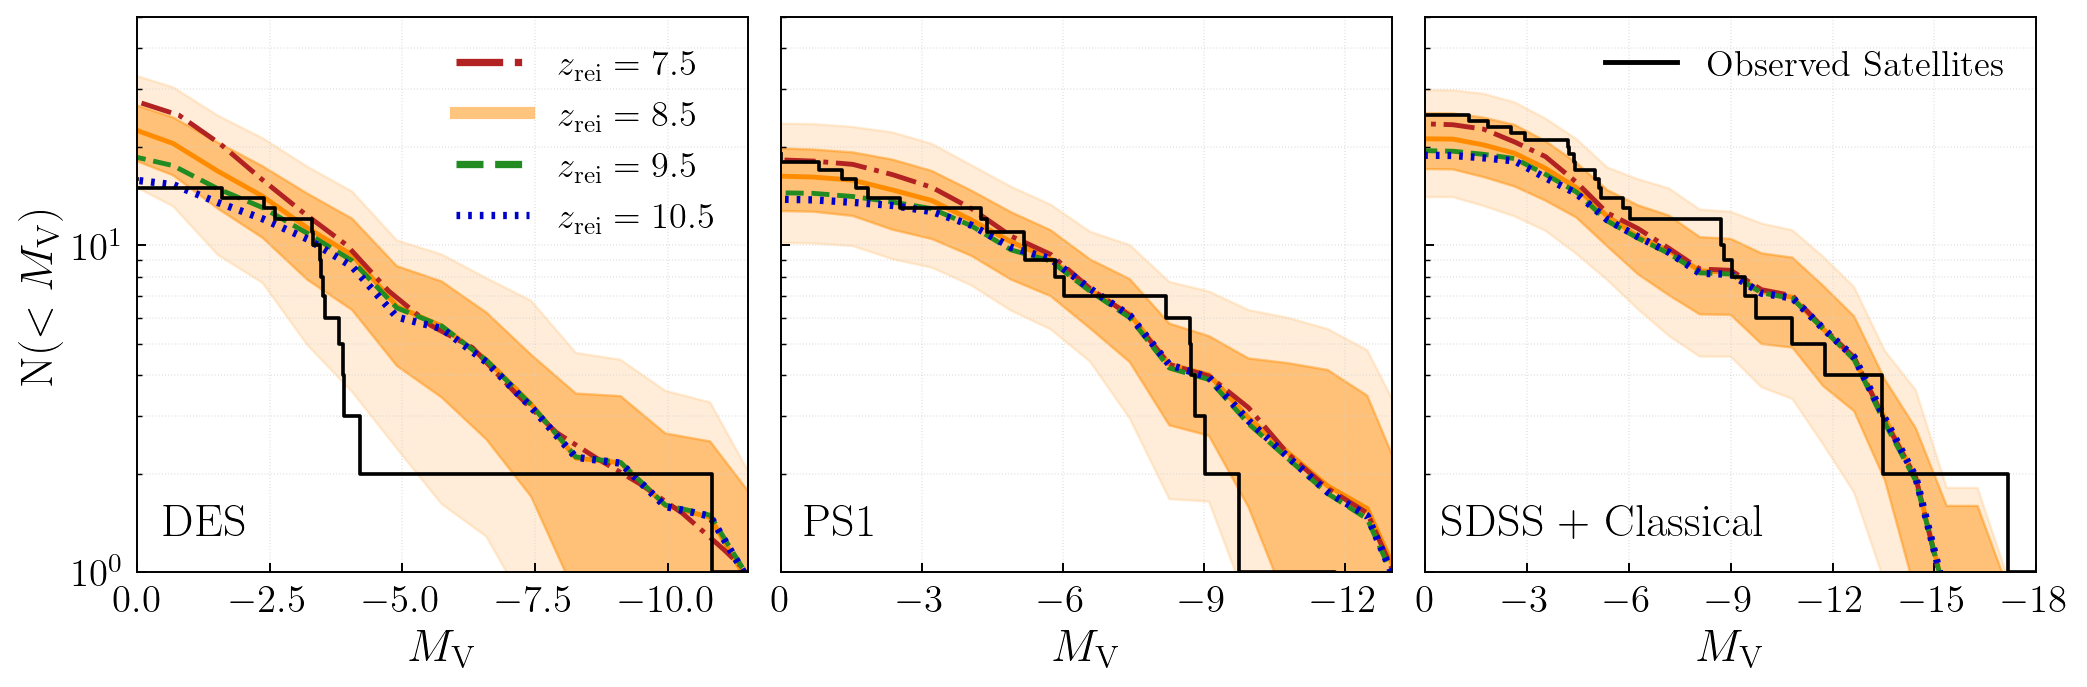

In [73]:
### 3x1 panel plot for luminosity function in surveys

fig,ax = plt.subplots(1,3,figsize = (12,4),sharey=True)

plt.subplots_adjust(wspace = 0.2)

plot_contours(ax=ax[0],xlims_plot = [0,-11.5],ylims_plot = [1,40],all_contours=des_z8_5_conts_lf,
                    xlabel = False, ylabel = False,grid = False,
                     fsize = 19,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[0],xlims_plot = [0,-12],ylims_plot = [1,40],all_contours=des_z7_5_conts_lf,
                    xlabel = False, ylabel = False,grid = False,
                     fsize = 19,mcol = "firebrick",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")

plot_contours(ax=ax[0],xlims_plot = [0,-12],ylims_plot = [1,40],all_contours=des_z9_5_conts_lf,
                    xlabel = False, ylabel = False,grid = False,
                     fsize = 19,mcol = "forestgreen",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "--",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")

plot_contours(ax=ax[0],xlims_plot = [0,-11.5],ylims_plot = [1,40],all_contours=des_z10_5_conts_lf,
                    xlabel = True, ylabel = True,grid = True,
                     fsize = 19,mcol = "mediumblue",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw = 3,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


###########################################

plot_contours(ax=ax[1],xlims_plot = [0,-13],ylims_plot = [1,40],all_contours=ps1_z8_5_conts_lf,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 19,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[1],xlims_plot = [0,-12],ylims_plot = [1,40],all_contours=ps1_z7_5_conts_lf,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 19,mcol = "firebrick",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "nolog")

plot_contours(ax=ax[1],xlims_plot = [0,-12],ylims_plot = [1,40],all_contours=ps1_z9_5_conts_lf,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 19,mcol = "forestgreen",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "--",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[1],xlims_plot = [0,-13],ylims_plot = [1,40],all_contours=ps1_z10_5_conts_lf,
                    xlabel = True, ylabel =False,grid = True,
                     fsize = 19,mcol = "mediumblue",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw = 3,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


###########################################


plot_contours(ax=ax[2],xlims_plot = [-1,-18],ylims_plot = [1,40],all_contours=sdss_z8_5_conts_lf,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 19,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")



plot_contours(ax=ax[2],xlims_plot = [0,-12],ylims_plot = [1,40],all_contours=sdss_z7_5_conts_lf,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 19,mcol = "firebrick",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")

plot_contours(ax=ax[2],xlims_plot = [0,-12],ylims_plot = [1,40],all_contours=sdss_z9_5_conts_lf,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 19,mcol = "forestgreen",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "--",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[2],xlims_plot = [0,-18],ylims_plot = [1,50],all_contours=sdss_z10_5_conts_lf,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 19,mcol = "mediumblue",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw = 3,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")

legend_elements = [Line2D([0], [0], color='firebrick', lw=3,ls = "-.",label=r'\rm $z_{\rm rei} = 7.5$',alpha = 1),
                   Line2D([0], [0], color='darkorange', lw=5,ls = "-", label=r'\rm $z_{\rm rei} = 8.5$',alpha = 0.5),
                    Line2D([0], [0], color='forestgreen', lw=3,ls = "--",label=r'\rm $z_{\rm rei} = 9.5$',alpha = 1),
                    Line2D([0], [0], color='mediumblue', lw=3,ls = "dotted",label=r'\rm $z_{\rm rei} = 10.5$',alpha = 1),
                      ]

ax[0].legend(frameon=False, fontsize = 15,loc = "upper right",handles = legend_elements,ncol=1)

legend_elements_2 = [Line2D([0], [0], color='k', lw=2,ls = "-",label=r'\rm Observed Satellites',alpha = 1),
                      ]

ax[2].legend(frameon=False, fontsize = 15,loc = "upper right",handles = legend_elements_2)

ax[1].plot(x_p_lf,y_p_lf,color = "k",lw = 1.5)


# for axi in ax:
#     for axii in axi:
ax[0].tick_params(axis = "x",labelsize = 16)
ax[0].tick_params(axis = "y",labelsize = 16)
ax[1].tick_params(axis = "x",labelsize = 16)
ax[1].tick_params(axis = "y",labelsize = 16)
ax[2].tick_params(axis = "x",labelsize = 16)
ax[2].tick_params(axis = "y",labelsize = 16)
    
ax[0].plot(x_d_lf,y_d_lf,color = "k",lw = 1.5)
ax[2].plot(x_sdss_lf,y_sdss_lf,color = "k",lw = 1.5)

ax[2].text( -0.5,1.3,r"\rm SDSS + Classical",size = 19,weight="bold")
ax[0].text( -0.5,1.3,r"\rm DES",size = 19,weight="bold")
ax[1].text( -0.5,1.3,r"\rm PS1",size = 19,weight="bold")

ax[1].set_xticks([0,-3,-6,-9,-12])
ax[2].set_xticks([0,-3,-6,-9,-12,-15,-18])

plt.tight_layout()
# plt.savefig("paper_figs_cater_pdf/all_lfs.pdf")

plt.show()



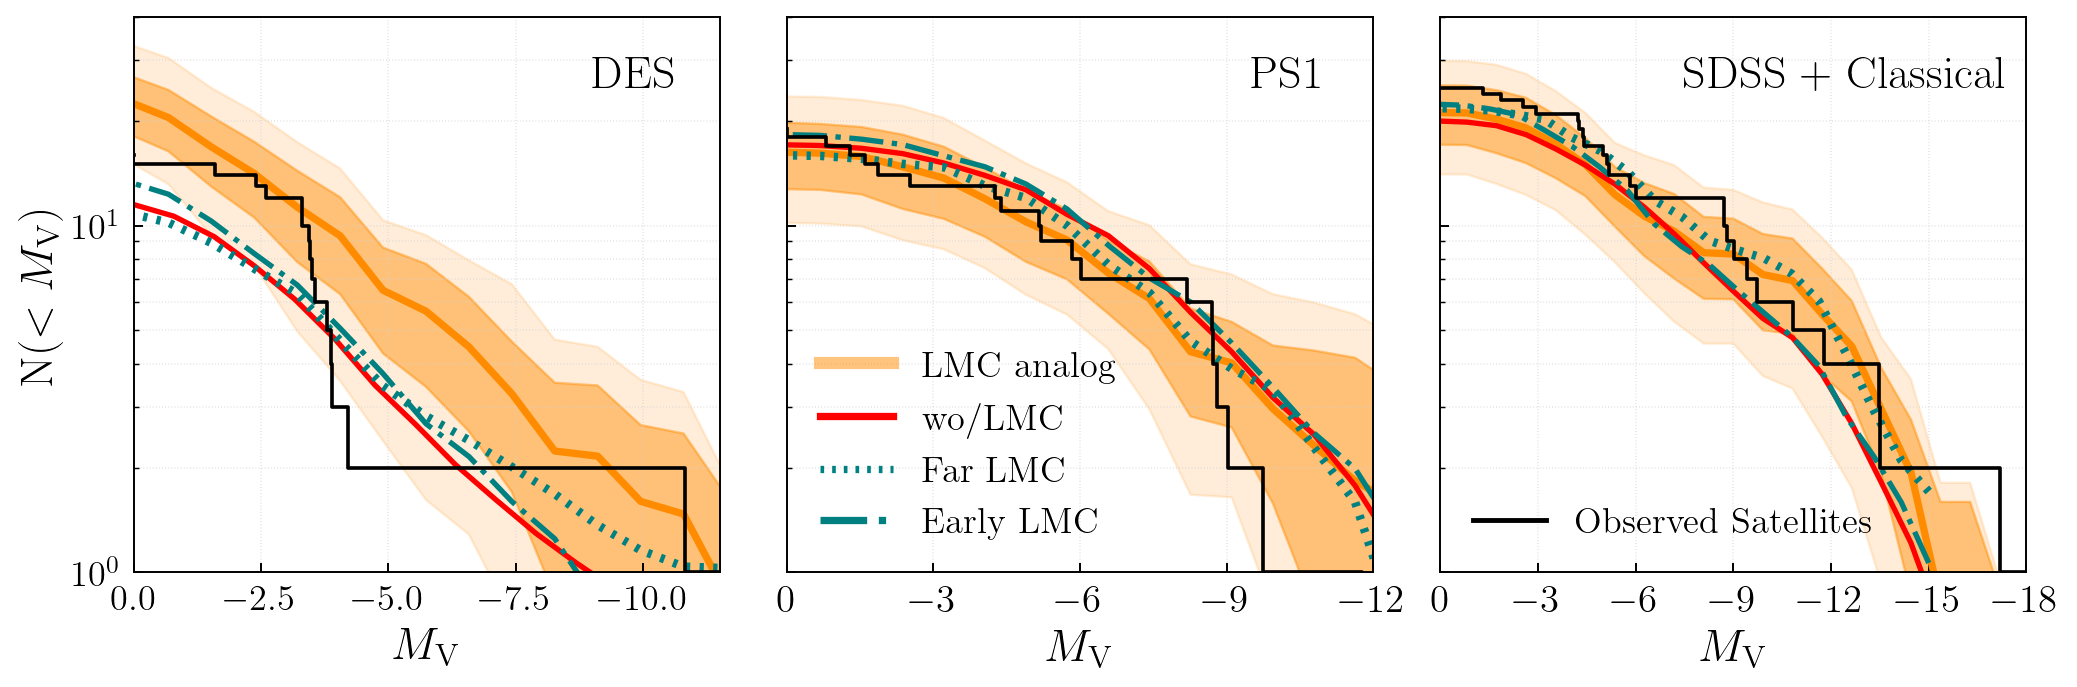

In [74]:
### 3x1 LF plot for effect of LMC

### THIS IS DES LF

fig,ax = plt.subplots(1,3,figsize = (12,4),sharey=True)

plt.subplots_adjust(wspace = 0.2)

plot_contours(ax=ax[0],xlims_plot = [0,-11],ylims_plot = [1,40],all_contours=des_z8_5_conts_lf,
                    xlabel = True, ylabel = True,grid = True,
                     fsize = 19,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=3,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[0],xlims_plot = [0,-11.5],ylims_plot = [1,40],all_contours=des_z8_5_nolmc_conts_lf,
                    xlabel = True, ylabel = True,grid = False,
                     fsize = 19,mcol = "r",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2.2,ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=False,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[0],xlims_plot = [0,-11.5],ylims_plot = [1,40],all_contours=des_z8_5_far_lmc_conts_lf,
                    xlabel = True, ylabel = True,grid = False,
                     fsize = 19,mcol = "teal",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=3.5,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=False,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[0],xlims_plot = [0,-11.5],ylims_plot = [1,40],all_contours=des_z8_5_early_lmc_conts_lf,
                    xlabel = True, ylabel = True,grid = False,
                     fsize = 19,mcol = "teal",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2.2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=False,noshade_lw = 1,yscale = "log")

                   

ax[0].plot(x_d_lf,y_d_lf,color = "k",lw = 1.5)
ax[0].tick_params(axis = "x",labelsize = 15)
ax[0].tick_params(axis = "y",labelsize = 15)


plot_contours(ax=ax[1],xlims_plot = [0,-12],ylims_plot = [1,40],all_contours=ps1_z8_5_conts_lf,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 19,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=3,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")

plot_contours(ax=ax[1],xlims_plot = [0,-13],ylims_plot = [1,40],all_contours=ps1_z8_5_nolmc_conts_lf,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 19,mcol = "r",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2.2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=False,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[1],xlims_plot = [0,-11.5],ylims_plot = [1,40],all_contours=ps1_z8_5_far_lmc_conts_lf,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 19,mcol = "teal",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=3.5,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=False,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[1],xlims_plot = [0,-11.5],ylims_plot = [1,40],all_contours=ps1_z8_5_early_lmc_conts_lf,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 19,mcol = "teal",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2.2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=False,noshade_lw = 1,yscale = "log")


      
plot_contours(ax=ax[2],xlims_plot = [0,-19],ylims_plot = [1,40],all_contours=sdss_z8_5_conts_lf,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 19,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=3,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")

plot_contours(ax=ax[2],xlims_plot = [0,-19],ylims_plot = [1,40],all_contours=sdss_z8_5_nolmc_conts_lf,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 19,mcol = "r",sig1 =False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2.2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=False,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[2],xlims_plot = [0,-11.5],ylims_plot = [1,40],all_contours=sdss_z8_5_far_lmc_conts_lf,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 19,mcol = "teal",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=3.5,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=False,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[2],xlims_plot = [0,-11.5],ylims_plot = [1,40],all_contours=sdss_z8_5_early_lmc_conts_lf,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 19,mcol = "teal",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2.2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=False,noshade_lw = 1,yscale = "log")


legend_elements = [Line2D([0], [0], color='darkorange', lw=5, label=r'\rm LMC analog',alpha = 0.5),
                    Line2D([0], [0], color='r', lw=3,ls = "-",label=r'\rm wo/LMC',alpha = 1),
                   Line2D([0], [0], color='teal', lw=3 , ls= "dotted",label=r'\rm Far LMC'),
                   Line2D([0], [0], color='teal', lw=3 , ls= "-.",label=r'\rm Early LMC')
                  
                  ]

ax[1].legend(frameon=False, fontsize = 15,loc = "lower left",handles = legend_elements)

legend_elements = [Line2D([0], [0], color='k', lw=2,ls = "-",label=r'\rm Observed Satellites',alpha = 1),
                      ]

ax[2].legend(frameon=False, fontsize = 15,loc = "lower left",handles = legend_elements)

ax[1].plot(x_p_lf,y_p_lf,color = "k",lw = 1.5)

ax[2].plot(x_sdss_lf,y_sdss_lf,color = "k",lw = 1.5)

ax[2].text( -7.5,25,r"\rm SDSS + Classical",size = 19,weight="bold")
ax[0].text( -9,25,r"\rm DES",size = 19,weight="bold")
ax[1].text( -9.5,25,r"\rm PS1",size = 19,weight="bold")


ax[1].set_xticks([0,-3,-6,-9,-12])
ax[2].set_xticks([0,-3,-6,-9,-12,-15,-18])



ax[1].tick_params(axis = "x",labelsize = 16)
ax[1].tick_params(axis = "y",labelsize = 16)
ax[2].tick_params(axis = "x",labelsize = 16)
ax[2].tick_params(axis = "y",labelsize = 16)



plt.tight_layout()
# plt.savefig("paper_figs_cater_pdf/lmc_nolmc_lf.pdf")

plt.show()




## B) Radial Distribution plots

In [75]:
### are radial distributions sensitive to reionization? Normalization == True, This is only for DES

des_z10_5_conts_rad_n = get_contours(xindi_ALL = des_z10_5_lmc_vasi['heli_all'],all_halo_masses=des_z10_5_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True,sig3=True)

des_z7_5_conts_rad_n = get_contours(xindi_ALL = des_z7_5_lmc_vasi['heli_all'],all_halo_masses=des_z7_5_lmc_vasi['all_menc100'],
                                        nbins=20,xlog=False,grid_range = [0,300],norm=True,sig3=True)

des_z8_5_conts_rad_n = get_contours(xindi_ALL = des_z8_5_lmc_vasi['heli_all'],all_halo_masses=des_z8_5_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True,sig3=True)

des_z9_5_conts_rad_n = get_contours(xindi_ALL = des_z9_5_lmc_vasi['heli_all'],all_halo_masses=des_z9_5_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True,sig3=True)



# ############

ps1_z10_5_conts_rad_n = get_contours(xindi_ALL = ps1_z10_5_lmc_vasi['heli_all'],all_halo_masses=ps1_z10_5_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True,sig3=True)

ps1_z7_5_conts_rad_n = get_contours(xindi_ALL = ps1_z7_5_lmc_vasi['heli_all'],all_halo_masses=ps1_z7_5_lmc_vasi['all_menc100'],
                                        nbins=20,xlog=False,grid_range = [0,300],norm=True,sig3=True)

ps1_z8_5_conts_rad_n = get_contours(xindi_ALL = ps1_z8_5_lmc_vasi['heli_all'],all_halo_masses=ps1_z8_5_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True,sig3=True)

ps1_z9_5_conts_rad_n = get_contours(xindi_ALL = ps1_z9_5_lmc_vasi['heli_all'],all_halo_masses=ps1_z9_5_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True,sig3=True)



# ###########

sdss_z10_5_conts_rad_n = get_contours(xindi_ALL = sdss_z10_5_lmc_vasi['heli_all'],all_halo_masses=sdss_z10_5_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True,sig3=True)

sdss_z7_5_conts_rad_n = get_contours(xindi_ALL = sdss_z7_5_lmc_vasi['heli_all'],all_halo_masses=sdss_z7_5_lmc_vasi['all_menc100'],
                                        nbins=20,xlog=False,grid_range = [0,300],norm=True,sig3=True)

sdss_z8_5_conts_rad_n = get_contours(xindi_ALL = sdss_z8_5_lmc_vasi['heli_all'],all_halo_masses=sdss_z8_5_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True,sig3=True)

sdss_z9_5_conts_rad_n = get_contours(xindi_ALL = sdss_z9_5_lmc_vasi['heli_all'],all_halo_masses=sdss_z9_5_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True,sig3=True)



--- 0.16726136207580566 seconds ---
--- 0.14073705673217773 seconds ---
--- 0.1421220302581787 seconds ---
--- 0.15623903274536133 seconds ---
--- 0.14505290985107422 seconds ---
--- 0.16349387168884277 seconds ---
--- 0.14620327949523926 seconds ---
--- 0.1516890525817871 seconds ---
--- 0.1638638973236084 seconds ---
--- 0.1680769920349121 seconds ---
--- 0.16404032707214355 seconds ---
--- 0.18294000625610352 seconds ---


In [77]:
des_z8_5_far_lmc_conts_rad_n = get_contours(xindi_ALL = des_z8_5_far_lmc_vasi['heli_all'],all_halo_masses=des_z8_5_far_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True)


ps1_z8_5_far_lmc_conts_rad_n = get_contours(xindi_ALL = ps1_z8_5_far_lmc_vasi['heli_all'],all_halo_masses=ps1_z8_5_far_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True)


sdss_z8_5_far_lmc_conts_rad_n = get_contours(xindi_ALL = sdss_z8_5_far_lmc_vasi['heli_all'],all_halo_masses=sdss_z8_5_far_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True)


###############

des_z8_5_early_lmc_conts_rad_n = get_contours(xindi_ALL = des_z8_5_early_lmc_vasi['heli_all'],all_halo_masses=des_z8_5_early_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True)


ps1_z8_5_early_lmc_conts_rad_n = get_contours(xindi_ALL = ps1_z8_5_early_vasi['heli_all'],all_halo_masses=ps1_z8_5_early_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True)


sdss_z8_5_early_lmc_conts_rad_n = get_contours(xindi_ALL = sdss_z8_5_early_vasi['heli_all'],all_halo_masses=sdss_z8_5_early_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True)


#################

des_z8_5_nolmc_conts_rad_n = get_contours(xindi_ALL = des_z8_5_nolmc_vasi['heli_all'],all_halo_masses=des_z8_5_nolmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True)

ps1_z8_5_nolmc_conts_rad_n = get_contours(xindi_ALL = ps1_z8_5_nolmc_vasi['heli_all'],all_halo_masses=ps1_z8_5_nolmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True)

sdss_z8_5_nolmc_conts_rad_n = get_contours(xindi_ALL = sdss_z8_5_nolmc_vasi['heli_all'],all_halo_masses=sdss_z8_5_nolmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True)


######################



--- 0.25542211532592773 seconds ---
--- 0.3057122230529785 seconds ---
--- 0.34379005432128906 seconds ---
--- 0.7045450210571289 seconds ---
--- 0.7049589157104492 seconds ---
--- 0.6897411346435547 seconds ---
--- 1.204599142074585 seconds ---
--- 1.1708250045776367 seconds ---
--- 1.100477933883667 seconds ---


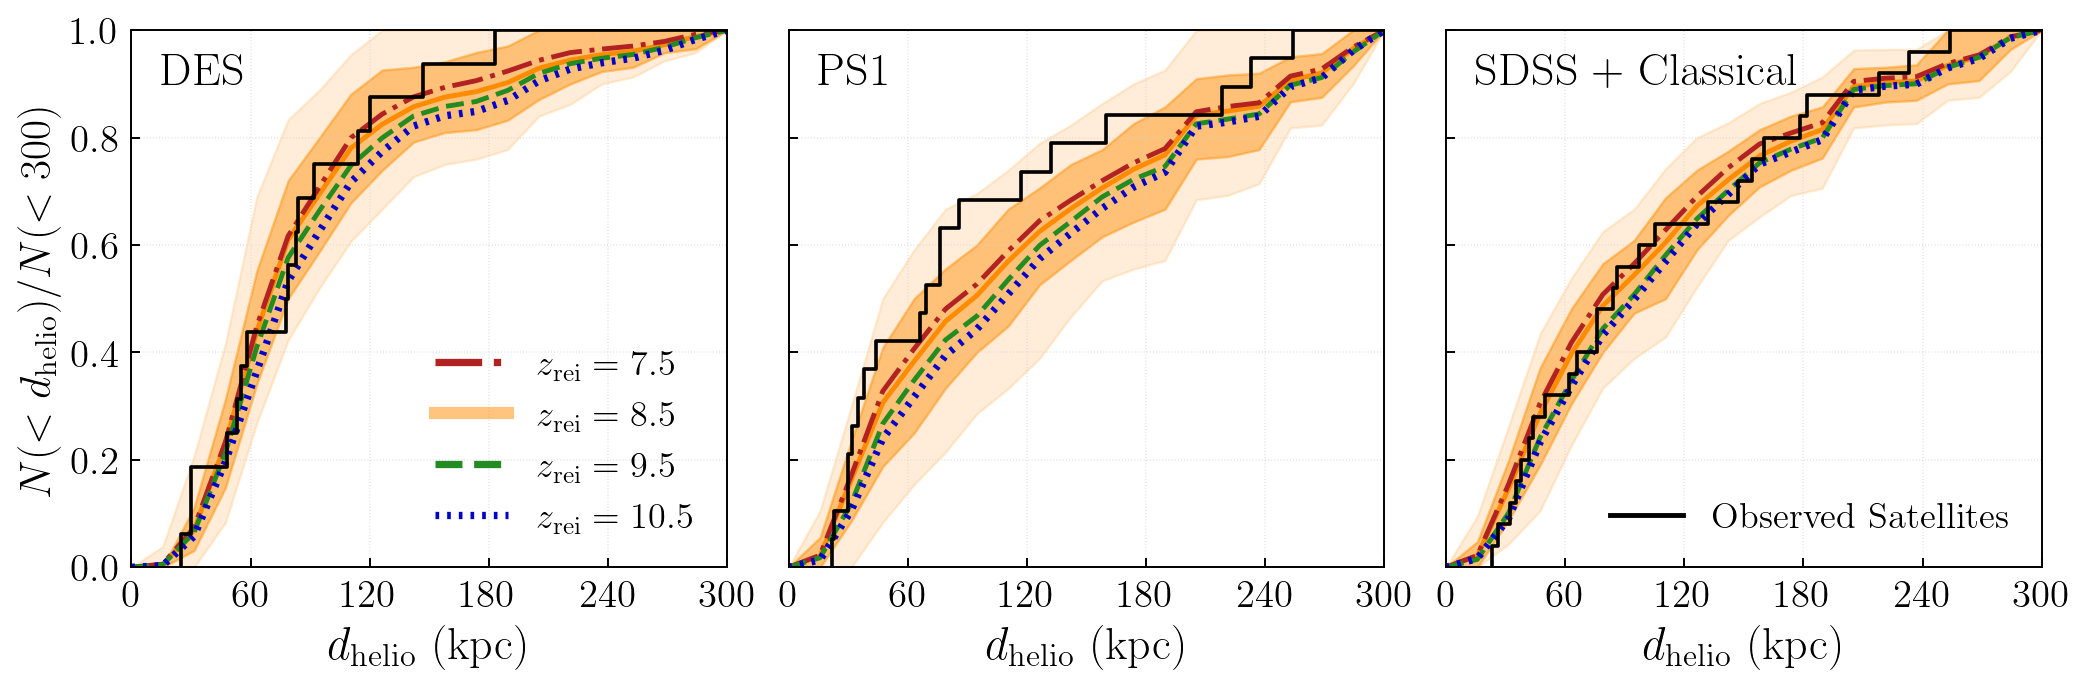

In [76]:

fig,ax = plt.subplots(1,3,figsize = (12,4),sharey=True)

plt.subplots_adjust(wspace = 0.2)

plot_contours(ax=ax[0],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=des_z8_5_conts_rad_n,
                    xlabel = False, ylabel = False,grid = False,
                     fsize = 14,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$[kpc]",med_lw=2,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=True,noshade_lw = 1,yscale = "nolog")


plot_contours(ax=ax[0],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=des_z7_5_conts_rad_n,
                    xlabel = False, ylabel = False,grid = False,
                     fsize = 14,mcol = "firebrick",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$[kpc]",med_lw=2,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=True,noshade_lw = 1,yscale = "nolog")

plot_contours(ax=ax[0],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=des_z9_5_conts_rad_n,
                    xlabel = False, ylabel = False,grid = False,
                     fsize = 14,mcol = "forestgreen",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "--",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$[kpc]",med_lw=2,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=True,noshade_lw = 1,yscale = "nolog")

plot_contours(ax=ax[0],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=des_z10_5_conts_rad_n,
                    xlabel = True, ylabel = True,grid = True,
                     fsize = 19,mcol = "mediumblue",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$ (kpc)",med_lw = 3,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=True,noshade_lw = 1,yscale = "nolog")


###########################################

plot_contours(ax=ax[1],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=ps1_z8_5_conts_rad_n,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 14,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$[kpc]",med_lw=2,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=True,noshade_lw = 1,yscale = "nolog")


plot_contours(ax=ax[1],xlims_plot =[0,300],ylims_plot = [0,1],all_contours=ps1_z7_5_conts_rad_n,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 14,mcol = "firebrick",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$[kpc]",med_lw=2,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=True,noshade_lw = 1,yscale = "nolog")

plot_contours(ax=ax[1],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=ps1_z9_5_conts_rad_n,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 14,mcol = "forestgreen",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "--",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$[kpc]",med_lw=2,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=True,noshade_lw = 1,yscale = "nolog")


plot_contours(ax=ax[1],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=ps1_z10_5_conts_rad_n,
                    xlabel = True, ylabel =False,grid = True,
                     fsize = 19,mcol = "mediumblue",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$ (kpc)",med_lw = 3,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=True,noshade_lw = 1,yscale = "nolog")


###########################################


plot_contours(ax=ax[2],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=sdss_z8_5_conts_rad_n,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 14,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt =r"\rm $d_{\rm helio}$ (kpc)",med_lw=2,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=True,noshade_lw = 1,yscale = "nolog")



plot_contours(ax=ax[2],xlims_plot =[0,300],ylims_plot = [0,1],all_contours=sdss_z7_5_conts_rad_n,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 14,mcol = "firebrick",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$[kpc]",med_lw=2,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=True,noshade_lw = 1,yscale = "nolog")

plot_contours(ax=ax[2],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=sdss_z9_5_conts_rad_n,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 14,mcol = "forestgreen",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "--",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$[kpc]",med_lw=2,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=True,noshade_lw = 1,yscale = "nolog")


plot_contours(ax=ax[2],xlims_plot =[0,300],ylims_plot = [0,1],all_contours=sdss_z10_5_conts_rad_n,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 19,mcol = "mediumblue",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt =r"\rm $d_{\rm helio}$ (kpc)",med_lw = 3,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=True,noshade_lw = 1,yscale = "nolog")



legend_elements = [Line2D([0], [0], color='firebrick', lw=3,ls = "-.",label=r'\rm $z_{\rm rei} = 7.5$',alpha = 1),
                   Line2D([0], [0], color='darkorange', lw=5,ls = "-", label=r'\rm $z_{\rm rei} = 8.5$',alpha = 0.5),
                    Line2D([0], [0], color='forestgreen', lw=3,ls = "--",label=r'\rm $z_{\rm rei} = 9.5$',alpha = 1),
                    Line2D([0], [0], color='mediumblue', lw=3,ls = "dotted",label=r'\rm $z_{\rm rei} = 10.5$',alpha = 1),
                      ]

ax[0].legend(frameon=False, fontsize = 15,loc = "lower right",handles = legend_elements,ncol=1)

legend_elements_2 = [Line2D([0], [0], color='k', lw=2,ls = "-",label=r'\rm Observed Satellites',alpha = 1),
                      ]

ax[2].legend(frameon=False, fontsize = 15,loc = "lower right",handles = legend_elements_2)


ax[0].set_ylabel(r"\rm $N( < d_{\rm helio})$/$N(< 300)$",fontsize = 18)

ax[0].tick_params(axis = "x",labelsize = 16)
ax[0].tick_params(axis = "y",labelsize = 16)
ax[1].tick_params(axis = "x",labelsize = 16)
ax[1].tick_params(axis = "y",labelsize = 16)

ax[2].tick_params(axis = "x",labelsize = 16)
ax[2].tick_params(axis = "y",labelsize = 16)
    
ax[0].plot(x_d_h,y_d_h/np.max(y_d_h),color = "k",lw = 1.5)
ax[2].plot(x_sdss_h,y_sdss_h/np.max(y_sdss_h),color = "k",lw = 1.5)
ax[1].plot(x_p_h,y_p_h/np.max(y_p_h),color = "k",lw = 1.5)

# ax[2].set_xticks([0,50,100,150,200,250,300])
# ax[1].set_xticks([0,50,100,150,200,250,300])
# ax[0].set_xticks([0,50,100,150,200,250,300])


ax[2].set_xticks([0,60,120,180,240,300])
ax[1].set_xticks([0,60,120,180,240,300])
ax[0].set_xticks([0,60,120,180,240,300])


ax[2].text(15,0.9,r"\rm SDSS + Classical",size = 19,weight = 'bold')
ax[0].text(15,0.9,r"\rm DES",size = 19,weight="bold")
ax[1].text(15,0.9,r"\rm PS1",size = 19,weight="bold")

plt.tight_layout()
# plt.savefig("paper_figs_cater_pdf/all_radials_norm.pdf")

plt.show()

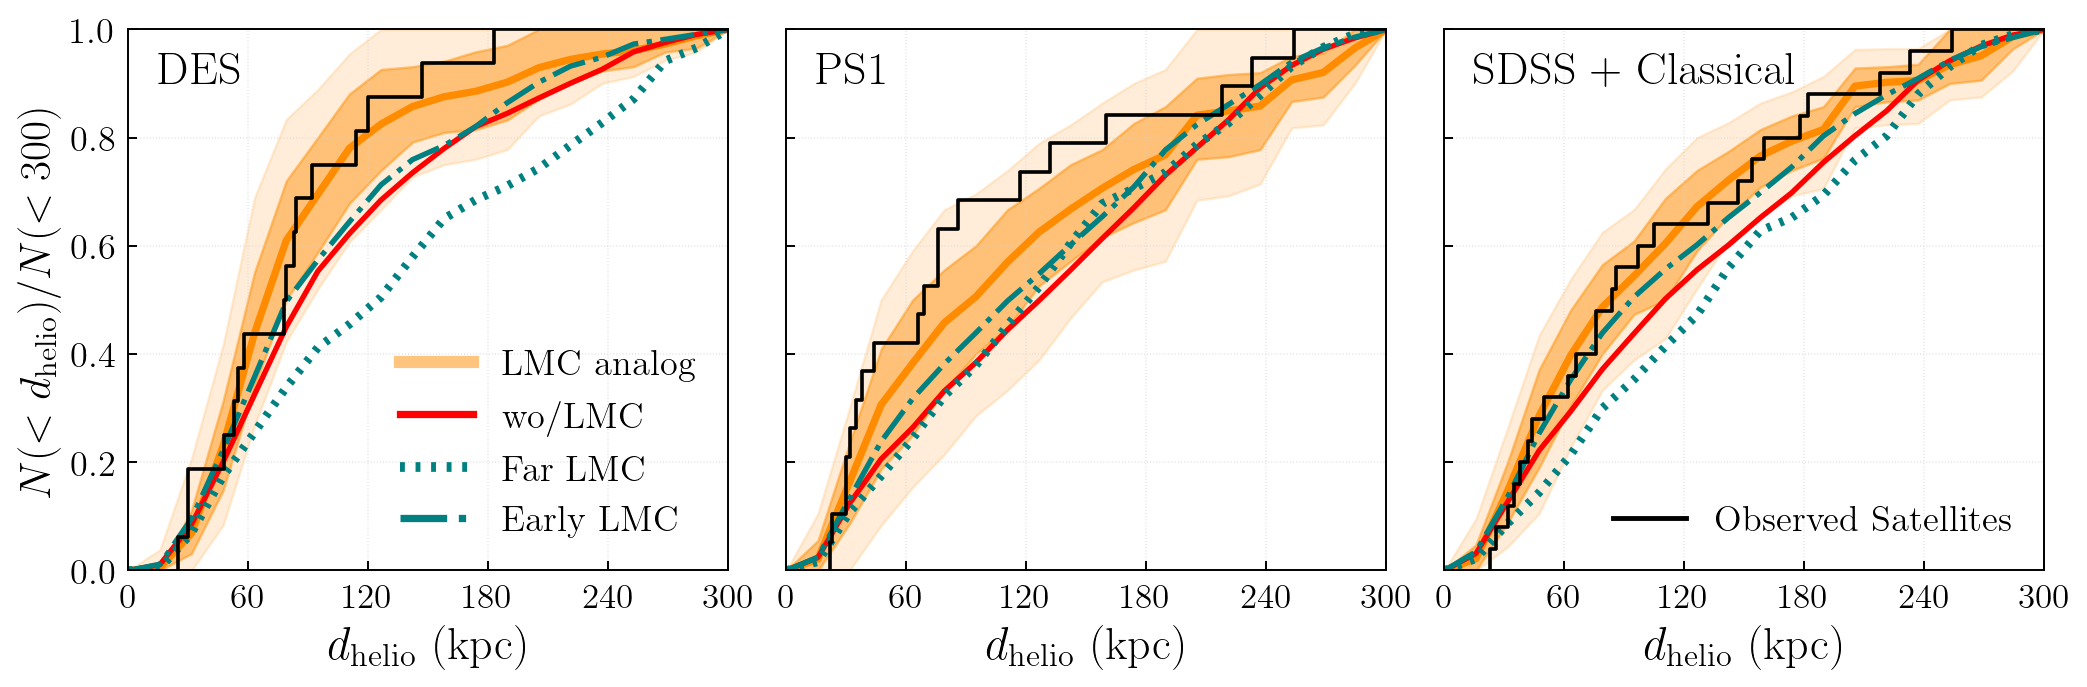

In [78]:
fig,ax = plt.subplots(1,3,figsize = (12,4),sharey=True)

plt.subplots_adjust(wspace = 0.2)

plot_contours(ax=ax[0],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=des_z8_5_conts_rad_n,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 14,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=3,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "nolog")

plot_contours(ax=ax[0],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=des_z8_5_nolmc_conts_rad_n,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 14,mcol = "r",sig1 =False,sig2 =False,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$ (kpc)",med_lw=2.2,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=False,noshade_lw = 1,yscale = "nolog")


plot_contours(ax=ax[0],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=des_z8_5_far_lmc_conts_rad_n,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 14,mcol = "teal",sig1 = False,sig2 =False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$ (kpc)",med_lw=3.5,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=False,noshade_lw = 1,yscale = "nolog")


plot_contours(ax=ax[0],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=des_z8_5_early_lmc_conts_rad_n,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 19,mcol = "teal",sig1 = False,sig2 =False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$ (kpc)",med_lw=2.2,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=False,noshade_lw = 1,yscale = "nolog")





###########################################

plot_contours(ax=ax[1],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=ps1_z8_5_conts_rad_n,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 14,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=3,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "nolog")

plot_contours(ax=ax[1],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=ps1_z8_5_nolmc_conts_rad_n,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 14,mcol = "r",sig1 = False,sig2 =False,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$ (kpc)",med_lw=2.2,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=False,noshade_lw = 1,yscale = "nolog")


plot_contours(ax=ax[1],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=ps1_z8_5_far_lmc_conts_rad_n,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 14,mcol = "teal",sig1 = False,sig2 =False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$ (kpc)",med_lw=3.5,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=False,noshade_lw = 1,yscale = "nolog")


plot_contours(ax=ax[1],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=ps1_z8_5_early_lmc_conts_rad_n,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 19,mcol = "teal",sig1 = False,sig2 =False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$ (kpc)",med_lw=2.2,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=False,noshade_lw = 1,yscale = "nolog")



###########################################


plot_contours(ax=ax[2],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=sdss_z8_5_conts_rad_n,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 14,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=3,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "nolog")

plot_contours(ax=ax[2],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=sdss_z8_5_nolmc_conts_rad_n,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 14,mcol = "r",sig1 = False,sig2 =False,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$ (kpc)",med_lw=2.2,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=False,noshade_lw = 1,yscale = "nolog")


plot_contours(ax=ax[2],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=sdss_z8_5_far_lmc_conts_rad_n,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 14,mcol = "teal",sig1 = False,sig2 =False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$ (kpc)",med_lw=3.5,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=False,noshade_lw = 1,yscale = "nolog")


plot_contours(ax=ax[2],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=sdss_z8_5_early_lmc_conts_rad_n,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 19,mcol = "teal",sig1 = False,sig2 =False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$ (kpc)",med_lw=2.2,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=False,noshade_lw = 1,yscale = "nolog")



legend_elements = [Line2D([0], [0], color='darkorange', lw=5, label=r'\rm LMC analog',alpha = 0.5),
                    Line2D([0], [0], color='r', lw=3,ls = "-",label=r'\rm wo/LMC',alpha = 1),
                   Line2D([0], [0], color='teal', lw=4 , ls= "dotted",label=r'\rm Far LMC'),
                   Line2D([0], [0], color='teal', lw=3 , ls= "-.",label=r'\rm Early LMC')
                  
                  ]


ax[0].legend(frameon=False, fontsize = 15,loc = "lower right",handles = legend_elements,ncol=1)

legend_elements_2 = [Line2D([0], [0], color='k', lw=2,ls = "-",label=r'\rm Observed Satellites',alpha = 1),
                      ]

ax[2].legend(frameon=False, fontsize = 15,loc = "lower right",handles = legend_elements_2)


ax[0].tick_params(axis = "x",labelsize = 14.5)
ax[0].tick_params(axis = "y",labelsize = 15)
ax[1].tick_params(axis = "x",labelsize = 14.5)
ax[1].tick_params(axis = "y",labelsize = 15)

ax[2].tick_params(axis = "x",labelsize = 14.5)
ax[2].tick_params(axis = "y",labelsize = 15)
    
ax[0].plot(x_d_h,y_d_h/np.max(y_d_h),color = "k",lw = 1.5)
ax[2].plot(x_sdss_h,y_sdss_h/np.max(y_sdss_h),color = "k",lw = 1.5)
ax[1].plot(x_p_h,y_p_h/np.max(y_p_h),color = "k",lw = 1.5)

# ax[2].set_xticks([0,50,100,150,200,250,300])
# ax[1].set_xticks([0,50,100,150,200,250,300])
# ax[0].set_xticks([0,50,100,150,200,250,300])


ax[2].set_xticks([0,60,120,180,240,300])
ax[1].set_xticks([0,60,120,180,240,300])
ax[0].set_xticks([0,60,120,180,240,300])

ax[0].set_ylabel(r"\rm $N( < d_{\rm helio})$/$N(< 300)$",fontsize = 18)

ax[2].text(15,0.9,r"\rm SDSS + Classical",size = 19,weight = 'bold')
ax[0].text(15,0.9,r"\rm DES",size = 19,weight="bold")
ax[1].text(15,0.9,r"\rm PS1",size = 19,weight="bold")

plt.tight_layout()
# plt.savefig("paper_figs_cater_pdf/lmc_nolmc_rads_norm.pdf")


plt.show()


In [102]:
from scipy.interpolate import UnivariateSpline
from scipy import stats


# xrads = sdss_z8_5_nolmc_conts_rad_n[0]
# yrads_med = sdss_z8_5_nolmc_conts_rad_n[1]

# xrads = sdss_z8_5_far_lmc_conts_rad_n[0]
# yrads_med = sdss_z8_5_far_lmc_conts_rad_n[1]

# xrads = sdss_z8_5_early_lmc_conts_rad_n[0]
# yrads_med = sdss_z8_5_early_lmc_conts_rad_n[1]

# xrads = sdss_z10_5_conts_rad_n[0]
# yrads_med = sdss_z10_5_conts_rad_n[1]



def get_ks_val(model_vals,act_vals,plot=False):
    
    xrads = model_vals[0]
    yrads_med = model_vals[1]
    spl_med = UnivariateSpline(xrads,yrads_med,s=0.)

    xuni = np.linspace(0,300,100)
#     if plot == True:
#         plt.figure(figsize = (2,2))
#         plt.plot(x_sdss_h, y_sdss_h/np.max(y_sdss_h),color = "k",lw = 1.5)
#         plt.plot(xrads,yrads_med,color = "darkorange",ls = "-",lw = 2)
#         plt.plot(xuni,spl_med(xuni),color = "k",ls = "--")
#         plt.grid(ls = ":")
#         plt.show()
    #run the kstest now
    # sdss_class_heliods
    # stats.kstest(mw_ps1_heliods,spl_med)
    vals=stats.kstest(act_vals,spl_med)
    return vals.pvalue
    


In [103]:
print("SDSS, LMC, zrei=7.5 ->",get_ks_val(sdss_z7_5_conts_rad_n,sdss_class_heliods))
print("SDSS, LMC, zrei=8.5 ->",get_ks_val(sdss_z8_5_conts_rad_n,sdss_class_heliods))
print("SDSS, LMC, zrei=9.5 ->",get_ks_val(sdss_z9_5_conts_rad_n,sdss_class_heliods))
print("SDSS, LMC, zrei=10.5 ->",get_ks_val(sdss_z10_5_conts_rad_n,sdss_class_heliods))

print("SDSS, w/o LMC, zrei=8.5 ->",get_ks_val(sdss_z8_5_nolmc_conts_rad_n,sdss_class_heliods))
print("SDSS, far LMC, zrei=8.5 ->",get_ks_val(sdss_z8_5_far_lmc_conts_rad_n,sdss_class_heliods))
print("SDSS, early LMC, zrei=8.5 ->",get_ks_val(sdss_z8_5_early_lmc_conts_rad_n,sdss_class_heliods))

print("--"*20)

print("DES, LMC, zrei=7.5 ->",get_ks_val(des_z7_5_conts_rad_n,mw_des_heliods))
print("DES, LMC, zrei=8.5 ->",get_ks_val(des_z8_5_conts_rad_n,mw_des_heliods,plot=True))
print("DES, LMC, zrei=9.5 ->",get_ks_val(des_z9_5_conts_rad_n,mw_des_heliods))
print("DES, LMC, zrei=10.5 ->",get_ks_val(des_z10_5_conts_rad_n,mw_des_heliods))

print("DES, w/o LMC, zrei=8.5 ->",get_ks_val(des_z8_5_nolmc_conts_rad_n,mw_des_heliods))
print("DES, far LMC, zrei=8.5 ->",get_ks_val(des_z8_5_far_lmc_conts_rad_n,mw_des_heliods))
print("DES, early LMC, zrei=8.5 ->",get_ks_val(des_z8_5_early_lmc_conts_rad_n,mw_des_heliods))

print("--"*20)

print("PS1, LMC, zrei=7.5 ->",get_ks_val(ps1_z7_5_conts_rad_n,mw_ps1_heliods))
print("PS1, LMC, zrei=8.5 ->",get_ks_val(ps1_z8_5_conts_rad_n,mw_ps1_heliods))
print("PS1, LMC, zrei=9.5 ->",get_ks_val(ps1_z9_5_conts_rad_n,mw_ps1_heliods))
print("PS1, LMC, zrei=10.5 ->",get_ks_val(ps1_z10_5_conts_rad_n,mw_ps1_heliods))

print("PS1, w/o LMC, zrei=8.5 ->",get_ks_val(ps1_z8_5_nolmc_conts_rad_n,mw_ps1_heliods))
print("PS1, far LMC, zrei=8.5 ->",get_ks_val(ps1_z8_5_far_lmc_conts_rad_n,mw_ps1_heliods))
print("PS1, early LMC, zrei=8.5 ->",get_ks_val(ps1_z8_5_early_lmc_conts_rad_n,mw_ps1_heliods))


SDSS, LMC, zrei=7.5 -> 0.9655801154023135
SDSS, LMC, zrei=8.5 -> 0.991610273517617
SDSS, LMC, zrei=9.5 -> 0.9504571718409063
SDSS, LMC, zrei=10.5 -> 0.929673617943114
SDSS, w/o LMC, zrei=8.5 -> 0.49656323671541447
SDSS, far LMC, zrei=8.5 -> 0.07868839428486174
SDSS, early LMC, zrei=8.5 -> 0.9262718772022784
----------------------------------------
DES, LMC, zrei=7.5 -> 0.6702625268989888
DES, LMC, zrei=8.5 -> 0.7186686132326807
DES, LMC, zrei=9.5 -> 0.9060364418525693
DES, LMC, zrei=10.5 -> 0.8613027023099149
DES, w/o LMC, zrei=8.5 -> 0.39704963402811877
DES, far LMC, zrei=8.5 -> 0.009760483765934302
DES, early LMC, zrei=8.5 -> 0.5610920713679435
----------------------------------------
PS1, LMC, zrei=7.5 -> 0.504050082608473
PS1, LMC, zrei=8.5 -> 0.3602530832637433
PS1, LMC, zrei=9.5 -> 0.19035935554225536
PS1, LMC, zrei=10.5 -> 0.11099920422242981
PS1, w/o LMC, zrei=8.5 -> 0.02528929419707715
PS1, far LMC, zrei=8.5 -> 0.020407122469415562
PS1, early LMC, zrei=8.5 -> 0.088814817903309

## C) Size Distribution plots

In [124]:
## size distribution plots for SDSS

sdss_z10_5_conts_r12_n = get_contours(xindi_ALL = sdss_z10_5_lmc_vasi['r12_all'],all_halo_masses=sdss_z10_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=True,grid_range = [np.log10(8),np.log10(5000)],norm=True)

sdss_z7_5_conts_r12_n = get_contours(xindi_ALL = sdss_z7_5_lmc_vasi['r12_all'],all_halo_masses=sdss_z7_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=True,grid_range = [np.log10(8),np.log10(5000)],norm=True)

sdss_z8_5_conts_r12_n = get_contours(xindi_ALL = sdss_z8_5_lmc_vasi['r12_all'],all_halo_masses=sdss_z8_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=True,grid_range = [np.log10(8),np.log10(5000)],norm=True)

sdss_z9_5_conts_r12_n = get_contours(xindi_ALL = sdss_z9_5_lmc_vasi['r12_all'],all_halo_masses=sdss_z9_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=True,grid_range = [np.log10(8),np.log10(5000)],norm=True)

###

des_z10_5_conts_r12_n = get_contours(xindi_ALL = des_z10_5_lmc_vasi['r12_all'],all_halo_masses=des_z10_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=True,grid_range = [np.log10(8),np.log10(5000)],norm=True)

des_z7_5_conts_r12_n = get_contours(xindi_ALL = des_z7_5_lmc_vasi['r12_all'],all_halo_masses=des_z7_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=True,grid_range = [np.log10(8),np.log10(5000)],norm=True)

des_z8_5_conts_r12_n = get_contours(xindi_ALL = des_z8_5_lmc_vasi['r12_all'],all_halo_masses=des_z8_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=True,grid_range = [np.log10(8),np.log10(5000)],norm=True)

des_z9_5_conts_r12_n = get_contours(xindi_ALL = des_z9_5_lmc_vasi['r12_all'],all_halo_masses=des_z9_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=True,grid_range = [np.log10(8),np.log10(5000)],norm=True)

####

ps1_z10_5_conts_r12_n = get_contours(xindi_ALL = ps1_z10_5_lmc_vasi['r12_all'],all_halo_masses=ps1_z10_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=True,grid_range = [np.log10(8),np.log10(5000)],norm=True)

ps1_z7_5_conts_r12_n = get_contours(xindi_ALL = ps1_z7_5_lmc_vasi['r12_all'],all_halo_masses=ps1_z7_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=True,grid_range = [np.log10(8),np.log10(5000)],norm=True)

ps1_z8_5_conts_r12_n = get_contours(xindi_ALL = ps1_z8_5_lmc_vasi['r12_all'],all_halo_masses=ps1_z8_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=True,grid_range = [np.log10(8),np.log10(5000)],norm=True)

ps1_z9_5_conts_r12_n = get_contours(xindi_ALL = ps1_z9_5_lmc_vasi['r12_all'],all_halo_masses=ps1_z9_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=True,grid_range = [np.log10(8),np.log10(5000)],norm=True)


--- 0.21943306922912598 seconds ---
--- 0.18866205215454102 seconds ---
--- 0.20262384414672852 seconds ---
--- 0.20895099639892578 seconds ---
--- 0.21343994140625 seconds ---
--- 0.20055794715881348 seconds ---
--- 0.188446044921875 seconds ---
--- 0.21967506408691406 seconds ---
--- 0.20424675941467285 seconds ---
--- 0.17271113395690918 seconds ---
--- 0.20335674285888672 seconds ---
--- 0.18942785263061523 seconds ---


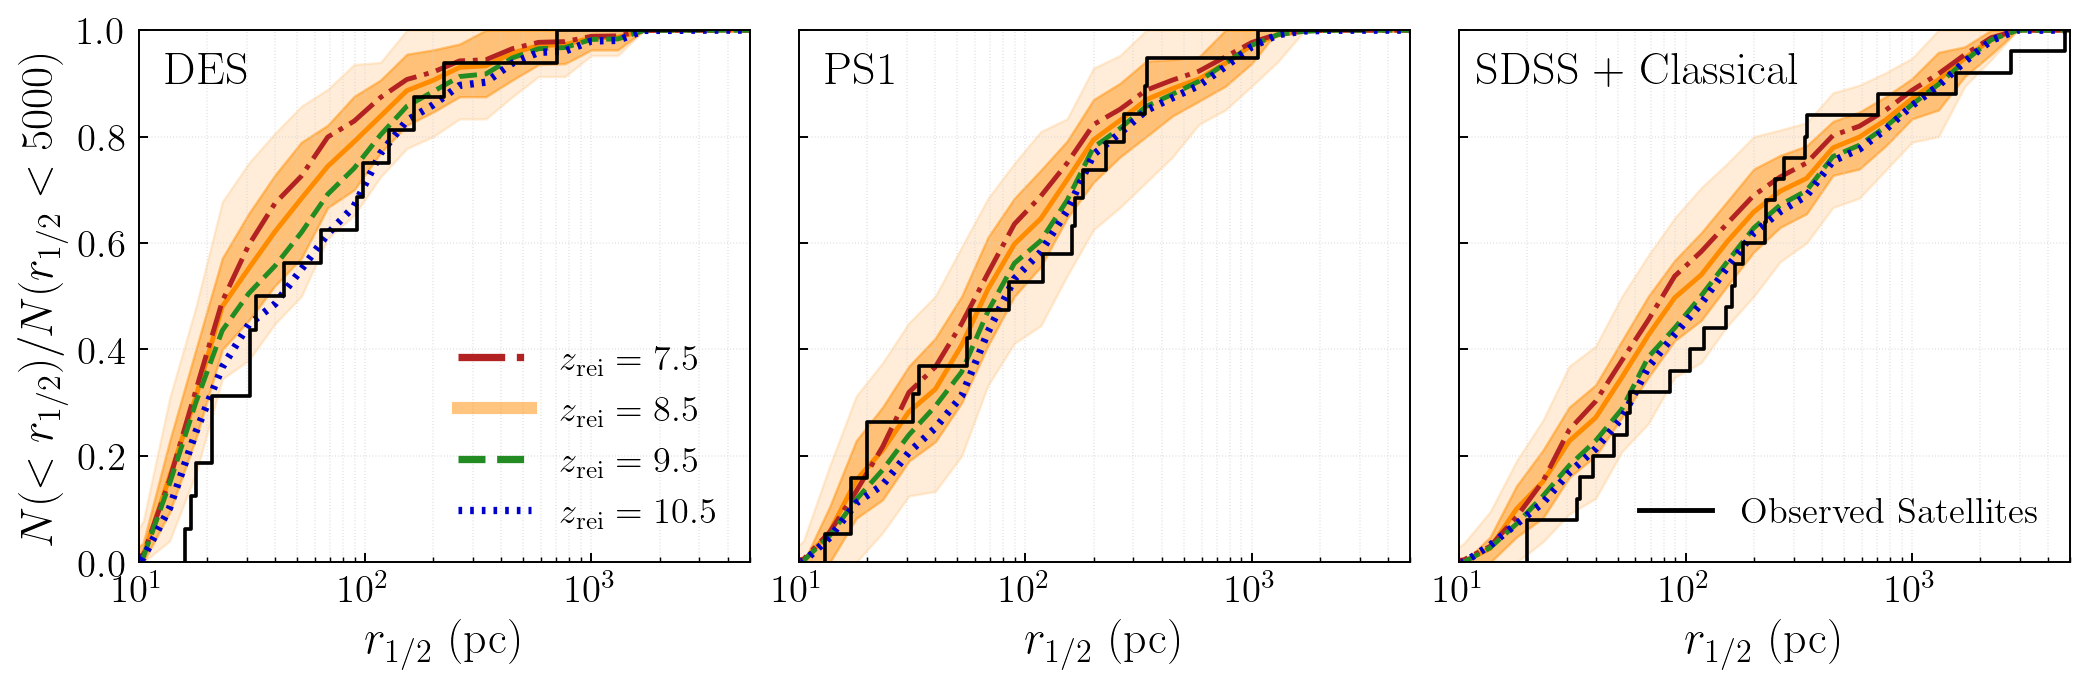

In [125]:
#3x1 r12 size distribution plots

### THIS IS FOR radials

fig,ax = plt.subplots(1,3,figsize = (12,4),sharey = True)

plt.subplots_adjust(wspace = 0.2)

# plt.subplots_adjust(wspace = 0.3,hspace = 0.3)

plot_contours(ax=ax[0],xlims_plot = [10,1000],ylims_plot = [0,1],all_contours=des_z8_5_conts_r12_n,
                    xlabel = False, ylabel = False,grid = False,
                     fsize = 19,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r"\rm $r_{1/2}$[pc]",med_lw=2,
                   ylabel_txt = r"\rm $N( < r_{1/2})$",shade=True,noshade_lw = 1,yscale = "nolog")

plot_contours(ax=ax[0],xlims_plot = [10,1000],ylims_plot = [0,1],all_contours=des_z7_5_conts_r12_n,
                    xlabel = False, ylabel = False,grid = False,
                     fsize = 19,mcol = "firebrick",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r"\rm $r_{1/2}$[pc]",med_lw=2,
                   ylabel_txt = r"\rm $N( < r_{1/2})$",shade=True,noshade_lw = 1,yscale = "nolog")

plot_contours(ax=ax[0],xlims_plot = [10,1000],ylims_plot = [0,1],all_contours=des_z9_5_conts_r12_n,
                    xlabel = False, ylabel = False,grid = False,
                     fsize = 19,mcol = "forestgreen",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "--",fsize_leg = 9,xlabel_txt = r"\rm $r_{1/2}$[pc]",med_lw=2,
                   ylabel_txt = r"\rm $N( < r_{1/2})$",shade=True,noshade_lw = 1,yscale = "nolog")

plot_contours(ax=ax[0],xlims_plot = [10,5000],ylims_plot = [0,1],all_contours=des_z10_5_conts_r12_n,
                    xlabel = True, ylabel = True,grid = True,
                     fsize = 19,mcol = "mediumblue",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r"\rm $r_{1/2}$ (pc)",med_lw = 3,
                   ylabel_txt = r"\rm $N( < r_{1/2})/N(r_{1/2} < 5000)$",shade=True,noshade_lw = 1,yscale = "nolog")


# ###########################################

plot_contours(ax=ax[1],xlims_plot = [10,1500],ylims_plot = [0,1],all_contours=ps1_z8_5_conts_r12_n,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 19,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt =r"\rm $r_{1/2}$[pc]",med_lw=2,
                   ylabel_txt = r"\rm $N( < r_{1/2})$",shade=True,noshade_lw = 1,yscale = "nolog")


plot_contours(ax=ax[1],xlims_plot =[10,1500],ylims_plot = [0,1],all_contours=ps1_z7_5_conts_r12_n,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 19,mcol = "firebrick",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r"\rm $r_{1/2}$[pc]",med_lw=2,
                   ylabel_txt = r"\rm $N( < r_{1/2})$",shade=True,noshade_lw = 1,yscale = "nolog")

plot_contours(ax=ax[1],xlims_plot = [10,1500],ylims_plot = [0,1],all_contours=ps1_z9_5_conts_r12_n,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 19,mcol = "forestgreen",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "--",fsize_leg = 9,xlabel_txt = r"\rm $r_{1/2}$[pc]",med_lw=2,
                   ylabel_txt = r"\rm $N( < r_{1/2})$",shade=True,noshade_lw = 1,yscale = "nolog")


plot_contours(ax=ax[1],xlims_plot = [10,5000],ylims_plot = [0,1],all_contours=ps1_z10_5_conts_r12_n,
                    xlabel = True, ylabel =False,grid = True,
                     fsize = 19,mcol = "mediumblue",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r"\rm $r_{1/2}$ (pc)",med_lw = 3,
                   ylabel_txt = r"\rm $N( < r_{1/2})$",shade=True,noshade_lw = 1,yscale = "nolog")


###########################################


plot_contours(ax=ax[2],xlims_plot = [10,5000],ylims_plot = [0,1],all_contours=sdss_z8_5_conts_r12_n,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 19,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt =r"\rm $r_{1/2}$ (pc)",med_lw=2,
                   ylabel_txt = r"\rm $N( < r_{1/2})$",shade=True,noshade_lw = 1,yscale = "nolog")



plot_contours(ax=ax[2],xlims_plot =[10,5000],ylims_plot = [0,1],all_contours=sdss_z7_5_conts_r12_n,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 19,mcol = "firebrick",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r"\rm $r_{1/2}$[pc]",med_lw=2,
                   ylabel_txt = r"\rm $N( < r_{1/2})$",shade=True,noshade_lw = 1,yscale = "nolog")

plot_contours(ax=ax[2],xlims_plot = [10,5000],ylims_plot = [0,1],all_contours=sdss_z9_5_conts_r12_n,
                    xlabel = True, ylabel = False,grid = False,
                     fsize = 19,mcol = "forestgreen",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "--",fsize_leg = 9,xlabel_txt =r"\rm $r_{1/2}$[pc]",med_lw=2,
                   ylabel_txt = r"\rm $N( < r_{1/2})$",shade=True,noshade_lw = 1,yscale = "nolog")


plot_contours(ax=ax[2],xlims_plot =[10,5000],ylims_plot = [0,1],all_contours=sdss_z10_5_conts_r12_n,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 19,mcol = "mediumblue",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt =r"\rm $r_{1/2}$ (pc)",med_lw = 3,
                   ylabel_txt = r"\rm $N( < r_{1/2})$",shade=True,noshade_lw = 1,yscale = "nolog")


#################################################

legend_elements = [Line2D([0], [0], color='firebrick', lw=3,ls = "-.",label=r'\rm $z_{\rm rei} = 7.5$',alpha = 1),
                   Line2D([0], [0], color='darkorange', lw=5,ls = "-", label=r'\rm $z_{\rm rei} = 8.5$',alpha = 0.5),
                    Line2D([0], [0], color='forestgreen', lw=3,ls = "--",label=r'\rm $z_{\rm rei} = 9.5$',alpha = 1),
                    Line2D([0], [0], color='mediumblue', lw=3,ls = "dotted",label=r'\rm $z_{\rm rei} = 10.5$',alpha = 1),
                      ]

ax[0].legend(frameon=False, fontsize = 15,loc = "lower right",handles = legend_elements,ncol=1)

legend_elements_2 = [Line2D([0], [0], color='k', lw=2,ls = "-",label=r'\rm Observed Satellites',alpha = 1),
                      ]

ax[2].legend(frameon=False, fontsize = 15,loc = "lower right",handles = legend_elements_2)



ax[0].tick_params(axis = "x",labelsize = 16)
ax[0].tick_params(axis = "y",labelsize = 16)

ax[1].tick_params(axis = "x",labelsize = 16)
ax[1].tick_params(axis = "y",labelsize = 16)

ax[2].tick_params(axis = "x",labelsize = 16)
ax[2].tick_params(axis = "y",labelsize = 16)


ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[2].set_xscale("log")
        
ax[0].plot(x_d_r,y_d_r/np.max(y_d_r),color = "k",lw = 1.5)
ax[2].plot(x_sdss_r,y_sdss_r/np.max(y_sdss_r),color = "k",lw = 1.5)
ax[1].plot(x_p_r,y_p_r/np.max(y_p_r),color = "k",lw = 1.5)

ax[2].text( 12,0.9,r"\rm SDSS + Classical",size = 19,fontweight = 'bold',color = "k")
ax[0].text( 13,0.9,r"\rm DES",size = 19,weight="bold")
ax[1].text( 13,0.9,r"\rm PS1",size = 19,weight="bold")


plt.tight_layout()
# plt.savefig("paper_figs_cater_pdf/all_rsizes_norm.pdf")
plt.show()





## D) Reionization constraint plot for DES/PS1 ufd census

25
400
32.490283861797806 39.207465663727106 47.42097196505763 58.26215575668109 69.27581473272062
400
26.938320406698004 32.8811468570904 40.33646530573445 50.18446006492422 60.76274516590482
400
24.13144033274354 29.1217905313595 35.696868809222664 45.185018641950194 53.714004452306646
400
21.72684016000074 26.07992270662644 31.960604318943403 38.865427047320985 46.43275252991063
400
18.816046546945486 23.013589522357 27.910878745398353 34.43854444744712 41.64483748704654
400
16.36001422917668 19.49221293836711 24.446700891222235 30.444928539386435 36.309116057094094
400
13.976007933703983 17.853970903401336 21.889836168292803 27.384034864797155 33.25733680384119
400
12.152527985380548 15.583299667903944 19.526606414115413 24.17030276825507 29.664142221038507
400
10.936788874438285 13.9960001076248 17.6908651421163 22.1396521370763 27.397728852818684
400
9.811656766767967 12.658390289259984 15.891060025161838 19.52795887176389 23.459266739919087
400
8.745372618541703 11.7796459253628

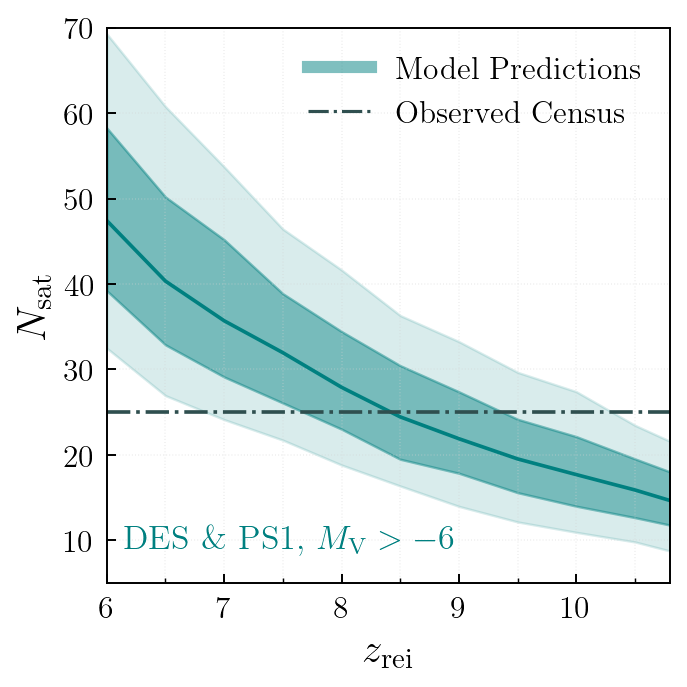

In [122]:
#### Nsat vs. zrei plot

def get_contours_reion(desps1_lmc,mw_mass = "vasiliev"):

    tot_num = []
    
    print(len(desps1_lmc['all_detects_mv']))
    
    for k in range(len(desps1_lmc['all_detects_mv'])):

        mhfi = desps1_lmc['all_halo_mass_menc100'][k]
        mvtr = desps1_lmc['all_detects_mv'][k]

        if mw_mass == "vasiliev":
            vasi_mass = np.random.normal(5.6,0.4,500)*1e11
            for mwi in vasi_mass:
                scale_f = mwi/mhfi  
#                 print(scale_f)
                tot_num.append(  len(mvtr[mvtr > -6])*scale_f) 


    print(np.percentile(tot_num,2.5), np.percentile(tot_num, 16),np.median(tot_num), np.percentile(tot_num,84), np.percentile(tot_num,97.5))  
        
    return np.percentile(tot_num,2.5), np.percentile(tot_num, 16),np.median(tot_num), np.percentile(tot_num,84), np.percentile(tot_num,97.5)   

def get_all_ranges(all_list):
    '''
    Function that takes in a list of get_lf_detects outputs and returns the 2sig and 1sig boundaries needed
    for contour plot making 
    
    '''
    
    all_ranges = []
            
    for k in all_list:
        dp_low2,dp_low1,median,dp_high1,dp_high2 = get_contours_reion(k)
        all_ranges.append([dp_low2,dp_low1,median,dp_high1,dp_high2])
        
    all_ranges = np.array(all_ranges)
    
    low2_all = all_ranges[:,0]
    low1_all = all_ranges[:,1]
    high1_all = all_ranges[:,3]
    high2_all = all_ranges[:,4]
    meds_all = all_ranges[:,2]
        
    all_tog = [low2_all, low1_all,meds_all, high1_all, high2_all]
    
    return all_tog
        
des_ps1_ufds = np.concatenate((np.array(mw_lf_des),np.array(mw_lf_ps1)))
print(len(des_ps1_ufds[des_ps1_ufds > -6]))
desps1_nsats = get_all_ranges([dp_z6_lmc_vasi,dp_z6_5_lmc_vasi,dp_z7_lmc_vasi,dp_z7_5_lmc_vasi,dp_z8_lmc_vasi,dp_z8_5_lmc_vasi,dp_z9_lmc_vasi,dp_z9_5_lmc_vasi,dp_z10_lmc_vasi,dp_z10_5_lmc_vasi,dp_z10_8_lmc_vasi  ] )  

fig,ax = plt.subplots(1,1,figsize = (4,4))

plt.subplots_adjust(hspace = 0.,wspace = 0.)

ax.fill_between( [6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,10.8], desps1_nsats[0],desps1_nsats[4] , color = "teal",alpha = 0.15)
ax.fill_between( [6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,10.8], desps1_nsats[1],desps1_nsats[3] , color = "teal",alpha = 0.45)

ax.plot( [6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,10.8], desps1_nsats[2], color = "teal")

ax.grid(ls = ":",color = "lightgrey",alpha = 0.3,which = "both")
ax.hlines(y = len(des_ps1_ufds[des_ps1_ufds > -6]), xmin = 6, xmax = 10.8, color = "darkslategrey",ls = "-.",lw = 1.5)

legend_elements_1 = [Line2D([0], [0], color='teal', lw=5, label=r'\rm Model Predictions',alpha = 0.5),
                   Line2D([0], [0], color='darkslategrey', lw=1.3,ls = "-.",label=r'\rm Observed Census',alpha = 1), 
                      ]

ax.text(6.15,9,r'\rm DES \& PS1, $M_{\rm V} > -6$',fontsize = 14,color = "teal")

ax.legend(frameon=False, fontsize = 13,loc = "upper right",handles = legend_elements_1)

# ax[0].text(7.55,55,r"\rm CI$_{95\%}$ : $z_{\rm rei} = 7.6^{+1.8}_{-1.1}$",size = 14, weight="bold",color = "darkslategrey")
ax.set_xlim([6,10.8])
ax.set_ylim([5,70])

ax.set_xlabel(r"$z_{\rm rei}$",fontsize = 17)

ax.set_ylabel(r"\rm $N_{\rm sat}$",fontsize = 17)

ax.tick_params(axis = "x",labelsize = 13)
ax.tick_params(axis = "y",labelsize = 13)

ax.set_xticks([6,7,8,9,10])
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
plt.tight_layout()
# plt.savefig("paper_figs_cater_pdf/zrei_implicate_dp.pdf")
plt.show()



## E) Future /current survey plots

In [149]:

lsst_z7_5_lmc_vasi = get_LF_detects(dfs=cat_z7_5, survey = "LSST",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 1,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =[None,None],z_fidu_vals = 2*[0.0570])


lsst_z8_5_lmc_vasi = get_LF_detects(dfs= cat_z8_5, survey = "LSST",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 1,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =[None,None],z_fidu_vals = 2*[0.0570])

lsst_z9_5_lmc_vasi = get_LF_detects(dfs=cat_z9_5, survey = "LSST",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 1,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =[None,None],z_fidu_vals =2*[0.0570])


lsst_z10_5_lmc_vasi = get_LF_detects(dfs=cat_z10_5, survey = "LSST",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 1,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =[None,None],z_fidu_vals = 2*[0.0570])


Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 326 353 382 415 448


Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 229 249 272 295 316


Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 153 167 183 200 218


Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 101 111 124 137 150


In [150]:
hsc_z10_5_lmc_vasi = get_LF_detects(dfs=cat_z10_5, survey = "HSC",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 2,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

hsc_z7_5_lmc_vasi = get_LF_detects(dfs=cat_z7_5, survey = "HSC",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 2,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

hsc_z8_5_lmc_vasi = get_LF_detects(dfs=cat_z8_5, survey = "HSC",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 2,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

hsc_z9_5_lmc_vasi = get_LF_detects(dfs=cat_z9_5, survey = "HSC",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 2,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])


Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 0 1 3 4 7


Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 4 6 8 13 16


Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 2 4 6 9 13


Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 1 2 4 6 9


In [151]:
hsc_all_z10_5_lmc_vasi = get_LF_detects(dfs=cat_z10_5, survey = "HSC_total",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 2,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =[None,None],z_fidu_vals = 2*[0.0570])

hsc_all_z7_5_lmc_vasi = get_LF_detects(dfs=cat_z7_5, survey = "HSC_total",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 2,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =[None,None],z_fidu_vals = 2*[0.0570])

hsc_all_z8_5_lmc_vasi = get_LF_detects(dfs=cat_z8_5, survey = "HSC_total",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 2,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =[None,None],z_fidu_vals = 2*[0.0570])

hsc_all_z9_5_lmc_vasi = get_LF_detects(dfs=cat_z9_5, survey = "HSC_total",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 2,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =[None,None],z_fidu_vals = 2*[0.0570])


Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 1 3 6 9 13


Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 10 13 17 25 33


Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 6 9 13 19 25


Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 3 6 9 13 19


In [152]:
delve_z10_5_lmc_vasi = get_LF_detects(dfs=cat_z10_5, survey = "DELVE",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 2,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =[None,None],z_fidu_vals = 2*[0.0570])

delve_z7_5_lmc_vasi = get_LF_detects(dfs=cat_z7_5, survey = "DELVE",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 2,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =[None,None],z_fidu_vals = 2*[0.0570])

delve_z8_5_lmc_vasi = get_LF_detects(dfs=cat_z8_5, survey = "DELVE",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 2,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =[None,None],z_fidu_vals = 2*[0.0570])

delve_z9_5_lmc_vasi = get_LF_detects(dfs=cat_z9_5, survey = "DELVE",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 2,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =[None,None],z_fidu_vals = 2*[0.0570])



Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 35 40 45 50 56


Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 63 71 81 88 101


Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 52 58 65 73 82


Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 41 47 53 61 68


In [153]:
hsc_zreicon_lmc_vasi = get_LF_detects(dfs=all_total_dfs, survey = "HSC",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 2,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals = total_lmc_vals,z_fidu_vals = z_fidu_vals)

hsc_all_zreicon_lmc_vasi = get_LF_detects(dfs=all_total_dfs, survey = "HSC_total",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 2,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals = total_lmc_vals,z_fidu_vals = z_fidu_vals)

delve_zreicon_lmc_vasi = get_LF_detects(dfs=all_total_dfs, survey = "DELVE",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 2,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals = total_lmc_vals,z_fidu_vals = z_fidu_vals)





Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.

Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.

Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.

In [148]:

lsst_zreicon_lmc_vasi = get_LF_detects(dfs=all_total_dfs, survey = "LSST",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 1,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals = total_lmc_vals,z_fidu_vals = z_fidu_vals)


Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.

In [154]:
#The number observed in LSST is 272 (median)



In [156]:
lsst_zreicon_conts_lf = get_contours(xindi_ALL = lsst_zreicon_lmc_vasi['LF_all'],all_halo_masses=lsst_zreicon_lmc_vasi['all_menc100'],
                                          nbins=27,xlog=False,grid_range = [-20,1])

delve_zreicon_conts_lf = get_contours(xindi_ALL = delve_zreicon_lmc_vasi['LF_all'],all_halo_masses=delve_zreicon_lmc_vasi['all_menc100'],
                                          nbins=27,xlog=False,grid_range = [-18,1])

hsc_zreicon_conts_lf = get_contours(xindi_ALL = hsc_zreicon_lmc_vasi['LF_all'],all_halo_masses=hsc_zreicon_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-12,0])

hsc_all_zreicon_conts_lf = get_contours(xindi_ALL = hsc_all_zreicon_lmc_vasi['LF_all'],all_halo_masses=hsc_all_zreicon_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=False,grid_range = [-12,1])


delve_z10_5_conts_lf = get_contours(xindi_ALL = delve_z10_5_lmc_vasi['LF_all'],all_halo_masses=delve_z10_5_lmc_vasi['all_menc100'],
                                          nbins=27,xlog=False,grid_range = [-18,1])

delve_z7_5_conts_lf = get_contours(xindi_ALL = delve_z7_5_lmc_vasi['LF_all'],all_halo_masses=delve_z7_5_lmc_vasi['all_menc100'],
                                          nbins=27,xlog=False,grid_range = [-18,1])


delve_z8_5_conts_lf = get_contours(xindi_ALL = delve_z8_5_lmc_vasi['LF_all'],all_halo_masses=delve_z8_5_lmc_vasi['all_menc100'],
                                          nbins=27,xlog=False,grid_range = [-18,1])

delve_z9_5_conts_lf = get_contours(xindi_ALL = delve_z9_5_lmc_vasi['LF_all'],all_halo_masses=delve_z9_5_lmc_vasi['all_menc100'],
                                          nbins=27,xlog=False,grid_range = [-18,1])

lsst_z10_5_conts_lf = get_contours(xindi_ALL = lsst_z10_5_lmc_vasi['LF_all'],all_halo_masses=lsst_z10_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=False,grid_range = [-17,1])

lsst_z7_5_conts_lf = get_contours(xindi_ALL = lsst_z7_5_lmc_vasi['LF_all'],all_halo_masses=lsst_z7_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=False,grid_range = [-17,1])

lsst_z8_5_conts_lf = get_contours(xindi_ALL = lsst_z8_5_lmc_vasi['LF_all'],all_halo_masses=lsst_z8_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=False,grid_range = [-17,1])

lsst_z9_5_conts_lf = get_contours(xindi_ALL = lsst_z9_5_lmc_vasi['LF_all'],all_halo_masses=lsst_z9_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=False,grid_range = [-17,1])


hsc_all_z10_5_conts_lf = get_contours(xindi_ALL = hsc_all_z10_5_lmc_vasi['LF_all'],all_halo_masses=hsc_all_z10_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=False,grid_range = [-12,1])

hsc_all_z7_5_conts_lf = get_contours(xindi_ALL = hsc_all_z7_5_lmc_vasi['LF_all'],all_halo_masses=hsc_all_z7_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=False,grid_range = [-12,1])

hsc_all_z8_5_conts_lf = get_contours(xindi_ALL = hsc_all_z8_5_lmc_vasi['LF_all'],all_halo_masses=hsc_all_z8_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=False,grid_range = [-12,1])


hsc_all_z9_5_conts_lf = get_contours(xindi_ALL = hsc_all_z9_5_lmc_vasi['LF_all'],all_halo_masses=hsc_all_z9_5_lmc_vasi['all_menc100'],
                                          nbins=25,xlog=False,grid_range = [-12,1])

hsc_z10_5_conts_lf = get_contours(xindi_ALL = hsc_z10_5_lmc_vasi['LF_all'],all_halo_masses=hsc_z10_5_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-12,0])

hsc_z7_5_conts_lf = get_contours(xindi_ALL = hsc_z7_5_lmc_vasi['LF_all'],all_halo_masses=hsc_z7_5_lmc_vasi['all_menc100'],
                                        nbins=20,xlog=False,grid_range = [-12,0])

hsc_z8_5_conts_lf = get_contours(xindi_ALL = hsc_z8_5_lmc_vasi['LF_all'],all_halo_masses=hsc_z8_5_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-12,0])


hsc_z9_5_conts_lf = get_contours(xindi_ALL = hsc_z9_5_lmc_vasi['LF_all'],all_halo_masses=hsc_z9_5_lmc_vasi['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-12,0])




--- 170.85102009773254 seconds ---
--- 167.81527185440063 seconds ---
--- 119.76116418838501 seconds ---
--- 146.3926100730896 seconds ---
--- 9.355306148529053 seconds ---
--- 9.576486349105835 seconds ---
--- 9.292526245117188 seconds ---
--- 9.667295932769775 seconds ---
--- 8.484068155288696 seconds ---
--- 9.571836948394775 seconds ---
--- 8.808709859848022 seconds ---
--- 9.222268104553223 seconds ---
--- 8.732089281082153 seconds ---
--- 9.083159923553467 seconds ---
--- 8.821367979049683 seconds ---
--- 9.2417311668396 seconds ---
--- 7.098839044570923 seconds ---
--- 6.896147012710571 seconds ---
--- 7.205018043518066 seconds ---
--- 7.380285263061523 seconds ---


In [158]:
#get the delve_prediction

mw_data = np.loadtxt(data_path + "drlica_wagner20_tab2_read.txt",dtype="str")
all_mw_mags = mw_data[:,10].astype(float) 
all_mw_r12 = mw_data[:,9].astype(float)
all_mw_heliods = mw_data[:,8].astype(float)
all_mw_ras = mw_data[:,3].astype(float)
all_mw_decs = mw_data[:,4].astype(float)
all_names = mw_data[:,0]


print(len(all_mw_heliods),len(all_mw_mags),len(all_mw_r12),len(all_mw_ras))


delve_ps = DELVE_predict(all_mw_heliods, all_mw_mags, all_mw_r12/1e3, all_mw_ras, all_mw_decs)


print(all_names[all_mw_mags < -12])
print(delve_ps[all_mw_mags < -12])
print(all_mw_mags[all_mw_mags < -12])


all_mw_mags_new = np.array(list(all_mw_mags) + [-4.7])
delve_ps = np.array(list(delve_ps) + [0.95594245])


all_delve_obs = []
for _ in range(500):    
    rnd = np.random.uniform(size = np.shape(delve_ps))
    mask = delve_ps > rnd
    all_delve_obs.append(all_mw_mags_new[mask == 1])
                            
#now we compute the median 
tot_realz = len(all_delve_obs)
all_delve_obs = np.concatenate(all_delve_obs)
print(len(all_delve_obs)/tot_realz)
uni_grid = np.linspace(-18,1,1000)
delve_x_ave = []
delve_y_ave = []

for ui in uni_grid:
    delve_x_ave.append(ui)
    delve_y_ave.append( len(all_delve_obs[all_delve_obs < ui]) )
        
#we normalize it now
delve_y_ave = np.array(delve_y_ave)/tot_realz  


#getting total HSC
    
hsc_all_ps = HSC_predict_total(all_mw_heliods, all_mw_mags, all_mw_r12/1e3, all_mw_ras, all_mw_decs)    
print(all_names[hsc_all_ps==1])
hsc_all_mw_mags = all_mw_mags[hsc_all_ps == 1]

x_hsc_total_lf, y_hsc_total_lf = get_linear_hist(hsc_all_mw_mags)


##for LSST Y1

lsst_ps = LSST_predict(all_mw_heliods, all_mw_mags, all_mw_r12/1e3, all_mw_ras, all_mw_decs)

print(np.sum(lsst_ps))

lsst_mw_mags = all_mw_mags[lsst_ps == 1]

print(all_names[lsst_ps == 1])
print(all_mw_mags[lsst_ps == 1])

x_lsst,y_lsst = get_linear_hist(lsst_mw_mags)




61 61 61 61
['LMC' 'SMC' 'Sagittarius' 'Fornax']
[1. 1. 1. 1.]
[-18.12 -17.18 -13.5  -13.46]
31.306
['BootesIV' 'CetusIII' 'DESJ0225+0304' 'LeoIV' 'LeoV' 'PegasusIII'
 'PiscesII' 'Sextans' 'VirgoI']
47.0
['LMC' 'SMC' 'AquariusII' 'BootesI' 'BootesII' 'BootesIII' 'Carina'
 'CarinaII' 'CarinaIII' 'CentaurusI' 'CetusIII' 'ColumbaI' 'ComaBerenices'
 'CraterII' 'DESJ0225+0304' 'Fornax' 'GrusI' 'GrusII' 'Hercules'
 'HorologiumI' 'HorologiumII' 'HydraII' 'HydrusI' 'IndusII' 'Kim2'
 'Leavens' 'LeoI' 'LeoII' 'LeoIV' 'LeoV' 'PegasusIII' 'PhoenixII'
 'PictorI' 'PictorII' 'PiscesII' 'ReticulumII' 'ReticulumIII'
 'SagittariusII' 'Sculptor' 'Segue1' 'Segue2' 'Sextans' 'TucanaII'
 'TucanaIII' 'TucanaIV' 'TucanaV' 'VirgoI']
[-18.12 -17.18  -4.4   -6.02  -2.94  -5.75  -9.43  -4.5   -2.4   -5.55
  -2.5   -4.2   -4.38  -8.2   -1.1  -13.46  -3.47  -3.9   -5.83  -3.55
  -2.6   -4.6   -4.71  -4.3   -3.32  -4.8  -11.78  -9.74  -4.99  -4.4
  -3.4   -3.3   -3.45  -3.2   -4.22  -3.88  -3.3   -5.2  -10.82  -1.3


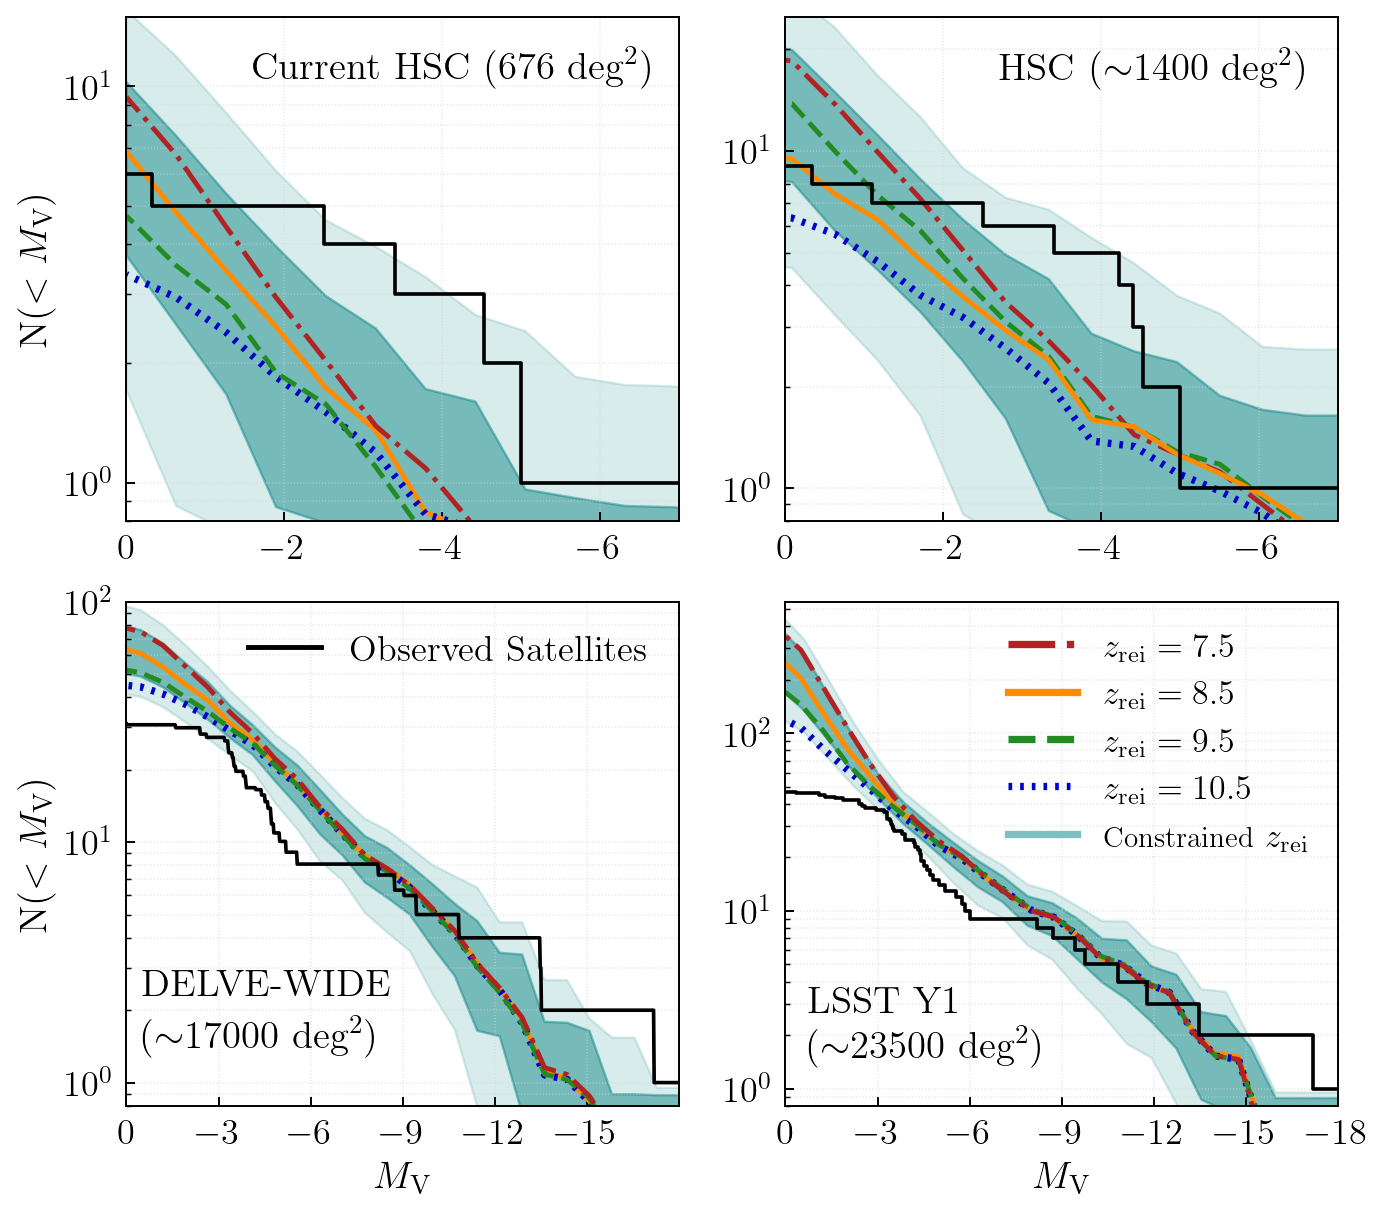

In [159]:

#make plot for future HSC predictions

fig,ax = plt.subplots(2,2,figsize = (8,7),sharey=False)


plt.subplots_adjust(wspace = 0.2,hspace = 0.2)

#################################################

plot_contours(ax=ax[0,1],xlims_plot = [0,-7],ylims_plot = [1,11],all_contours=hsc_all_z10_5_conts_lf,
                    xlabel = False, ylabel = False,grid = False,
                     fsize = 14,mcol = "mediumblue",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=3,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")



plot_contours(ax=ax[0,1],xlims_plot = [0,-7],ylims_plot = [1,11],all_contours=hsc_all_z7_5_conts_lf,
                    xlabel = False, ylabel = False,grid = False,
                     fsize = 14,mcol = "firebrick",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")

plot_contours(ax=ax[0,1],xlims_plot = [0,-7],ylims_plot = [1,11],all_contours=hsc_all_z8_5_conts_lf,
                    xlabel =False, ylabel = False,grid = False,
                     fsize = 14,mcol = "forestgreen",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "--",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[0,1],xlims_plot = [0,-9],ylims_plot = [1,25],all_contours=hsc_all_z9_5_conts_lf,
                    xlabel = False, ylabel = False,grid = True,
                     fsize = 16,mcol = "darkorange",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw = 2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[0,1],xlims_plot = [0,-7],ylims_plot = [0.8,25],all_contours=hsc_all_zreicon_conts_lf,
                    xlabel = False, ylabel = False,grid = True,
                     fsize = 16,mcol = "teal",sig1 = True,sig2 = True,sig3=False,median=False,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw = 3,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")

####################

plot_contours(ax=ax[0,0],xlims_plot = [0,-7],ylims_plot = [1,11],all_contours=hsc_z8_5_conts_lf,
                    xlabel = False, ylabel = False,grid = False,
                     fsize = 14,mcol = "darkorange",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")



plot_contours(ax=ax[0,0],xlims_plot = [0,-7],ylims_plot = [1,11],all_contours=hsc_z10_5_conts_lf,
                    xlabel = False, ylabel = False,grid = False,
                     fsize = 14,mcol = "mediumblue",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=3,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")

plot_contours(ax=ax[0,0],xlims_plot = [0,-7],ylims_plot = [1,11],all_contours=hsc_z9_5_conts_lf,
                    xlabel =False, ylabel = False,grid = False,
                     fsize = 14,mcol = "forestgreen",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "--",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[0,0],xlims_plot = [0,-9],ylims_plot = [1,15],all_contours=hsc_z7_5_conts_lf,
                    xlabel = False, ylabel = True,grid = True,
                     fsize = 16,mcol = "firebrick",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw = 2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[0,0],xlims_plot = [0,-7],ylims_plot = [0.8,15],all_contours=hsc_zreicon_conts_lf,
                    xlabel = False, ylabel = True,grid = True,
                     fsize = 16,mcol = "teal",sig1 = True,sig2 =True,sig3=False,median=False,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw = 3,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


############################################


plot_contours(ax=ax[1,0],xlims_plot = [0,-14],ylims_plot = [1,150],all_contours=delve_z8_5_conts_lf,
                    xlabel = True, ylabel = True,grid = True,
                     fsize = 16,mcol = "darkorange",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[1,0],xlims_plot = [0,-7],ylims_plot = [1,150],all_contours=delve_z10_5_conts_lf,
                    xlabel = False, ylabel = False,grid = False,
                     fsize = 14,mcol = "mediumblue",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=3,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")

plot_contours(ax=ax[1,0],xlims_plot = [0,-7],ylims_plot = [1,150],all_contours=delve_z9_5_conts_lf,
                    xlabel =False, ylabel = False,grid = False,
                     fsize = 14,mcol = "forestgreen",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "--",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[1,0],xlims_plot = [0,-16],ylims_plot = [1,100],all_contours=delve_z7_5_conts_lf,
                    xlabel = False, ylabel = True,grid = True,
                     fsize = 16,mcol = "firebrick",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw = 2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[1,0],xlims_plot = [0,-16],ylims_plot = [0.8,100],all_contours=delve_zreicon_conts_lf,
                    xlabel = False, ylabel = True,grid = True,
                     fsize = 16,mcol = "teal",sig1 = True,sig2 = True,sig3=False,median=False,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw = 3,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


######################

plot_contours(ax=ax[1,1],xlims_plot = [0,-19],ylims_plot = [1,350],all_contours=lsst_z8_5_conts_lf,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 14,mcol = "darkorange",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[1,1],xlims_plot = [0,-7],ylims_plot = [1,150],all_contours=lsst_z10_5_conts_lf,
                    xlabel = False, ylabel = False,grid = False,
                     fsize = 14,mcol = "mediumblue",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=3,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[1,1],xlims_plot = [0,-7],ylims_plot = [1,150],all_contours=lsst_z9_5_conts_lf,
                    xlabel =False, ylabel = False,grid = False,
                     fsize = 14,mcol = "forestgreen",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "--",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[1,1],xlims_plot = [0,-18],ylims_plot = [1,550],all_contours=lsst_z7_5_conts_lf,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 16,mcol = "firebrick",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "-.",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw = 2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[1,1],xlims_plot = [0,-18],ylims_plot = [0.8,550],all_contours=lsst_zreicon_conts_lf,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 16,mcol = "teal",sig1 = True,sig2 = True,sig3=False,median=False,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw = 3,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log")


legend_elements_2 = [Line2D([0], [0], color='k', lw=2,ls = "-",label=r'\rm Observed Satellites',alpha = 1),
                      ]

ax[1,0].legend(frameon=False, fontsize = 15,loc = "upper right",handles = legend_elements_2)


for axi in ax:
    for axii in axi:
        axii.tick_params(axis = "x",labelsize = 15)
        axii.tick_params(axis = "y",labelsize = 15)
        
        
ax[1,1].set_xticks([0,-3,-6,-9,-12,-15,-18])
ax[1,0].set_xticks([0,-3,-6,-9,-12,-15,-18])

ax[1,0].set_xticks([0,-3,-6,-9,-12,-15])



ax[0,0].plot(x_hsc_lf,y_hsc_lf,color = "k",lw = 1.5)
ax[0,1].plot(x_hsc_total_lf, y_hsc_total_lf,color = "k",lw = 1.5)
ax[1,0].plot(delve_x_ave,delve_y_ave,color = "k",lw = 1.5)
ax[1,1].plot(x_lsst,y_lsst,color = "k",lw = 1.5)


ax[0,1].text( -2.7,16.3, r"\rm HSC ($\sim$1400 deg$^2$)",size = 16,weight = "bold")
ax[0,0].text( -1.6,10.5, r"\rm Current HSC (676 deg$^2$)",size = 16,weight = "bold")

ax[1,0].text( -0.5,2.3, r"\rm DELVE-WIDE",size = 16,weight = "bold")
ax[1,0].text( -0.5,1.4, r"\rm ($\sim$17000 deg$^2$)",size = 16,weight = "bold")

ax[1,1].text( -0.75,2.7, r"\rm LSST Y1",size = 16,weight = "bold")
ax[1,1].text( -0.75,1.5, r"\rm ($\sim$23500 deg$^2$)",size = 16,weight = "bold")



legend_elements = [Line2D([0], [0], color='firebrick', lw=3,ls = "-.",label=r'\rm $z_{\rm rei} = 7.5$',alpha = 1),
                   Line2D([0], [0], color='darkorange', lw=3,ls = "-", label=r'\rm $z_{\rm rei} = 8.5$',alpha =1),
                    Line2D([0], [0], color='forestgreen', lw=3,ls = "--",label=r'\rm $z_{\rm rei} = 9.5$',alpha = 1),
                    Line2D([0], [0], color='mediumblue', lw=3,ls = "dotted",label=r'\rm $z_{\rm rei} = 10.5$',alpha = 1),
                   Line2D([0], [0], color='teal', lw=3,label=r'\rm {\large Constrained} $z_{\rm rei}$',alpha = 0.5)  
                      ]

leg = ax[1,1].legend(frameon=False, fontsize = 14,loc = "upper right",handles = legend_elements,ncol=1)


plt.tight_layout()
# plt.savefig("paper_figs_cater_pdf/fut_prospects_new.pdf")
# 
plt.show()



## F) Resolution plot

In [160]:
cat_LX13_z8_5 = read_all_LX13(data_path + "caterpillar_outputs/LX13_outs/LX13_zrei8_5_etan18_etap_045_lmc_CC")




---------------
/Volumes/minions/random_explore/caterpillar_outputs/LX13_outs/LX13_zrei8_5_etan18_etap_045_lmc_CC/caterpillar_53_LX13_LX13_zrei8_5_etan18_etap_045_lmc_CC_run_pe_t_13.00.csv
/Volumes/minions/random_explore/caterpillar_outputs/LX13_outs/LX13_zrei8_5_etan18_etap_045_lmc_CC/caterpillar_4_LX13_LX13_zrei8_5_etan18_etap_045_lmc_CC_run_pe_t_13.00.csv
---------------


In [161]:

des_z8_5_lx13 = get_LF_detects(dfs=cat_LX13_z8_5, survey = "DES",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])

ps1_z8_5_lx13 = get_LF_detects(dfs=cat_LX13_z8_5, survey = "PS1",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals =2*[None],z_fidu_vals = 2*[0.0570])


Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.6964684750409775
The LMC hdist is : 44.51304406348358
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.7298465721353007
The LMC hdist is : 59.666393393928374

1,2 sigma range in number of detects : 8 10 13 16 20


Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.6964684750409775
The LMC hdist is : 44.51304406348358
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.7298465721353007
The LMC hdist is : 59.666393393928374

1,2 sigma range in number of detects : 9 11 14 17 20


In [162]:



des_z8_5_conts_lf_lx13 = get_contours(xindi_ALL = des_z8_5_lx13['LF_all'],all_halo_masses=des_z8_5_lx13['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-15,1])

ps1_z8_5_conts_lf_lx13 = get_contours(xindi_ALL = ps1_z8_5_lx13['LF_all'],all_halo_masses=ps1_z8_5_lx13['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-15,1])




des_z8_5_conts_rad_lx13_n = get_contours(xindi_ALL = des_z8_5_lx13['heli_all'],all_halo_masses=des_z8_5_lx13['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True)

ps1_z8_5_conts_rad_lx13_n = get_contours(xindi_ALL = ps1_z8_5_lx13['heli_all'],all_halo_masses=ps1_z8_5_lx13['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [0,300],norm=True)






--- 6.88803505897522 seconds ---
--- 6.574686050415039 seconds ---
--- 0.14711499214172363 seconds ---
--- 0.14438080787658691 seconds ---


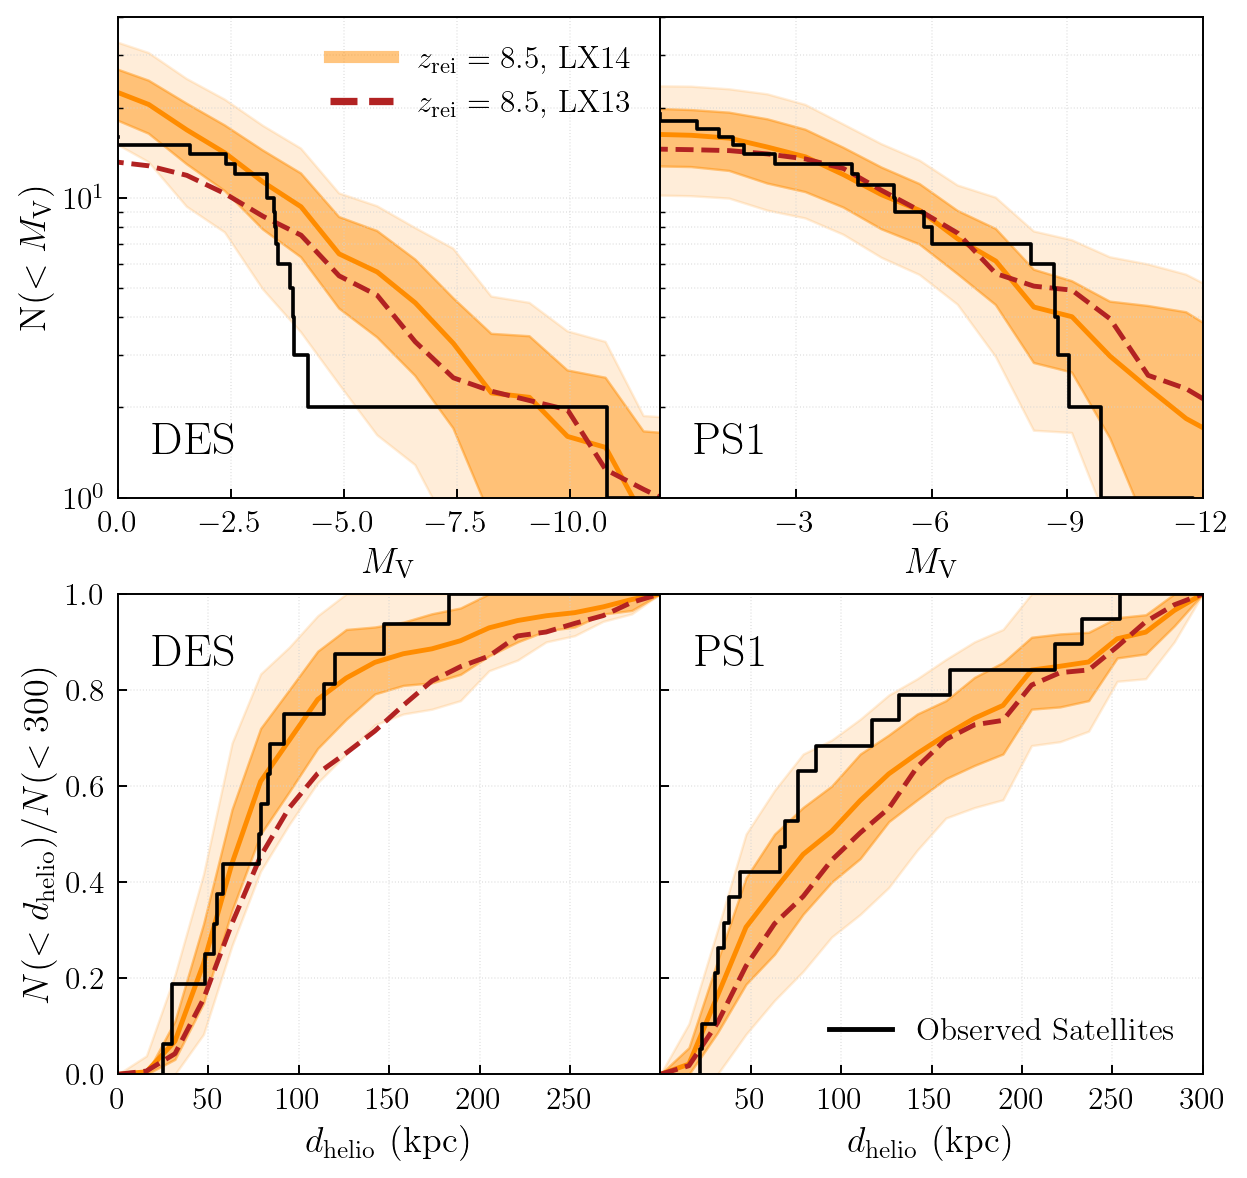

In [163]:
### DES LF for different MW mass constraint

fig,ax = plt.subplots(2,2,figsize = (8,8))


plt.subplots_adjust(wspace = 0.,hspace =0.2)

plot_contours(ax=ax[0,0],xlims_plot = [0,-12],ylims_plot = [1,30],all_contours=des_z8_5_conts_lf,
                    xlabel = False, ylabel = False,grid = False,
                     fsize = 15,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log",med_alpha = 0.45)

plot_contours(ax=ax[0,0],xlims_plot = [0,-12],ylims_plot = [1,40],all_contours=des_z8_5_conts_lf_lx13,
                    xlabel = True, ylabel = True,grid = True,
                     fsize = 15,mcol = "firebrick",sig1 = False,sig2 =False,sig3=False,median=True,
                   label = None,med_ls = "--",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=False,noshade_lw = 1,yscale = "log")



plot_contours(ax=ax[0,1],xlims_plot = [0,-15],ylims_plot = [1,30],all_contours=ps1_z8_5_conts_lf,
                    xlabel = False, ylabel = False,grid = False,
                     fsize = 15,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log",med_alpha = 0.45)

plot_contours(ax=ax[0,1],xlims_plot = [0,-12],ylims_plot = [1,40],all_contours=ps1_z8_5_conts_lf_lx13,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 15,mcol = "firebrick",sig1 = False,sig2 =False,sig3=False,median=True,
                   label = None,med_ls = "--",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=False,noshade_lw = 1,yscale = "log")


legend_elements = [Line2D([0], [0], color='darkorange', lw=5,label=r'\rm $z_{\rm rei} = 8.5$, LX14',alpha = 0.5),
                   Line2D([0], [0], color='firebrick', lw=3,ls = "--",label=r'\rm $z_{\rm rei} = 8.5$, LX13',alpha = 1)                  
                      ]

ax[0,0].legend(frameon=False, fontsize = 13,loc = "upper right",handles = legend_elements,ncol=1)


for axi in ax:
    for axii in axi:
        axii.tick_params(axis = "x",labelsize = 13)
        axii.tick_params(axis = "y",labelsize = 13)
        

ax[0,1].set_yticks([])


ax[0,0].plot(x_d_lf, y_d_lf,color = "k",lw = 1.5)
ax[0,1].plot(x_p_lf, y_p_lf,color = "k",lw = 1.5)

ax[0,0].text( -0.75,1.4,r"\rm DES",size = 19,weight="bold")
ax[0,1].text( -0.75,1.4,r"\rm PS1",size = 19,weight="bold")

ax[0,0].set_xticks([0,-2.5,-5,-7.5,-10])
ax[0,1].set_xticks([-3,-6,-9,-12])



plot_contours(ax=ax[1,0],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=des_z8_5_conts_rad_n,
                    xlabel = False, ylabel = False,grid = True,
                     fsize = 15,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "nolog",med_alpha = 0.45)


plot_contours(ax=ax[1,0],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=des_z8_5_conts_rad_lx13_n,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 15,mcol = "firebrick",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "--",fsize_leg = 9,xlabel_txt =r"\rm $d_{\rm helio}$ (kpc)",med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=False,noshade_lw = 1,yscale = "nolog",med_alpha = 0.45)


plot_contours(ax=ax[1,1],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=ps1_z8_5_conts_rad_n,
                    xlabel = False, ylabel = False,grid = True,
                     fsize = 15,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "nolog",med_alpha = 0.45)


plot_contours(ax=ax[1,1],xlims_plot = [0,300],ylims_plot = [0,1],all_contours=ps1_z8_5_conts_rad_lx13_n,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 15,mcol = "firebrick",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "--",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$ (kpc)",med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=False,noshade_lw = 1,yscale = "nolog",med_alpha = 0.45)


ax[1,1].plot(x_p_h, y_p_h/np.max(y_p_h),color = "k",lw = 1.5)
ax[1,0].plot(x_d_h, y_d_h/np.max(y_d_h),color = "k",lw = 1.5)

ax[1,1].set_yticklabels([])

ax[1,0].set_ylabel(r"\rm $N( < d_{\rm helio})$/$N(< 300)$",fontsize = 15)

ax[1,0].text(19,0.85,r"\rm DES",color = "k",size = 19,weight="bold")
ax[1,1].text(19,0.85,r"\rm PS1",color = "k",size = 19,weight="bold")


legend_elements_2 = [Line2D([0], [0], color='k', lw=2,ls = "-",label=r'\rm Observed Satellites',alpha = 1),
                      ]

ax[1,1].legend(frameon=False, fontsize = 13,loc = "lower right",handles = legend_elements_2)

ax[1,0].set_xticks([0,50,100,150,200,250])
ax[1,1].set_xticks([50,100,150,200,250,300])


# plt.tight_layout()
# plt.savefig("paper_figs_cater_pdf/des_ps1_LX14_LX13.pdf")
plt.show()


############


## H)  halo star cluster plot

In [164]:

desps1_small_r12 = get_LF_detects(dfs=all_total_dfs, survey = "DES+PS1",lmc_rotate=True,res_cut = 0,size_cut=0,mv_cut = 0,size_cut_max = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals = total_lmc_vals,z_fidu_vals = z_fidu_vals)



Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.

In [165]:
dp_small_r12_conts = get_contours(xindi_ALL = desps1_small_r12['r12_all'],all_halo_masses=desps1_small_r12['all_menc100'],
                                          nbins=20,xlog=True,grid_range = [np.log10(1),np.log10(20)])


dp_small_rad_conts = get_contours(xindi_ALL = desps1_small_r12['heli_all'],all_halo_masses=desps1_small_r12['all_menc100'],
                                          nbins=20,grid_range = [0,300])


dp_small_lf_conts = get_contours(xindi_ALL = desps1_small_r12['LF_all'],all_halo_masses=desps1_small_r12['all_menc100'],
                                          nbins=20,grid_range = [-7,1])

--- 116.75289797782898 seconds ---
--- 118.5615439414978 seconds ---
--- 119.55505323410034 seconds ---


In [167]:
## r12 size distribution for DES+PS1 and no size cuts
# mw_des_r12_all = [707,223, 31, 165, 92, 31, 44, 128, 21, 33, 16, 18, 98, 17, 21, 12,64]
# #des includes Kim 2
# mw_ps1_r12_all = [226, 165, 180, 272, 345, 338, 160, 85, 57, 32, 20, 55, 20, 34, 1066, 20,17 ,13, 120]
# #
# print(len(mw_des_r12_all),len(mw_ps1_r12_all))
# print(len(mw_lf_des),len(mw_lf_ps1[:-1]))

des_harris_r12 = [4.02]
eri_3 = [6.239820216]

# all_ufsc = [4.16,6.89,7.55,5.65,5.43,5.56,4.73]
# all_ufsc_mv = [-1.42,-1.1,-1.1,-2,-0.2,-1.21,-1.9]
# all_ufsc_heli = [76,23.8,31.3,76.2,19,31.9,29.6]

all_ufsc = [4.16, 7.55, 6, 5.43, 7.2, 4.73]
all_ufsc_mv = [-1.42, -1.1, -1.6, -0.2, -1.21, -1.9]
all_ufsc_heli = [76, 31.3, 76.2, 19, 31.9, 29.6]

des_harris_mv = [-1.81]
eri_3_mv = [-2.07]


des_harris_rad = [32.2]
eri_3_rad = [91]




x_dp_sr, y_dp_sr = get_linear_hist(des_harris_r12  + eri_3 + all_ufsc,oppo=False,minx =3100)

x_dp_smv, y_dp_smv = get_linear_hist(des_harris_mv + eri_3_mv + all_ufsc_mv)

x_dp_smh, y_dp_smh = get_linear_hist(des_harris_rad + eri_3_rad + all_ufsc_heli,oppo=False,minx=310)


/Users/radioactive/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator


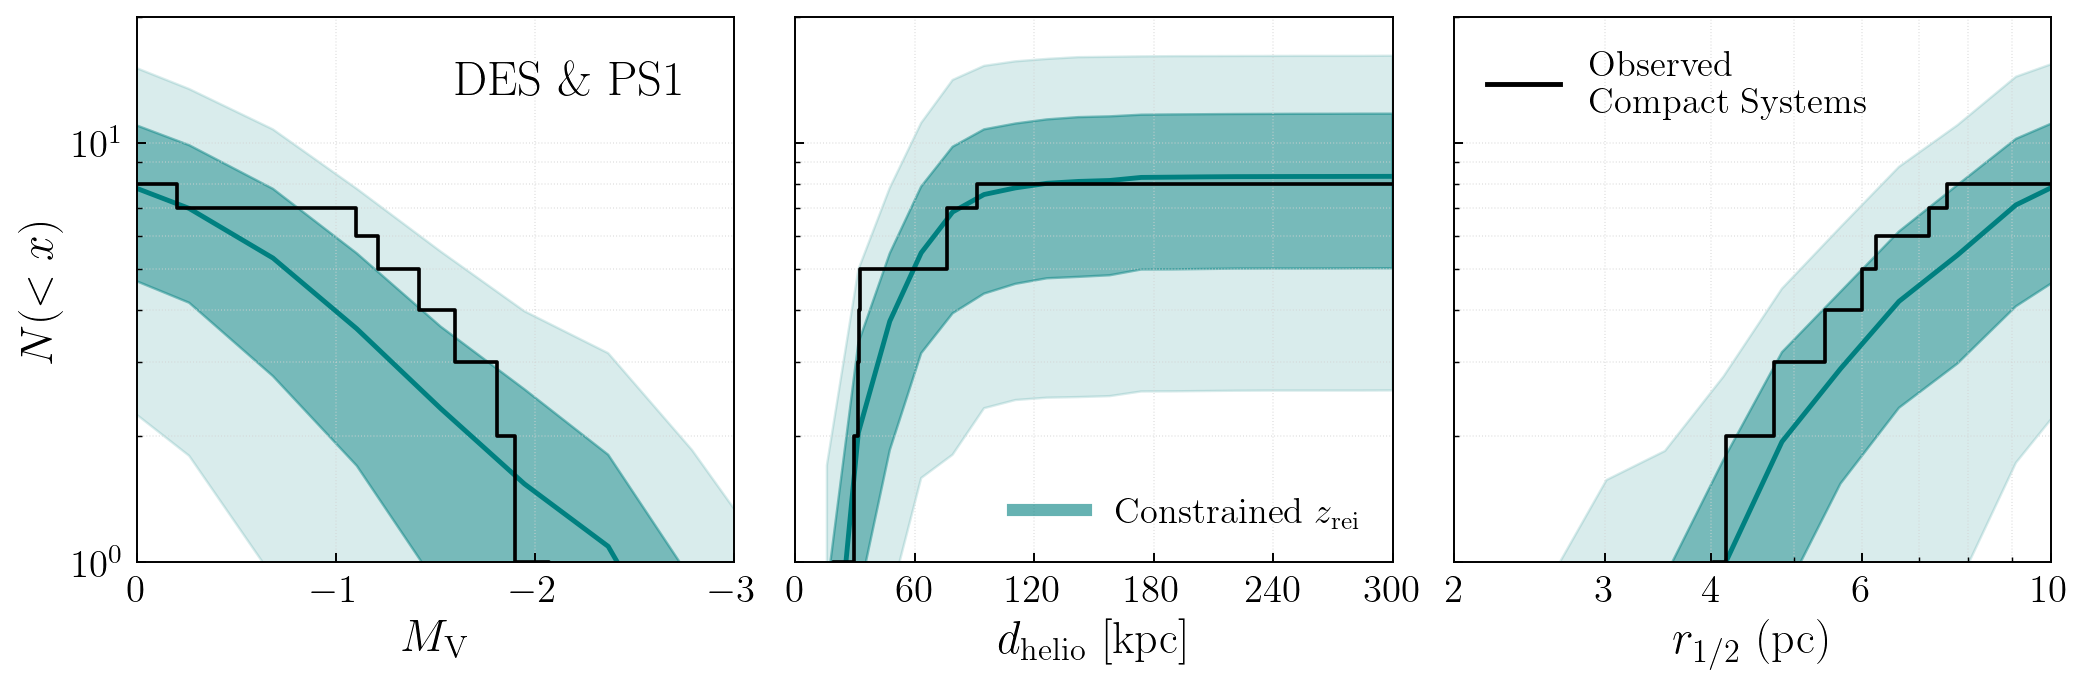

In [168]:

fig,ax = plt.subplots(1,3,figsize = (12,4),sharey=True)


#CHANGE COLOR OF THIS CONTOUR AS THIS IS NOT FOR ZREI=7.5
plt.subplots_adjust(wspace = 0.2)


plot_contours(ax=ax[2],xlims_plot = [2,10],ylims_plot = [1,20],all_contours=dp_small_r12_conts,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 19,mcol = "teal",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r"\rm $r_{1/2}$ (pc)",med_lw=2,
                   ylabel_txt = r"\rm $N( < r_{1/2})$",shade=True,noshade_lw = 1,yscale = "log")
    

plot_contours(ax=ax[1],xlims_plot = [0,300],ylims_plot = [1,20],all_contours=dp_small_rad_conts,
                    xlabel = True, ylabel = False,grid = True,
                     fsize = 19,mcol = "teal",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r"\rm $d_{\rm helio}$ [kpc]",med_lw=2,
                   ylabel_txt = r"\rm $N( < d_{\rm helio})$",shade=True,noshade_lw = 1,yscale = "log")


plot_contours(ax=ax[0],xlims_plot = [0,-3],ylims_plot = [1,20],all_contours=dp_small_lf_conts,
                    xlabel = True, ylabel = True,grid = True,
                     fsize = 19,mcol = "teal",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r"$M_{\rm V}$",med_lw=2,
                   ylabel_txt = r"\rm $N( < x)$",shade=True,noshade_lw = 1,yscale = "log")



ax[0].plot(x_dp_smv,y_dp_smv,color = "k",lw = 1.5)
ax[1].plot(x_dp_smh,y_dp_smh,color = "k",lw = 1.5)
ax[2].plot(x_dp_sr,y_dp_sr,color = "k",lw = 1.5)



for axi in ax:
    axi.tick_params(axis = "x",labelsize = 16)
    axi.tick_params(axis = "y",labelsize = 16)

ax[0].text(-1.6,13,r"\rm DES \& PS1",size = 20, weight="bold")



legend_elements = [Line2D([0], [0], color='k', lw=2,ls = "-",label=r'\rm Observed' + '\n' + r'\rm Compact Systems',alpha = 1)]


legend_elements_0 = [Line2D([0], [0], color='teal', lw=5,ls = "-",label=r'\rm Constrained $z_{\rm rei}$',alpha = 0.6)]

# \rm Confirmed \& Candidate + Probable Star Clusters 

ax[2].legend(frameon=False, fontsize = 15,handles = legend_elements[::-1],loc = "upper left")

ax[1].legend(frameon=False, fontsize = 15,handles = legend_elements_0,loc = "lower right")


ax[2].set_xscale("log")

from matplotlib.ticker import FixedLocator, FixedFormatter
x_formatter = FixedFormatter([r"\rm 2",r"\rm 3",r"\rm 4",r"\rm 6",r"\rm 10 "])
x_locator = FixedLocator([2,3,4,6,10])
ax[2].xaxis.set_major_formatter(x_formatter)
ax[2].xaxis.set_major_locator(x_locator)

# ax[1].set_xticks([0,50,100,150,200,250,300])
ax[1].set_xticks([0,60,120,180,240,300])


plt.tight_layout()
# plt.savefig("paper_figs_cater_pdf/smallest_dwarf.pdf")
plt.show()



## I)  Other random plots

In [104]:
# ## des survey contours for different MW mass constraint

des_z8_5_lmc_deason = get_LF_detects(dfs=cat_z8_5, survey = "DES",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "deason",lmc_index_vals =[None,None],z_fidu_vals = 2*[0.0570])


des_z8_5_deason = get_contours(xindi_ALL = des_z8_5_lmc_deason['LF_all'],all_halo_masses=des_z8_5_lmc_deason['all_m200c'],
                                          nbins=20,xlog=False,grid_range = [-15,1],mw_mass = "deason")



des_z8_5_lmc_h3 = get_LF_detects(dfs=cat_z8_5, survey = "DES",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "h3",lmc_index_vals =[None,None],z_fidu_vals = 2*[0.0570])


des_z8_5_h3 = get_contours(xindi_ALL = des_z8_5_lmc_h3['LF_all'],all_halo_masses=des_z8_5_lmc_h3['all_menc100'],
                                          nbins=20,xlog=False,grid_range = [-15,1],mw_mass = "h3")




Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 306.6376279705092
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 305.8516383384898
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 19 23 27 33 39
--- 7.043769836425781 seconds ---


Mass enclosed within 100 in 1e11 units: 6.711732826033154
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 307.5052712632989
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Mass enclosed within 100 in 1e11 units: 6.5821466077057655
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The farthest satellite is at : 305.23709765804557
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424

1,2 sigma range in number of detects : 18 23 28 33 40
--- 7.074218988418579 seconds ---


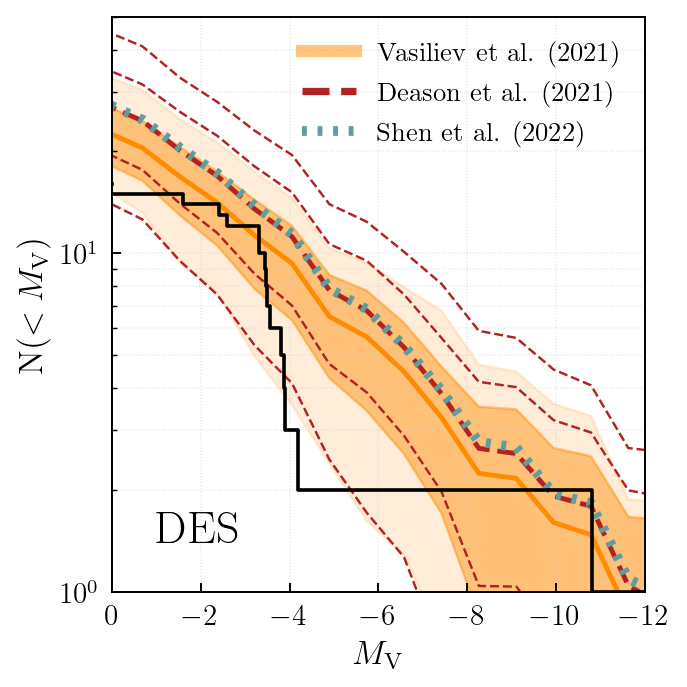

In [107]:
### DES LF for different MW mass constraint

fig,ax = plt.subplots(1,1,figsize = (4,4))


plot_contours(ax=ax,xlims_plot = [0,-12],ylims_plot = [1,50],all_contours=des_z8_5_conts_lf,
                    xlabel = False, ylabel = False,grid = False,
                     fsize = 14,mcol = "darkorange",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log",med_alpha = 0.45)

plot_contours(ax=ax,xlims_plot = [0,-12],ylims_plot = [1,40],all_contours=des_z8_5_deason,
                    xlabel = True, ylabel = True,grid = True,
                     fsize = 14,mcol = "firebrick",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "--",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=False,noshade_lw = 1,yscale = "log")

plot_contours(ax=ax,xlims_plot = [0,-12],ylims_plot = [1,50],all_contours=des_z8_5_h3,
                    xlabel = True, ylabel = True,grid = True,
                     fsize = 14,mcol = "cadetblue",sig1 = False,sig2 = False,sig3=False,median=True,
                   label = None,med_ls = "dotted",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=4,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=False,noshade_lw = 1,yscale = "log")


legend_elements = [Line2D([0], [0], color='darkorange', lw=5,label=r'\rm Vasiliev et al. (2021)',alpha = 0.5),
                   Line2D([0], [0], color='firebrick', lw=3,ls = "--",label=r'\rm Deason et al. (2021)',alpha = 1)  ,  
                   Line2D([0], [0], color='cadetblue', lw=4,ls = "dotted",label=r'\rm Shen et al. (2022)',alpha = 1)                  
                   
                      ]

ax.legend(frameon=False, fontsize = 11,loc = "upper right",handles = legend_elements,ncol=1)

ax.tick_params(axis = "x",labelsize = 12)
ax.tick_params(axis = "y",labelsize = 12)
    
ax.plot(x_d_lf, y_d_lf,color = "k",lw = 1.5)

ax.text( -1,1.4,r"\rm DES",size = 19,weight="bold")

plt.tight_layout()
plt.savefig("des_mw_mass_appendix.pdf")
plt.show()




We make a calculation similar to Nadler 2020 for the number of satellites in HSC-SSP footprint.

In [147]:
hsc_N20 = get_LF_detects(dfs=all_total_dfs, survey = "HSC_nadler",lmc_rotate=True,res_cut = 0,size_cut=10/1e3,mv_cut = 10,
                   norm=False,switch_dec = False,scale_mass = True,verbose=False,mw_mass = "vasiliev",lmc_index_vals = total_lmc_vals,z_fidu_vals = z_fidu_vals)





Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.1616629631652016
The LMC hdist is : 47.745753399181424
Scale Factor : 0.946073793755913
Zred at fidu epoch : 0.057
The LMC Mpeak mass is : 1.2953308206969714
The LMC hdist is : 55.56536721138765
Scale Factor : 0.

Our model gives a census of $6^{+3}_{-2}$ for the HSC-SSP (N20 way) which is $1\sigma$ consistent with the observed number

Below we do a calculation of how the integration is happening by checking Mpeak and Mh.

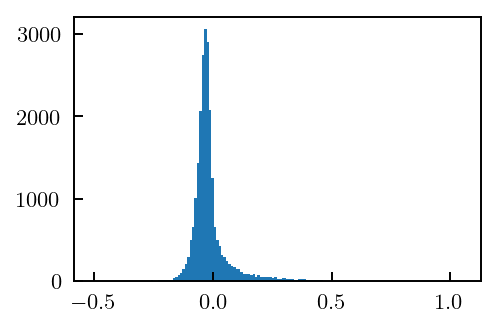

In [119]:
mpeaks_all = []
mh_all = []
# cat_z8_5_nolmc
for ci in cat_z8_5:
    mpi= np.array(ci["Mpeak"])
    mhi=np.array(ci["Mh"])
    mpeaks_all.append(mpi)
    mh_all.append(mhi)
    
mpeaks_all = np.concatenate(mpeaks_all)
mh_all = np.concatenate(mh_all)

plt.figure(figsize = (3,2))
plt.hist(np.log10(mpeaks_all/mh_all),bins = "sqrt")
plt.show()

## the conclusion is that the integration is happening good! Mpeak and Mh shoiuld be very similar